# Подключаем нужные библиотеки

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from algorithms import *
from tests import *

%matplotlib inline

# Логистическая регрессия

Для удобства продублируем здесь задачу, которую мы решаем
$$
F(x) = f(x) + R(x) = \frac{1}{m}\sum\limits_{i=1}^m\underbrace{\left(\log\left(1 + \exp\left(-y_i\cdot (Ax)_i\right)\right) + \frac{l_2}{2}\|x\|_2^2\right)}_{f_i(x)} + \underbrace{l_1\|x\|_1}_{R(x)} \to \min\limits_{x\in\mathbb{R}^n}
$$

### Объединим подготовку данных в одну функцию

In [2]:
def prepare_data(dataset):
    filename = "datasets/" + dataset + ".txt"

    data = load_svmlight_file(filename)
    A, y = data[0], data[1]
    m, n = A.shape
    
    if (2 in y) & (1 in y):
        y = 2 * y - 3
    if (2 in y) & (4 in y):
        y = y - 3
    assert((-1 in y) & (1 in y))
    
    sparsity_A = A.count_nonzero() / (m * n)
    return A, y, m, n, sparsity_A

In [3]:
def compute_L(dataset, A):
    filename = "dump/"+dataset+"_L.txt"
    file_path = Path(filename)
    if file_path.is_file():
        with open(filename, 'rb') as file:
            L, average_L, worst_L = pickle.load(file)
    else:
        sigmas = svds(A, return_singular_vectors=False)
        m = A.shape[0]
        L = sigmas.max()**2 / (4*m)
        
        worst_L = 0
        average_L = 0
        denseA = A.toarray()
        for i in range(m):
            L_temp = (norm(denseA[i])**2)*1.0 / 4
            average_L += L_temp / m
            if L_temp > worst_L:
                worst_L = L_temp
        with open(filename, 'wb') as file:
            pickle.dump([L, average_L, worst_L],file)
    return L, average_L, worst_L

## Задание 1. Разреженность матрицы

Рассмотрите датасеты $\texttt{a9a}$, $\texttt{gisette}$, $\texttt{australian}$ и ещё любых 2 датасета на ваш вкус из LIBSVM https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html. Для каждого выбранного датасета проанализируйте какой тип матрицы лучше использовать -- $\texttt{csr_matrix}$ или $\texttt{numpy.ndarray}$ -- чтобы вычислять для данного датасета 

1) полный градиент и

2) стох. градиент (рассмотреть батчи размера 1, 10, 100).

Как видно из формулы для подсчёта градиента 
$$
\nabla f(x) = -\frac{1}{m}\cdot\frac{A^\top y}{1+\exp(y\odot Ax)}  + l_2 x,
$$
и стох. градиента по батчу $S = \{i_1,i_2,\ldots,i_k\}$
$$
\frac{1}{k}\sum\limits_{j=1}^k \nabla f_{i_j}(x) = -\frac{1}{k}\cdot\frac{A_S^\top y_S}{1+\exp(y_S\odot A_Sx)}  + l_2 x,
$$
необходимо выполнить умножение $A^\top$ (или $A_S^\top$) на вектор и умножение $A$ (или $A_S$) на вектор, чтобы посчитать градиент (стох. градиент). Поэтому анализировать предлагается следующим способом: генерируется 5 случайных векторов размерности $n$, а затем в цикле много раз вычисляются градиенты (стох. градиенты) в указанных точках. Количество подсчётов градиентов выбирайте исходя из того, чтобы все умножения при одном из типов хранения матрицы $A$ занимали от 10 до 40 секунд. Для подсчёта стох. градиентов заранее насэмплируйте при помощи функции $\texttt{randint}$ большую выборку элементов от $0$ до $m-1$ (например, выборку размера $10^7$ элементов), а затем вырезайте из неё подряд идущие непересекающиеся куски длиной $r$, где $r$ -- размер батча. Для удобства считайте, что $l_2 = 0$

In [4]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
Wall time: 437 ms


По умолчанию матрица $A$ хранится в формате $\texttt{csr_matrix}$

In [5]:
denseA = A.toarray()
print(type(A))
print(type(denseA))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


Насэмплируем индексов для батчей

In [6]:
%%time
batch_indices = randint.rvs(low=0, high=m, size=10000000, random_state=None)

Wall time: 149 ms


Пример того, как выглядят тесты для полноградиентного случая

In [7]:
%%time
x = norm_d.rvs(size=n)

Wall time: 6.98 ms


In [8]:
num_of_tests = 600

In [9]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        logreg_grad(x, [A, y, 0, True])

Wall time: 13.9 s


In [10]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        logreg_grad(x, [denseA, y, 0, False])

Wall time: 18.8 s


Пример тестов для случая стох. градиентов

In [11]:
batch_size = 1
num_of_tests = 10000

In [12]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
        logreg_grad(x, [A[batch_ind], y[batch_ind], 0, True])

Wall time: 16.3 s


In [13]:
%%time
for j in range(5):
    x = norm_d.rvs(size=n)
    for i in range(num_of_tests):
        batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
        logreg_grad(x, [denseA[batch_ind], y[batch_ind], 0, False])

Wall time: 827 ms


In [14]:
def test_log_reg(dataset_name):
    # load data
    num_of_tests = 100
    A, y, m, n, sparsity_A = prepare_data(dataset_name)
    L, average_L, worst_L = compute_L(dataset_name, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
    # get dense numpy array
    denseA = A.toarray()
    # get indices for stochastic descent
    batch_indices = randint.rvs(low=0, high=m, size=10000000, random_state=42)
    
    ### test gradient descent
    # sparse matrix case
    time_sparse_gd = time.time() 
    for j in range(5):
        x = norm_d.rvs(size=n)
        for i in range(num_of_tests):
            logreg_grad(x, [A, y, 0, True])
    time_sparse_gd = time.time() - time_sparse_gd
    
    # dense matrix case
    time_dense_gd = time.time()    
    for j in range(5):
        x = norm_d.rvs(size=n)
        for i in range(num_of_tests):
            logreg_grad(x, [denseA, y, 0, False])
    time_dense_gd = time.time() - time_dense_gd
    
    ### test stochastic gradient descent
    #batch_size = 1
    times_sparse_sgd =[]
    times_dense_sgd = []
    
    for batch_size in [1,10,100]:
        # sparse matrix case
        start = time.time() 
        for j in range(5):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
                logreg_grad(x, [A[batch_ind], y[batch_ind], 0, True])
        times_sparse_sgd.append(time.time() - start)
        
        # dense matrix case
        start = time.time() 
        for j in range(5):
            x = norm_d.rvs(size=n)
            for i in range(num_of_tests):
                batch_ind = batch_indices[i*batch_size:(i+1)*batch_size]
                logreg_grad(x, [denseA[batch_ind], y[batch_ind], 0, False])
        times_dense_sgd.append(time.time() - start)
    
    return {'Dataset':dataset_name,'M':m,'N':n,'L':L,'Average_L':average_L,'Worst_L':worst_L,
            'Sparsity':sparsity_A,'Sparse GD Time':time_sparse_gd,'Dense GD Time':time_dense_gd,
            'Sparse SGD Time (batch 1)':times_sparse_sgd[0],'Dense SGD Time (batch 1)':times_dense_sgd[0],
            'Sparse SGD Time (batch 10)':times_sparse_sgd[1],'Dense SGD Time (batch 10)':times_dense_sgd[1],
            'Sparse SGD Time (batch 100)':times_sparse_sgd[2],'Dense SGD Time (batch 100)':times_dense_sgd[2]}    

In [15]:
dataset_names = ['a9a', 'gisette', 'australian', 'diabetes', 'heart']

In [16]:
results = []
for d in dataset_names:
    results.append(test_log_reg(d))

In [17]:
results_df = pd.DataFrame(results)

Зафиксируйте здесь результаты своих экспериментов:

In [18]:
results_df

Dataset      M     N             L     Average_L       Worst_L  \
0         a9a  32561   123  1.571920e+00  3.467277e+00  3.500000e+00   
1     gisette   6000  5000  8.428680e+02  1.163345e+03  1.201509e+03   
2  australian    690    14  7.036285e+06  7.051932e+06  2.500101e+09   
3    diabetes    768     8  8.606923e+03  1.086225e+04  1.899885e+05   
4       heart    270    13  2.671068e+04  2.714773e+04  9.036964e+04   

   Sparsity  Sparse GD Time  Dense GD Time  Sparse SGD Time (batch 1)  \
0  0.112757        2.058057       2.869457                   0.153616   
1  0.991000      122.874221      12.280622                   0.175278   
2  0.799586        0.153901       0.107672                   0.154587   
3  0.875814        0.100198       0.015623                   0.147106   
4  0.750997        0.069037       0.015651                   0.131799   

   Dense SGD Time (batch 1)  Sparse SGD Time (batch 10)  \
0                  0.000000                    0.153773   
1                  0.012033                    0.283000   
2                  0.008978                    0.144612   
3                  0.006509                    0.147131   
4                  0.015620                    0.137497   

   Dense SGD Time (batch 10)  Sparse SGD Time (batch 100)  \
0                   0.000000                     0.180789   
1                   0.127724                     3.600896   
2                   0.003173                     0.145106   
3                   0.000000                     0.153673   
4                   0.015647                     0.192799   

   Dense SGD Time (batch 100)  
0                    0.108708  
1                    1.187409  
2                    0.022129  
3                    0.015645  
4                    0.016654

#### Наблюдения
Dense vs Sparse. Во всех случаях кроме одного dense матрица посчиталась быстрее. Она заняла больше времени только в одном случае стохастического градиентого спуска, и в этом случае скорее всего потребовалось больше времени из-за размерности матрицы. Dense матрицы более эффективны в хранении, но как мы увидели при рассчётах они могут занять больше времени, потому что они хранятся особым образом и в результате рассчёты требуют большее количество манипуляций. <br> <br>

Value of L. Если сравнить время сходимости australian и heart то мы видим что значения sparsity у них близкие друг к другу. У них есть разница в числе функций (m) и L-гладкости. С увеличением m соответсвенно сходимость будет медленнее. Также с увеличением L-гладкости время схождения занимает больше времени. <br> <br>

Batch size. Судя по наблюдениям существует оптимальный размер батчей в зависимости от датасета. В случае gisette маленький батч дал наибыстрейший результат. В случае australian большие размеры батча дали чуть более быстрое время сходимости. Размер батча должен подбираться в зависимости от задачи. Ещё непонятно почему при выборе определённого размера батча в случае некоторых датасетов время схождения равно 0.

## Задание 2. Прокс-оператор

Имплементируйте функцию, вычисляющую $\text{prox}_R(x)$, где $R(x) = \lambda \|x\|_1$, $\lambda \geq 0$. Ваша функция должна брать первым аргументом точку $x$, в которой нужно посчитать прокс, а вторым аргументом -- число $\lambda$.

In [19]:
# напишите код в этой ячейке
def prox_R(x, lamb):
    # используя формулу данную в 5 лекции 
    return np.maximum(np.abs(x) - lamb, 0) * np.sign(x)

Для контроля корректности вызовите фунцию $\texttt{prox}\_\texttt{test}$ из файла $\texttt{tests.py}$. Если какой-то из тестов будет не пройден, то функция вернёт массив $[x, \lambda, \text{prox}_{R}(x)]$, где $x$ и $\lambda$ - параметры, на которых Ваша фукция выдала неправильный ответ, $\text{prox}_{R}(x)$ - это правильный ответ.

In [20]:
prox_test(prox_R)

Все тесты пройдены успешно!


0

## Задание 3. SVRG

Используя заготовку, которая оставлена в файле $\texttt{algorithms.py}$, имплементируйте $\texttt{prox-SVRG}$ с мини-батчингом. Обратите внимание, что в методе можно передавать выборку индексов $\texttt{indices}$ для контроля корректности работы. Однако если передавать $\texttt{None}$ в качестве $\texttt{indices}$, то в методе новые индексы тоже будут сэмплироваться не на каждй итерации. Сделано это осознанно: можн гораздо быстрее насэмплировать i.i.d. выборку размера, скажем, $N$ за один вызов функции, чем сэмплировать $N$ раз подряд выборку размера $1$. Это можно наглядно проверить. Для начала загрузим датасет $\texttt{a9a}$.

In [21]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) #L может зависеть от запуска, поэтому для каждой задачи нужно сохранить свою константу L
print("Константа гладкости всей функции: ", L)
print("Средняя константа гладкости     : ", average_L)
print("Худшая константа гладкости      : ", worst_L)
print("Доля ненулевых элементов: ", sparsity_A)

Число функций в сумме:  32561 , размерность задачи:  123
Константа гладкости всей функции:  1.5719196992226612
Средняя константа гладкости     :  3.467276803535652
Худшая константа гладкости      :  3.5
Доля ненулевых элементов:  0.11275696922074716
Wall time: 337 ms


В нём 32561 функция в сумме. Предположим, что мы запускаем $\texttt{prox-SGD}$ с размером батча $r = 1$ на $1000000$ итераций, что примерно 30 проходов по датасету, то есть не так уж и много. Давайте просэмплируем выборку размера $1000000$ за один раз и $1000000$ раз просэмплируем выборку размера $1$. Сначала просэмплируем сразу большую выборку.

In [22]:
%%time
randint.rvs(low=0, high=m, size=1000000, random_state=None)

Wall time: 21 ms


array([ 7742, 10652, 31847, ...,  3090,  3429,  3428])

На это ушло 1-3 секунды (зависит от мощности компьютера). А теперь рассмотрим второй вариант. Запустите следущую ячейку, а затем можете сходить заварить себе чай...

In [23]:
%%time
for i in range(1000000):
    randint.rvs(low=0, high=m, size=1, random_state=None)

Wall time: 1min 25s


Таким образом, выгоднее сэмплировать сразу много индексов, чтобы не терять много времени на сэмплирования.

Для проверки корректности работы метода предлагается воспользоваться заранее сгенерированной выборкой индексов и запустить для неё $\texttt{prox-SVRG}$ со следующими параметрами

In [24]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [25]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Wall time: 1.65 s


Запустите функцию, тестирующую корректность работы

In [26]:
svrg_test(res)

Тесты пройдены!


0

Для удобства тестирования и построения графиков методов Вам предлагается использовать следующие функции.

Данная функция нужна для того, чтобы получить доступ к результатам работы метода.

In [27]:
def read_results_from_file(filename, method, args):
    if method == 'SVRG':
        with open('dump/'+filename+'_SVRG_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])+"_num_of_epochs_"
                  +str(args[3])
              +"_epoch_length_"+str(args[4])+"_batch_size_"+str(args[5])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == 'L-SVRG':
        with open('dump/'+filename+'_L-SVRG_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])+"_num_of_epochs_"
                  +str(args[3])
              +"_prob_"+str(args[4])+"_batch_size_"+str(args[5])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == 'SAGA':
        with open('dump/'+filename+'_SAGA_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])+"_num_of_epochs_"
                  +str(args[3])
              +"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_const_stepsize":
        with open('dump/'+filename+'_SGD_const_stepsize_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "SGD_decr_stepsize":
        with open('dump/'+filename+'_SGD_decr_stepsize_gamma_'+str(args[0][0])+"_decr_period_"
                  +str(args[0][1])+"_decr_coeff_"+str(args[0][2])
                  +"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "prox-GD":
        with open('dump/'+filename+'_prox-GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "GD":
        with open('dump/'+filename+'_GD_gamma_'+str(args[0])+"_l2_"+str(args[1])+"_l1_"+str(args[2])
                  +"_num_of_epochs_"+str(args[3])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == "FISTA":
        with open('dump/'+filename+'_FISTA'+"_l2_"+str(args[0])+"_l1_"+str(args[1])
                  +"_num_of_epochs_"+str(args[2])+".txt", 'rb') as file:
            return pickle.load(file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [28]:
def save_solution(dataset, l2, l1, x_star, f_star):
    filename = "dump/"+dataset+"_solution_l2_"+str(l2)+"_l1_"+str(l1)+".txt"
    with open(filename, 'wb') as file:
        pickle.dump([x_star, f_star], file)

Эта функция нужна, чтобы выгрузить решение задачи для данного датасета при заданных $l_2$ и $l_1$.

In [29]:
def read_solution(dataset, l2, l1):
    with open('dump/'+dataset+'_solution_l2_'+str(l2)+"_l1_"+str(l1)+".txt", 'rb') as file:
        return pickle.load(file)

Теперь запустите $\texttt{prox-SVRG}$ с теми же параметрами, но на бОльшее число эпох. Сохраните $x^*$ и $f(x^*)$. Параметр $\texttt{indices}$ выставляйте равным $\texttt{None}$. Параметры $l_2$ и $l_1$ выбирайте согласно PDF-документу с заданиями. Посчитайте количество ненулевых значений в найденном решении.

In [33]:
# ваш код здесь
# задать параметры
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 500
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [34]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Найденное значение:  0.35785681111419754
Процент ненулевых координат в найденном решении:  0.2845528455284553
Wall time: 4min 17s


In [35]:
# ваш код здесь
# сохранить решение x_star и f_star
save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

Сравните найденное значение с тем, которое выдаёт стандартный солвер (сравните результаты для $l_1 = 0$ и $l_1 = \frac{L}{1000}$)

In [43]:
%%time
l1=0
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Найденное значение:  -0.029754116866597402
Процент ненулевых координат в найденном решении:  1.0
Wall time: 1.63 s


In [38]:
%%time
l1 = 0
param = [A, y, l2, True, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.325278
         Iterations: 565
         Function evaluations: 569
         Gradient evaluations: 568
0.32527803015195816
Wall time: 4.07 s


In [39]:
%%time
l1 = L / 1000
param = [A, y, l2, True, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.357986
         Iterations: 185
         Function evaluations: 253
         Gradient evaluations: 247
0.3579855634165789
Wall time: 1.8 s


In [61]:
%%time
l1 = L / 1000
A_aus, y, m, n, sparsity_A = prepare_data('australian')
x_init_aus = np.ones(n)
param = [A_aus, y, l2, True, l1]
res_solver = minimize(F, x_init_aus, args = param, jac=logreg_grad_plus_lasso, 
                      options={'maxiter':5000, 'disp':True}, tol=1e-10)

print(res_solver.fun)

         Current function value: 0.343745
         Iterations: 67
         Function evaluations: 91
         Gradient evaluations: 90
0.3437451264136039
Wall time: 54.6 ms


In [64]:
%%time
# задать параметры
l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 150000
save_info_period = 1000

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

res = svrg(filename=filename, x_init=x_init_aus, A=A_aus, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=None, f_star=None)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Найденное значение:  5237.793055621835
Процент ненулевых координат в найденном решении:  1.0
Wall time: 3min 26s


#### Наблюдения
Получили примерно одинаковое решение в случае использования x_star и f_star и l1 != 0 с датасетом а9а. В остальных случаях оптимальные решения близкие к стандартному солверу не получается получить даже если поставить большое количество эпох.

Теперь повторите эксперимент с $S = 3$, но передайте туда найденные при помощи $\texttt{prox-SVRG}$ $x^*$ и $f(x^*)$ в качестве $\texttt{x}{\_}\texttt{star}$ и $\texttt{f}{\_}\texttt{star}$

In [67]:
A, y, m, n, sparsity_A = prepare_data('a9a')
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

In [68]:
%%time
res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Wall time: 2.29 s


Следующая функция позволяет строить графики

In [179]:
def make_plots(args):
    supported_modes_y = ['squared_distances', 'func_vals']
    supported_modes_x = ['time', 'data_passes', 'iters']
    
    dataset = args[0]
    filename = args[1]
    mode_y = args[2]
    mode_x = args[3]
    figsize = args[4]
    fontsize = args[5]
    title = args[6]
    methods = args[7]
    
    assert(mode_y in supported_modes_y)
    assert(mode_x in supported_modes_x)
    
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=fontsize)
    marker = itertools.cycle(('+', 'd', 'x', 'o', '^', 's', '*', 'p', '<', '>', '^'))
    
    num_of_methods = len(methods)
    for idx, method in enumerate(methods):
        res = read_results_from_file(filename, method[0], method[1])
        if method[3] == None:
            length = len(res['iters'])
        else:
            length = method[3]
        plt.semilogy(res[mode_x][0:length], res[mode_y][0:length] / res[mode_y][0], linewidth=2, marker=next(marker), 
            markersize = 20, 
            #markevery=range(-idx*int(length/(10*num_of_methods)), len(res[mode_x][0:length]), int(length/10)), 
            label = method[0]+method[2])
        
    
    plt.legend(bbox_to_anchor=(2,1), loc="upper right", fontsize=fontsize)
    if mode_x == 'time':
        plt.xlabel(r"Time, $s$", fontsize=fontsize)
    if mode_x == 'sampled_grads':
        plt.xlabel(r"Number of sampled gradients / number of data samples", fontsize=fontsize)
    if mode_x == 'iters':
        plt.xlabel(r"Number of iterations", fontsize=fontsize)
    if mode_y == 'squared_distances':
        plt.ylabel(r"$\frac{||x^k - x^*||_2^2}{||x^0 - x^*||_2^2}$", fontsize=fontsize)
    if mode_y == 'func_vals':
        plt.ylabel(r"$\frac{f(x^k)-f(x^())}{f(x^0)-f(x^*)}$", fontsize=fontsize)
    
    plt.xticks(fontsize=fontsize)
    _ = plt.yticks(fontsize=fontsize)

In [70]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 10
gamma = 1.0/(6*(L+l2))

#это массив с методами и их парамтерами, для которых мы хотим построить графики
#в кждом массиве внутри этого массива есть 4 элемента
#первый элемент -- название метода
#второй элемент -- [параметры, чтобы открыть файл]
#третий элемент -- метка, которая будет использоваться в легенде графика
#четвёртый элемент -- None или целое число, если Вы хотите обрезать график справа
methods = [
         ['SVRG', [gamma, l2, l1, 3, int(2*m/10), 10], 
           ' третий аргумент', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]

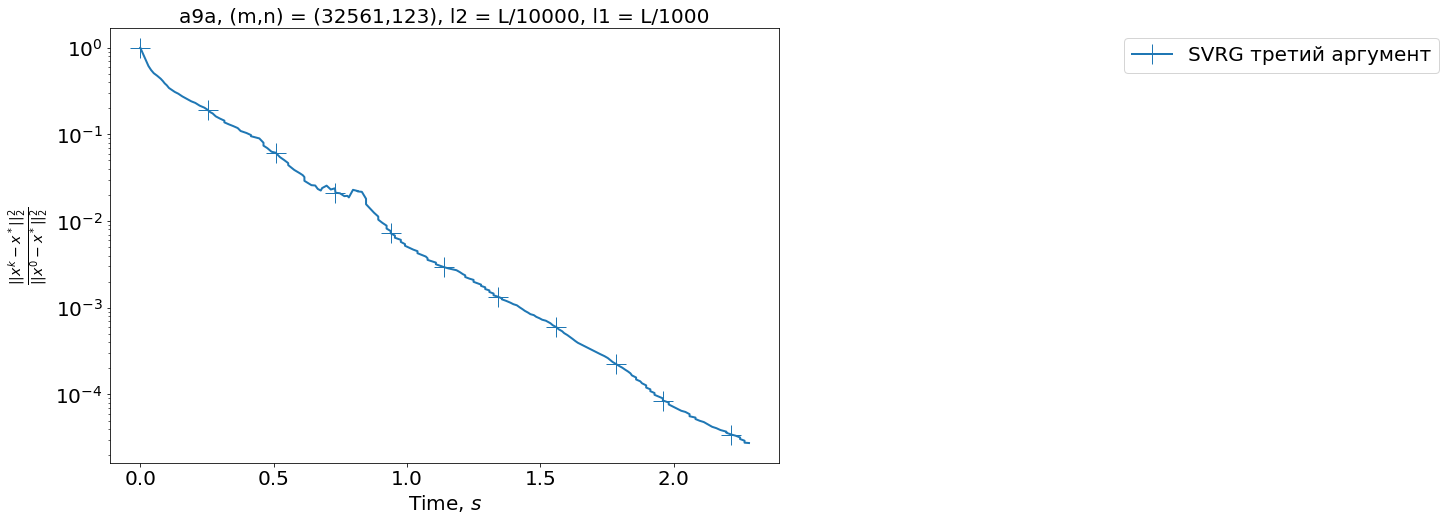

In [71]:
make_plots(args=args_for_plots)

Попробуйте разные размеры батчей и разные $l_2$ и $l_1$, как это указано в задании

###### Эксперимент 1. Разные значения размера батча

In [135]:
for r in [1, 10, 100]:
    dataset = "a9a"
    filename=dataset + "_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 50
    save_info_period = 50
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

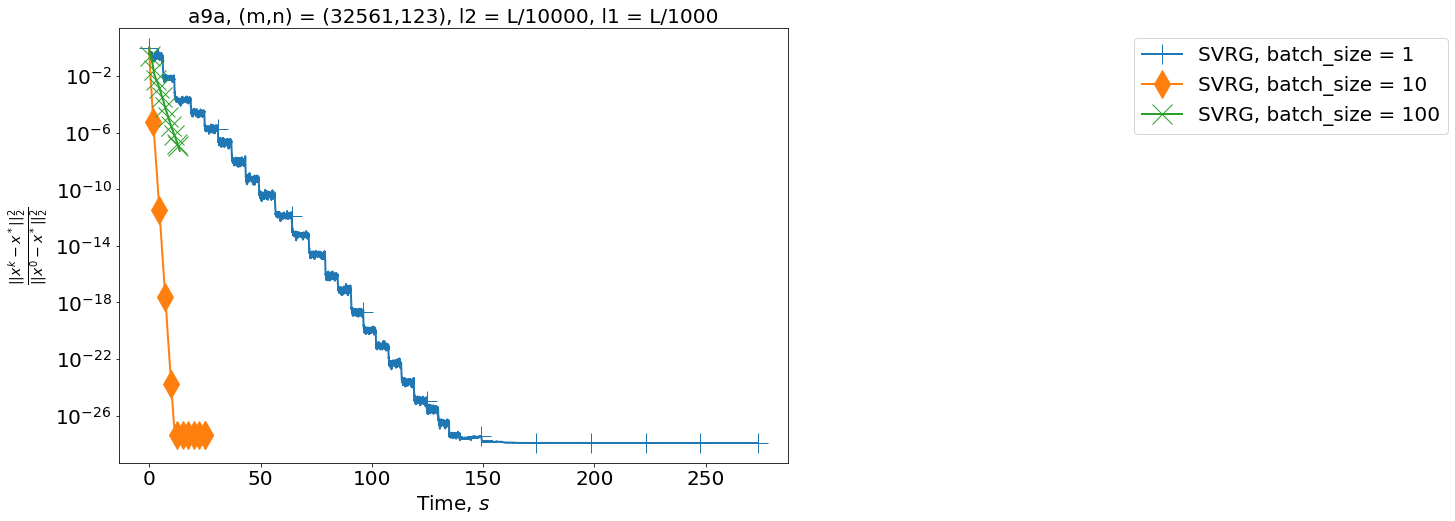

In [74]:
r_1 = 1
r_10 = 10
r_100 = 100
gamma = 1.0/(6*(L+l2))
methods = [
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_1), r_1], 
           f', batch_size = {r_1}', None],
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_10), r_10], 
           f', batch_size = {r_10}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_100), r_100], 
           f', batch_size = {r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Наблюдения
Оптимальный размер батча приводит к быстрой сходимости.

##### Эксперимент 2. Разные значения l2

In [75]:
for l2_ in[L/100000,L/10000,L/1000]:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    test_indices = None
    x_init = np.ones(n)
    l2 = l2_
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    #x_star = read_solution(dataset, l2,l1)[0]
    #f_star = read_solution(dataset, l2,l1)[1]
    S = 40
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

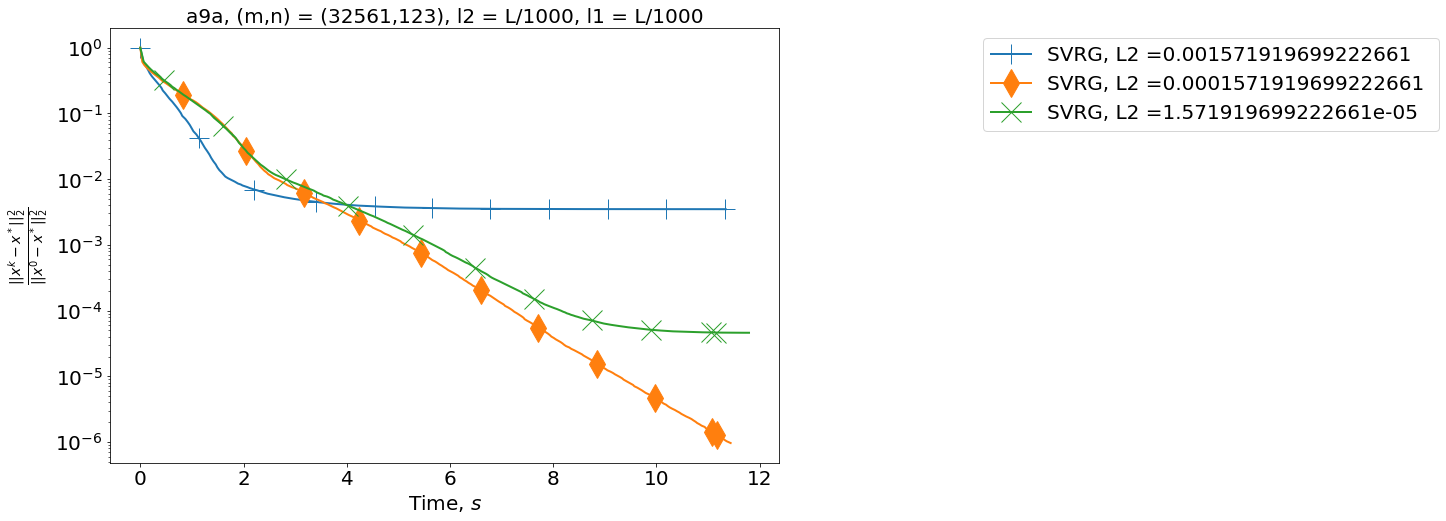

In [77]:
l2_1000 = L/1000
l2_10000 = L/10000
l2_100000 = L/100000
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
batch_size = 100
gamma_1000 = 1.0/(6*(L+l2_1000))
gamma_10000 = 1.0/(6*(L+l2_10000))
gamma_100000 = 1.0/(6*(L+l2_100000))
methods = [
        ['SVRG', [gamma_1000, l2_1000, l1, S, int(2*m/batch_size), 100], 
           f', L2 ={l2_1000} ', None],
        ['SVRG', [gamma_10000, l2_10000, l1, S, int(2*m/batch_size), 100], 
               f', L2 ={l2_10000} ', None],
        ['SVRG', [gamma_100000, l2_100000, l1, S, int(2*m/batch_size), 100], 
               f', L2 ={l2_100000} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Наблюдение
Правильный выбор l2 регулизатора приводит к более точному ответу. 

## Задание 4. SGD

Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и постоянным шагом. Имплементируйте $\texttt{prox-SGD}$ с мини-батчингом и периодически уменьшающимся шагом.

In [78]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [79]:
%%time
res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Wall time: 673 ms


Запустите функцию, тестирующую корректность работы

In [80]:
sgd_const_test(res)

Тесты пройдены!


0

In [81]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)

filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
gamma_schedule = [gamma, 1, 0.5]
x_star = None
f_star = None
S = 10
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = True
sparse_stoch = False

In [82]:
%%time
res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Wall time: 2.06 s


Запустите функцию, тестирующую корректность работы

In [83]:
sgd_decr_test(res)

Тесты пройдены!


0

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

##### Эксперимент 1. Разные размеры шага.

In [137]:
for alpha in [1.0,0.1,0.01]:
    dataset = "a9a"
    filename=dataset+"_x_init_all_ones"
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = alpha/((L+l2))
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

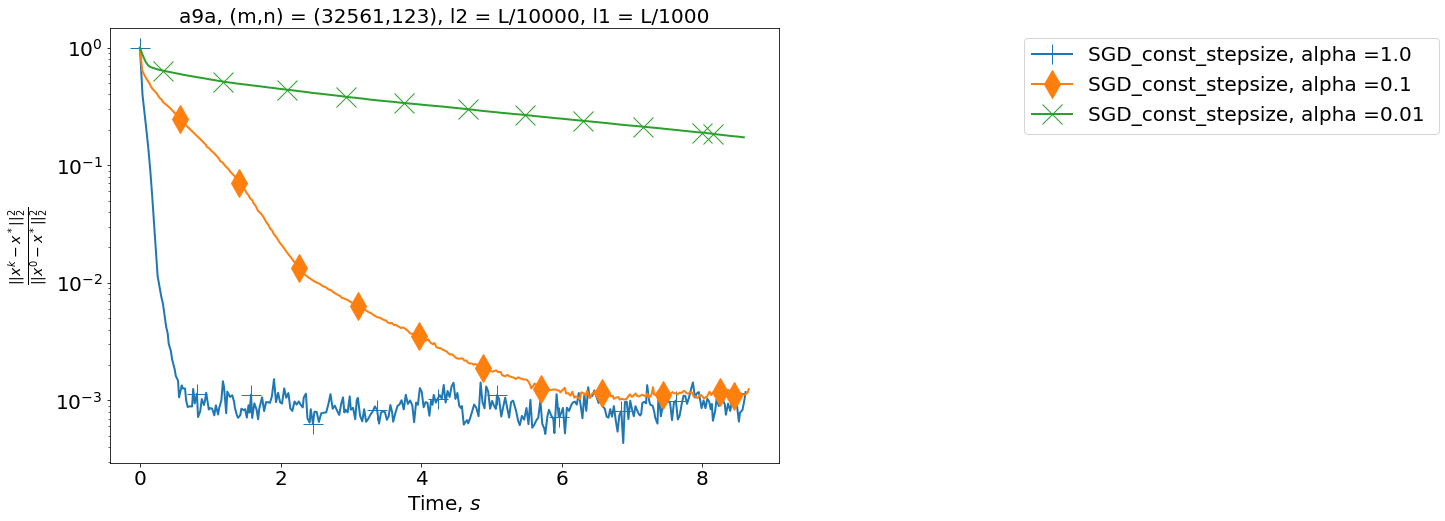

In [85]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
gamma_1 = 1.0/((L+l2))
gamma_01 = 0.1/((L+l2))
gamma_001 = 0.01/((L+l2))

methods = [
        ['SGD_const_stepsize', [gamma_1, l2, l1, S, 100], 
           f', alpha ={1.0} ', None],
        ['SGD_const_stepsize', [gamma_01, l2, l1, S, 100], 
           f', alpha ={0.1} ', None], # l2 = L / 10000, l1 = L / 1000, S=100, gamma_01 = 0.1/((L+l2))
        ['SGD_const_stepsize', [gamma_001, l2, l1, S, 100], 
           f', alpha ={0.01} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Наблюдения
При большом выборе шага минимум достигается быстрее. Также существует определенный лимит точности с случае sgd дальше которого solver не может пройти.

##### Эксперимент 2. Разные политики выбора шага.

In [86]:
for schedule in [[gamma, 10, 0.8],[gamma, 10, 0.5],[gamma, 5, 0.8],[gamma, 5, 0.5]]:
    filename=dataset
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = 0.01/(6*(L+l2))
    gamma_schedule = schedule
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

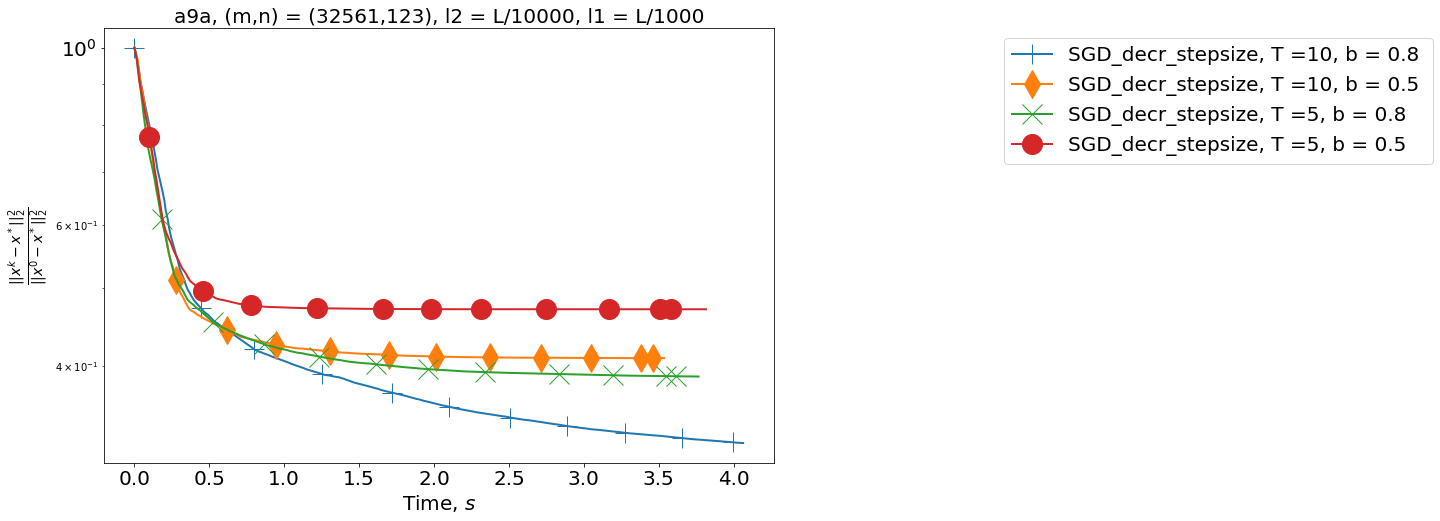

In [87]:
schedule_1 = [gamma, 10, 0.8]
schedule_2 = [gamma, 10, 0.5]
schedule_3 = [gamma, 5, 0.8]
schedule_4 = [gamma, 5, 0.5]

filename=dataset
l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
gamma = 0.01/(6*(L+l2))
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule_1, l2, l1, S, 100], 
           f', T ={schedule_1[1]}, b = {schedule_1[2]} ', None],
        ['SGD_decr_stepsize', [schedule_2, l2, l1, S, 100], 
           f', T ={schedule_2[1]}, b = {schedule_2[2]} ', None],
        ['SGD_decr_stepsize', [schedule_3, l2, l1, S, 100], 
           f', T ={schedule_3[1]}, b = {schedule_3[2]} ', None],
        ['SGD_decr_stepsize', [schedule_4, l2, l1, S, 100], 
           f', T ={schedule_4[1]}, b = {schedule_4[2]} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Наблюдение
При правильно подобранных значениях периода изменения шага и величины затухания шага можно получить более точные результаты.

##### Эксперимент 3. Разные размеры батча.

In [122]:
for r in [1, 10, 100]:
    filename=dataset
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = 0.01/(6*(L+l2))
    gamma_schedule = [gamma, 10, 0.8]
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

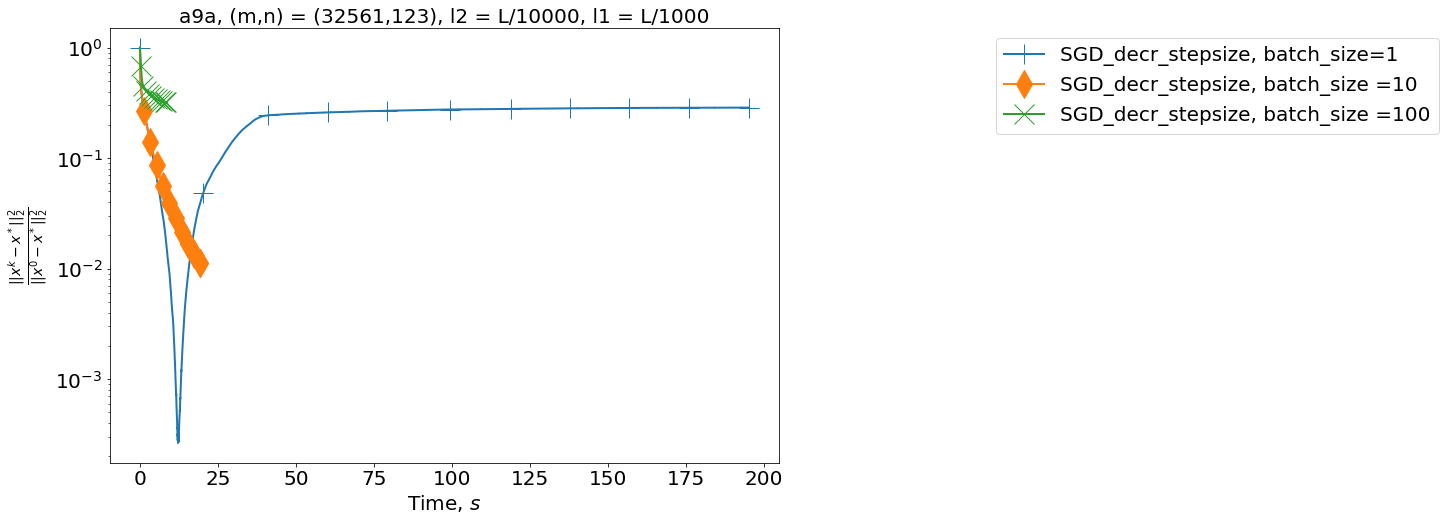

In [123]:
r_1 = 1
r_10 = 10
r_100 = 100
schedule = [gamma, 10, 0.8]

filename=dataset
l2 = L / 10000
l1 = L / 1000
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_1], 
           f', batch_size={r_1}', None],
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_10], 
           f', batch_size ={r_10}', None], # r_10 = 10, schedule = [gamma, 10, 0.8], S=100, l2 = L / 10000, l1 = L / 1000
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_100], 
           f', batch_size ={r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

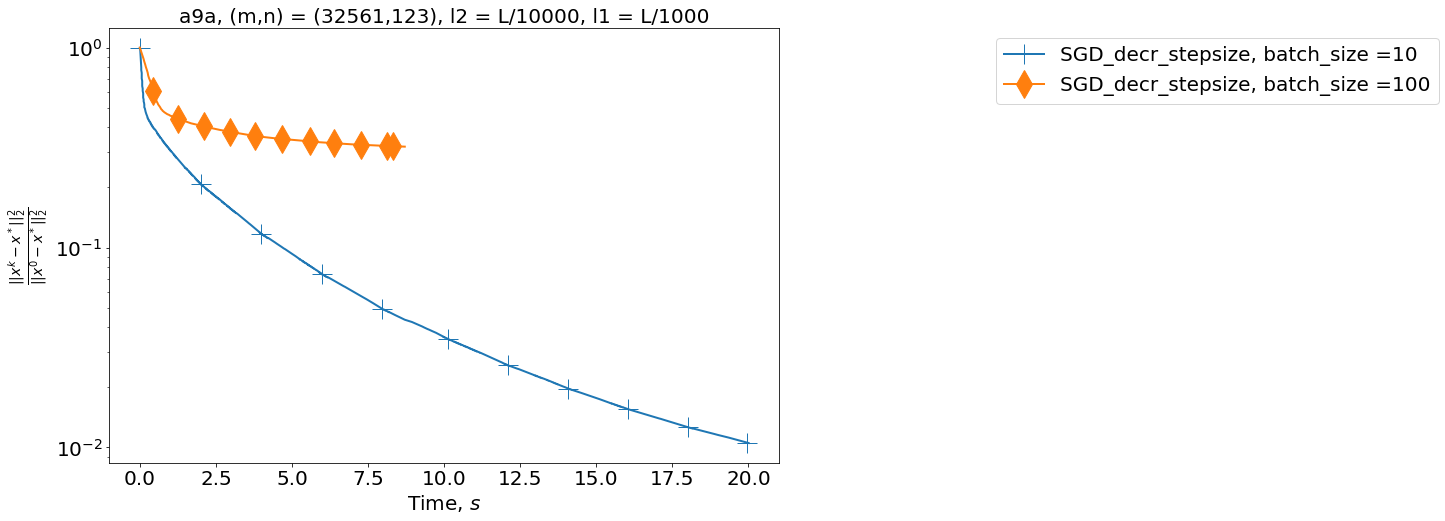

In [124]:
r_10 = 10
r_100 = 100
schedule = [gamma, 10, 0.8]

filename=dataset
l2 = L / 10000
l1 = L / 1000
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_10], 
           f', batch_size ={r_10}', None],
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_100], 
           f', batch_size ={r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Наблюдения
При разных размерах батча достигаются разные результаты. Батч размером 10 показывает лучший результат по точности при определённом количестве эпох. Большой размер батча считается долго. Размер батча равный одному показыает странный результат. Он сначала достигает большую точность, но потом возвращается обратно.

## Задание 5. L-SVRG

Имплементируйте $\texttt{prox-L-SVRG}$ с мини-батчингом.

Для $\texttt{prox-L-SVRG}$ для тестирования корректности используйте заранее насэмплированную выборку bernoulli_exp из распределения Бернулли с нужным параметром. Этот массив нужен, чтобы определять, нужно ли обновлять $w$ на текущей итерации или нет. Если обновляется $w$, то нужно пересчитать полный градиент в точке $w$, чтобы потом его можно было использовать. Как и в случае сэмплирования индексов для выбора слагаемых, гораздо быстрее сгенерировать выборку некоторого размера $N$ из распределения Бернулли, чем сэмплировать $N$ раз, поэтому предлагается периодически сэмплировать выборку из распределения Бернулли некоторого разумного размера, нежели сэмплировать выборку размера $1$ на каждой итерации. Кроме того, возможность передавать массив bernoulli_exp в метод введена для того, чтобы можно было проконтроллировать правильность работы Вашей имплементации, т.к. в таком случае для метода заранее определено (на первых len(bernoulli_exp) итерациях), в какие моменты происходит обновление $w$.

In [4]:
with open("dump/test_indices_a9a.txt", 'rb') as file:
    test_indices = pickle.load(file)
with open("dump/bernoulli_test.txt", 'rb') as file:
    bernoulli_exp = pickle.load(file)
dataset='a9a'
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A)
x_init = np.ones(n)
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
batch_size = 10
p = 1.0*batch_size / m
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 3
save_info_period = 100

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

Число функций в сумме:  32561 , размерность задачи:  123


In [5]:
%%time
res = l_svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, p=p, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, bernoulli_exp=bernoulli_exp,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Wall time: 1min 4s


Запустите функцию, тестирующую корректность работы

In [6]:
l_svrg_test(res)

Некорректная последняя точка


1

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

In [ ]:
# не получилось пройти тесты

## Задание 6. prox-GD, FISTA и GD

Имплементируйте $\texttt{prox-GD}$, $\texttt{FISTA}$ и $\texttt{GD}$

In [95]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [96]:
%%time
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Wall time: 4.43 s


Запустите функцию, тестирующую корректность работы

In [97]:
prox_gd_test(res)

Тесты пройдены!


0

In [98]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [99]:
%%time
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Wall time: 4.5 s


Запустите функцию, тестирующую корректность работы

In [100]:
fista_test(res)

Тесты пройдены!


0

In [101]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1000
save_info_period = 10

#этото параметр выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse = True

In [102]:
%%time
res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

Wall time: 4.53 s


Запустите функцию, тестирующую корректность работы

In [103]:
gd_test(res)

Тесты пройдены!


0

Если тесты пройдены успешно, то выполните эксперименты, описанные в задании.

#### Эксперимент 1. FISTA

In [140]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
x_star = None
f_star = None
S = 1000
save_info_period = 10
sparse = True
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

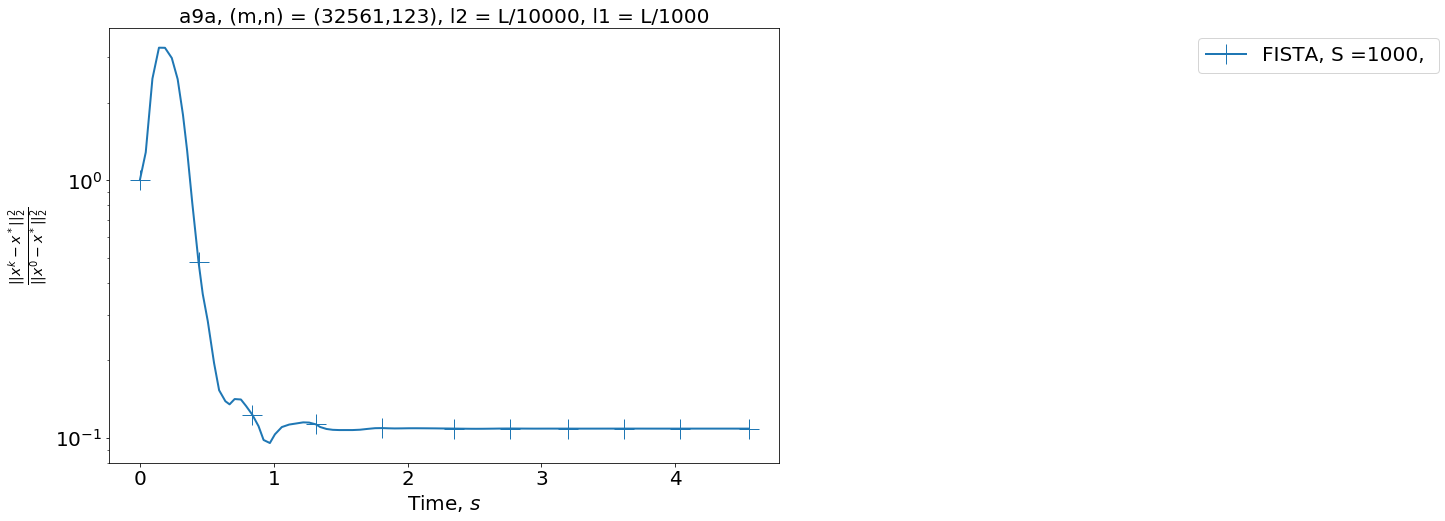

In [141]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"

methods = [
         ['FISTA', [l2, l1, S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

##### Эксперимент 2. prox-GD

In [142]:
dataset = "a9a"
filename=dataset
x_init = np.ones(n)
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1500
save_info_period = 10
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

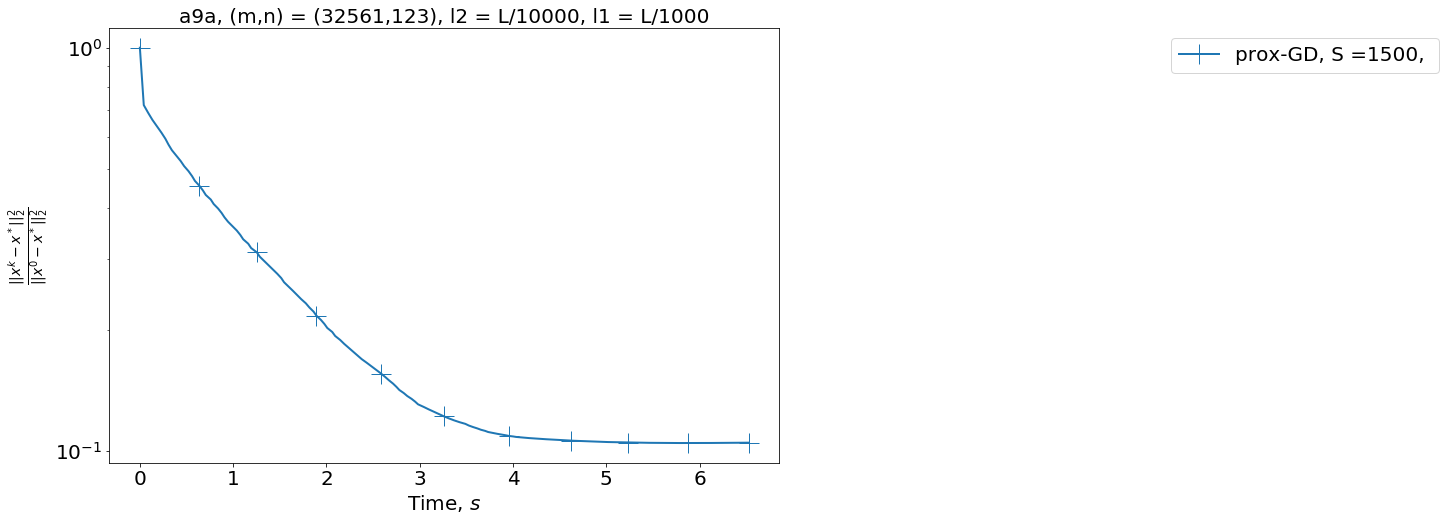

In [109]:
dataset = "a9a"
filename=dataset+"_x_init_all_ones"

methods = [
         ['prox-GD', [gamma, l2, l1,S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Эксперимент 3. GD

In [143]:
for gamma_ in [0.1]:
    dataset = "a9a"
    filename=dataset
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    gamma = gamma_/((L+l2))
    S = 12000
    save_info_period = 10
    sparse = False
    res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
         sparse=sparse, l1=l1, S=S, max_t=np.inf,
         save_info_period=save_info_period, 
         x_star=x_star, f_star=f_star)

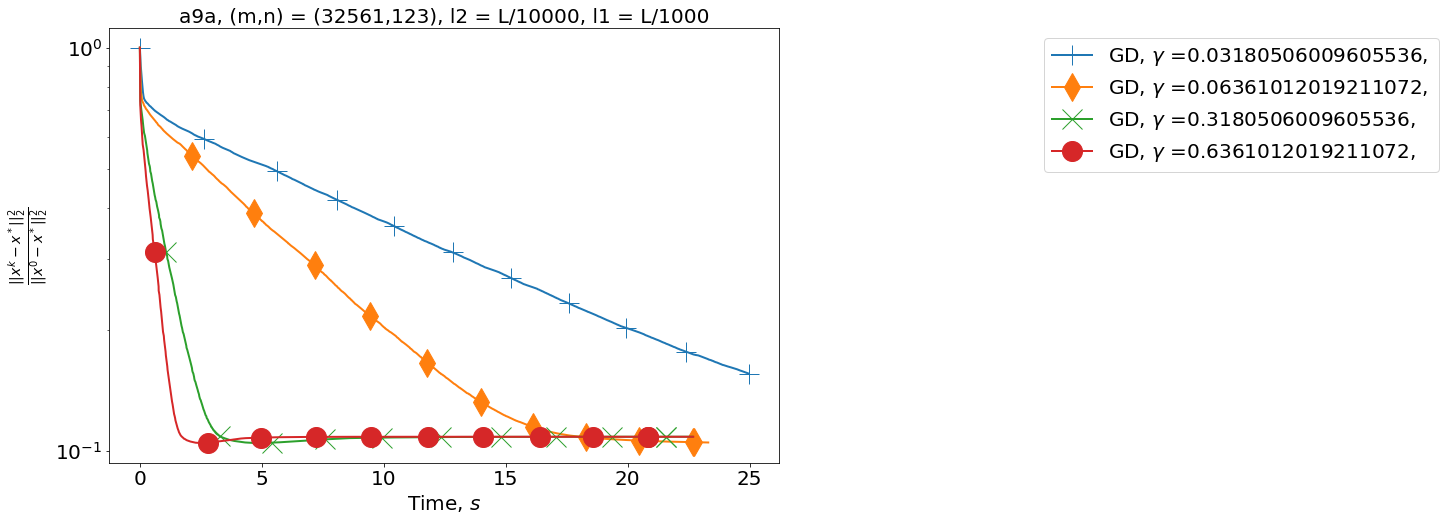

In [115]:
gamma_005 = 0.05/((L+l2))
gamma_01 = 0.1/((L+l2))
gamma_05 = 0.5/((L+l2))
gamma_1 = 1/((L+l2))

methods = [
    ['GD', [gamma_005,l2, l1, S], 
           f', $\gamma$ ={gamma_005}, ', None],
    ['GD', [gamma_01,l2, l1, S], 
           f', $\gamma$ ={gamma_01}, ', None],
    ['GD', [gamma_05,l2, l1, S], 
           f', $\gamma$ ={gamma_05}, ', None],
    ['GD', [gamma_1,l2, l1, S], 
           f', $\gamma$ ={gamma_1}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Общее сравнение

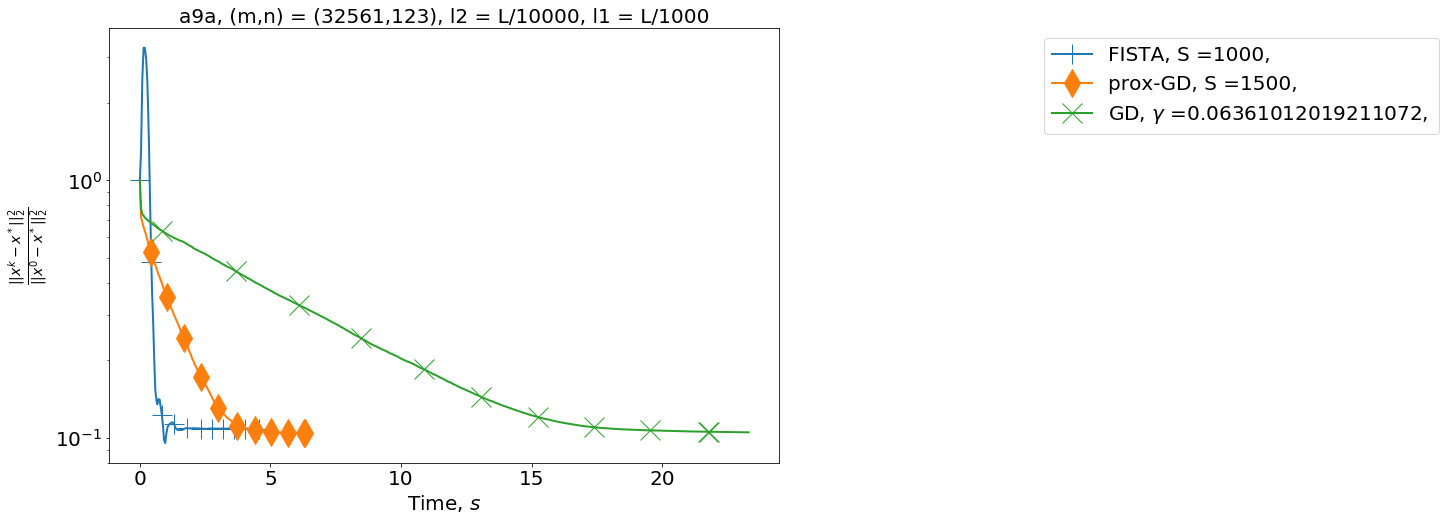

In [119]:
methods = [
        ['FISTA', [l2, l1, 1000], 
           f', S ={1000}, ', None],
        ['prox-GD', [gamma, l2, l1,1500], 
           f', S ={1500}, ', None],
        ['GD', [gamma_01,l2, l1, S], 
           f', $\gamma$ ={gamma_01}, ', None],
]

mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Наблюдения
Все три метода приходят примерно к одной и той же оптимальной точке. FISTA как и ожидаемо работает быстрее остальных методов, а простой GD медленее остальных.

## Задание 7. Сравнение методов

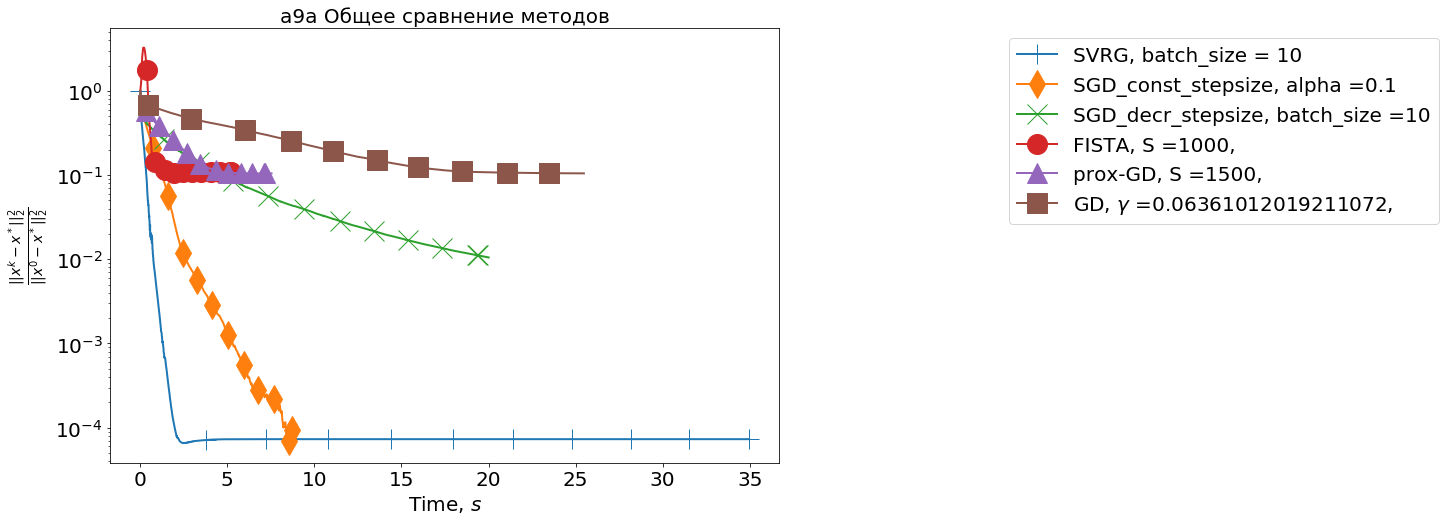

In [146]:
A, y, m, n, sparsity_A = prepare_data(dataset)
L, average_L, worst_L = compute_L(dataset, A)

dataset = "a9a"
filename=dataset#+"_x_init_all_ones"
l2 = L / 10000
l1 = L / 1000
batch_size = 100
gamma = 1.0/(6*(L+l2))
methods = [
    ['SVRG', [1.0/(6.0*(L+l2)), L/10000, L/1000, 50, int(2*m/10), 10], 
           f', batch_size = {10}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
    
    ['SGD_const_stepsize', [0.1/((L+l2)), l2, l1, 100, 100], 
           f', alpha ={0.1} ', None], # l2 = L / 10000, l1 = L / 1000, S=100, gamma_01 = 0.1/((L+l2))
    
    ['SGD_decr_stepsize', [schedule, l2, l1, 100, 10], 
           f', batch_size ={r_10}', None], # r_10 = 10, schedule = [gamma, 10, 0.8], S=100, l2 = L / 10000, l1 = L / 1000
    
    ['FISTA', [l2, l1, 1000], 
           f', S ={1000}, ', None],
    
    ['prox-GD', [1.0/((L+l2)), l2, l1, 1500], 
       f', S ={1500}, ', None],
    
    ['GD', [gamma_01,l2, l1, 12000], 
       f', $\gamma$ ={gamma_01}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+" Общее сравнение методов"

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)

#### Наблюдения
SVRG работает намного быстрее всех остальных методов. FISTA, prox-GD не находят наиболее оптимального решения. Я думал что SGD должны блуждать вокруг оптимального решения и быть далеки от оптимального решения. Причиной неточности GD может быть просто недостаточное время для поиска оптимума. Она требует намного больше времени по сравнению со стохастической вариацией. Также видим что в случае SGD с константым шагом нам повезло и мы нашли хороший шаг который быстро приводит к оптимуму. Но на практике задачи бывают на много сложнее и путём подбора находить оптимум очень непрактично.

## Задание 8. Эксперименты с другими датасетами

### Australian dataset

In [166]:
dataset = "australian"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A)
x_init = np.ones(n)

Число функций в сумме:  690 , размерность задачи:  14


In [178]:
%%time
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 500
save_info_period = 100
filename = dataset

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Найденное значение:  0.6931471805599454
Процент ненулевых координат в найденном решении:  0.0
Wall time: 4.37 s


In [168]:
# ваш код здесь
# сохранить решение x_star и f_star
save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

#### Размеры батчей SVRG

In [169]:
for r in [1, 10, 100]:
    filename=dataset
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 50
    save_info_period = 50
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

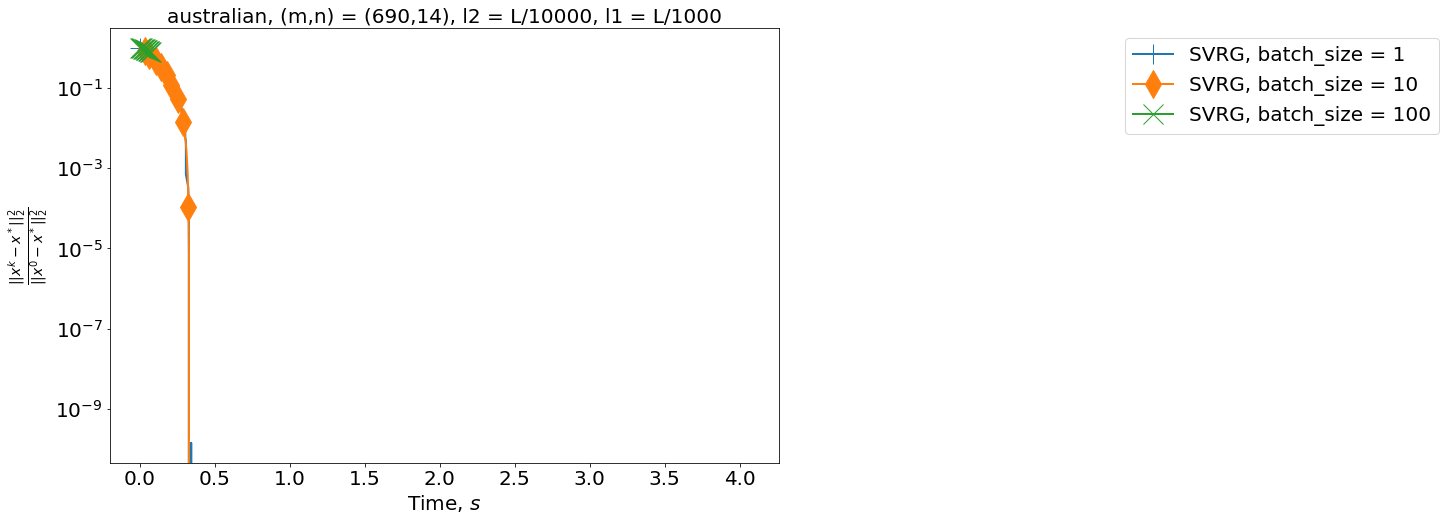

In [173]:
r_1 = 1
r_10 = 10
r_100 = 100
gamma = 1.0/(6*(L+l2))
methods = [
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_1), r_1], 
           f', batch_size = {r_1}', None],
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_10), r_10], 
           f', batch_size = {r_10}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_100), r_100], 
           f', batch_size = {r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### l2 регулизатор SVRG

In [185]:
for l2_ in[L/100000,L/10000,L/1000]:
    test_indices = None
    x_init = np.ones(n)
    l2 = l2_
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    S = 40
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

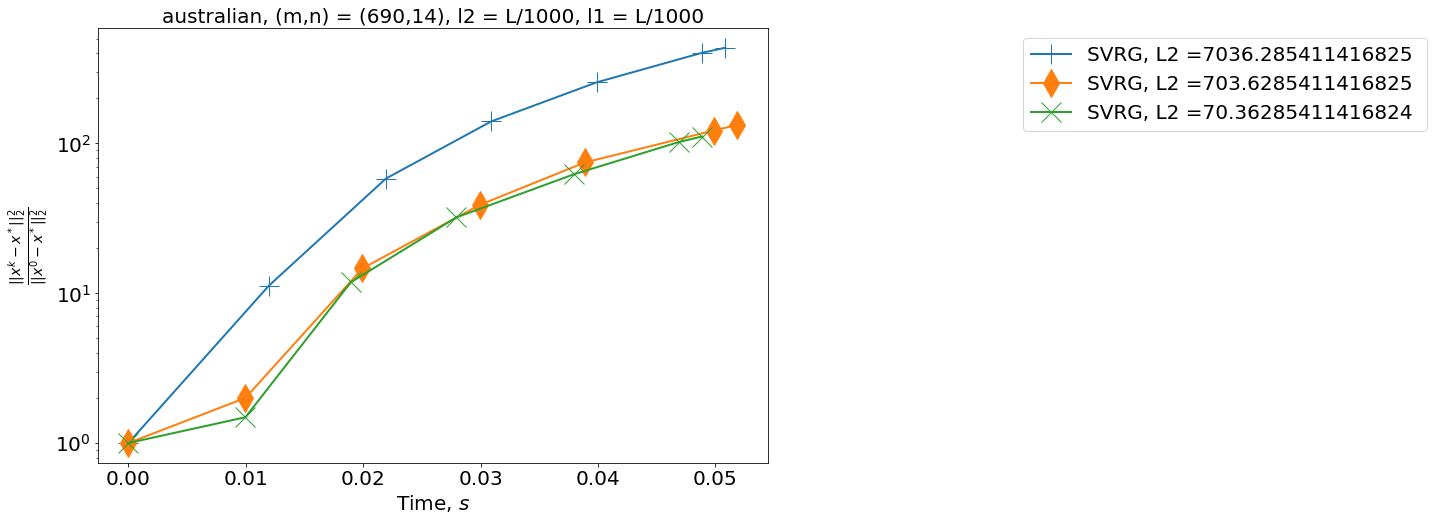

In [186]:
l2_1000 = L/1000
l2_10000 = L/10000
l2_100000 = L/100000
batch_size = 100
gamma_1000 = 1.0/(6*(L+l2_1000))
gamma_10000 = 1.0/(6*(L+l2_10000))
gamma_100000 = 1.0/(6*(L+l2_100000))
methods = [
        ['SVRG', [gamma_1000, l2_1000, l1, S, int(2*m/batch_size), 100], 
           f', L2 ={l2_1000} ', None],
        ['SVRG', [gamma_10000, l2_10000, l1, S, int(2*m/batch_size), 100], 
               f', L2 ={l2_10000} ', None],
        ['SVRG', [gamma_100000, l2_100000, l1, S, int(2*m/batch_size), 100], 
               f', L2 ={l2_100000} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Размеры шага SGD

In [180]:
for alpha in [1.0,0.1,0.01]:
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = alpha/((L+l2))
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

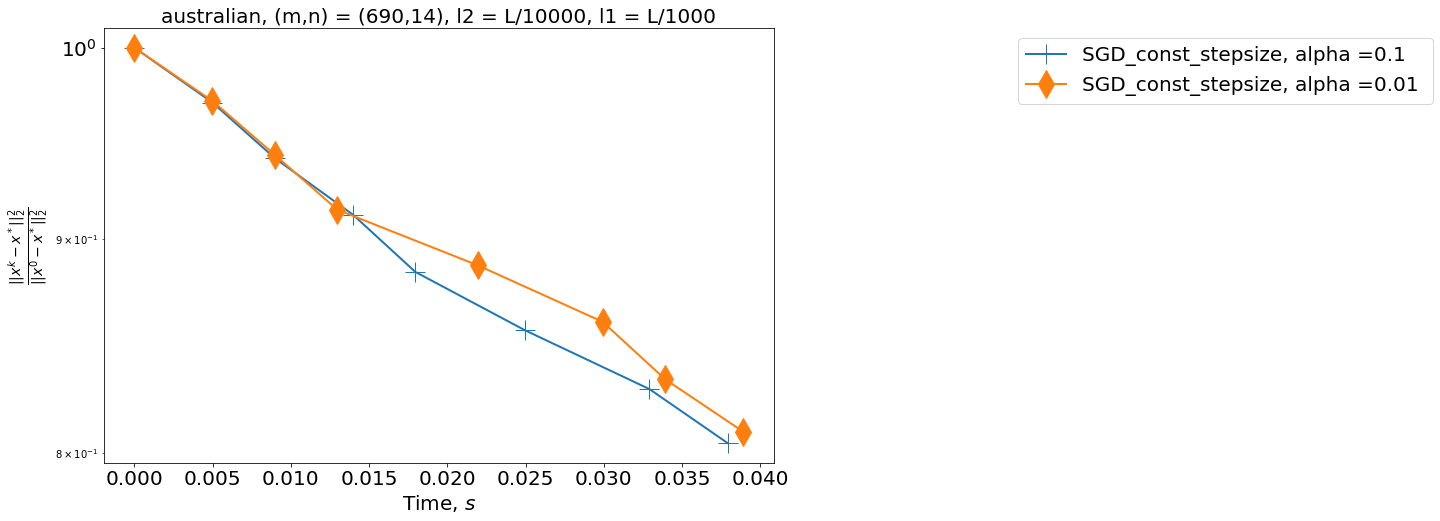

In [184]:
l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
gamma_1 = 1.0/((L+l2))
gamma_01 = 0.1/((L+l2))
gamma_001 = 0.01/((L+l2))

methods = [
        ['SGD_const_stepsize', [gamma_1, l2, l1, S, 100], 
           f', alpha ={1.0} ', None],
        ['SGD_const_stepsize', [gamma_01, l2, l1, S, 100], 
           f', alpha ={0.1} ', None], # l2 = L / 10000, l1 = L / 1000, S=100, gamma_01 = 0.1/((L+l2))
        ['SGD_const_stepsize', [gamma_001, l2, l1, S, 100], 
           f', alpha ={0.01} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

##### Разные политики выбора шага SGD

In [188]:
for schedule in [[gamma, 10, 0.8],[gamma, 10, 0.5],[gamma, 5, 0.8],[gamma, 5, 0.5]]:
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = 0.01/(6*(L+l2))
    gamma_schedule = schedule
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

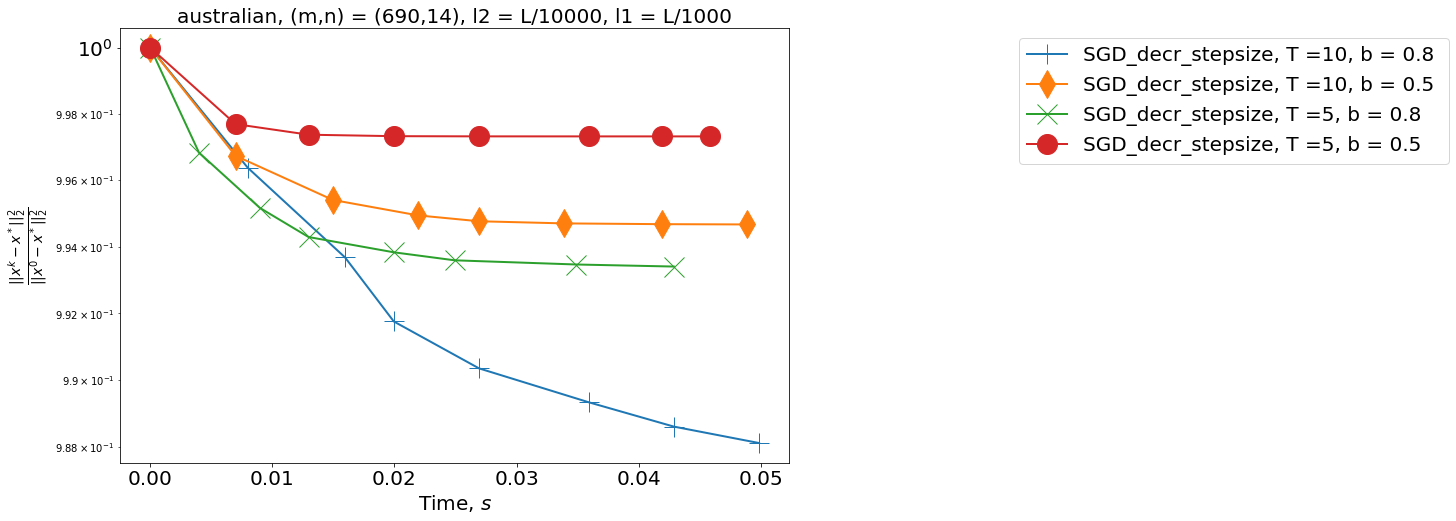

In [189]:
schedule_1 = [gamma, 10, 0.8]
schedule_2 = [gamma, 10, 0.5]
schedule_3 = [gamma, 5, 0.8]
schedule_4 = [gamma, 5, 0.5]

l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
gamma = 0.01/(6*(L+l2))
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule_1, l2, l1, S, 100], 
           f', T ={schedule_1[1]}, b = {schedule_1[2]} ', None],
        ['SGD_decr_stepsize', [schedule_2, l2, l1, S, 100], 
           f', T ={schedule_2[1]}, b = {schedule_2[2]} ', None],
        ['SGD_decr_stepsize', [schedule_3, l2, l1, S, 100], 
           f', T ={schedule_3[1]}, b = {schedule_3[2]} ', None],
        ['SGD_decr_stepsize', [schedule_4, l2, l1, S, 100], 
           f', T ={schedule_4[1]}, b = {schedule_4[2]} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

##### Разные размеры батча SGD

In [190]:
for r in [1, 10, 100]:
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = 0.01/(6*(L+l2))
    gamma_schedule = [gamma, 10, 0.8]
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

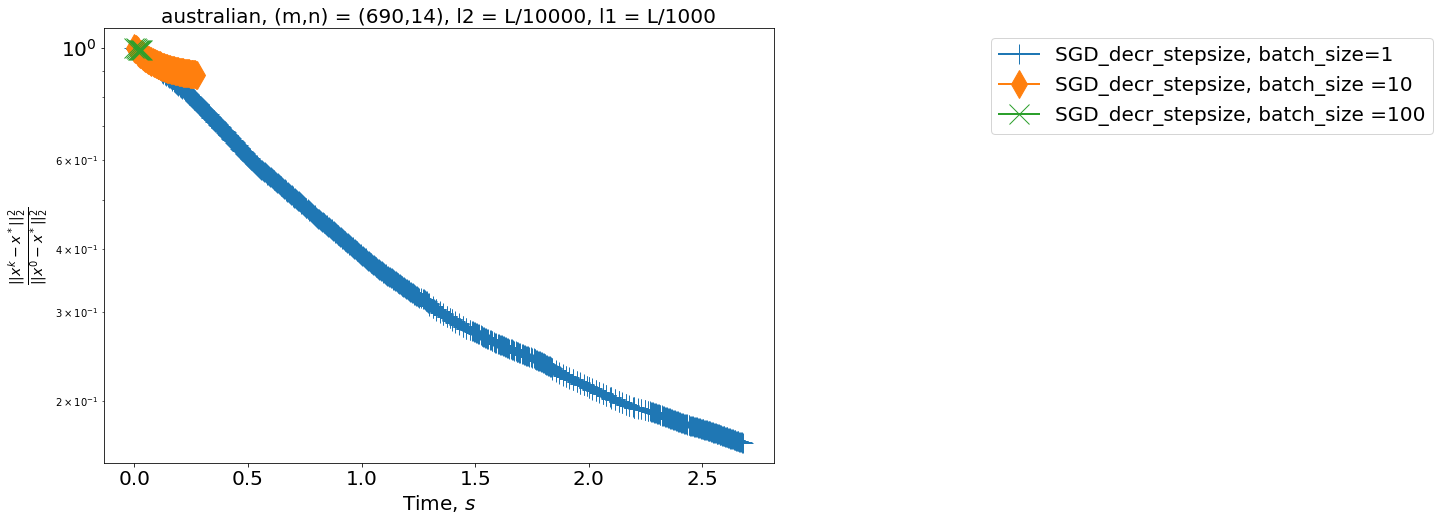

In [191]:
r_1 = 1
r_10 = 10
r_100 = 100
schedule = [gamma, 10, 0.8]

l2 = L / 10000
l1 = L / 1000
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_1], 
           f', batch_size={r_1}', None],
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_10], 
           f', batch_size ={r_10}', None], # r_10 = 10, schedule = [gamma, 10, 0.8], S=100, l2 = L / 10000, l1 = L / 1000
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_100], 
           f', batch_size ={r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

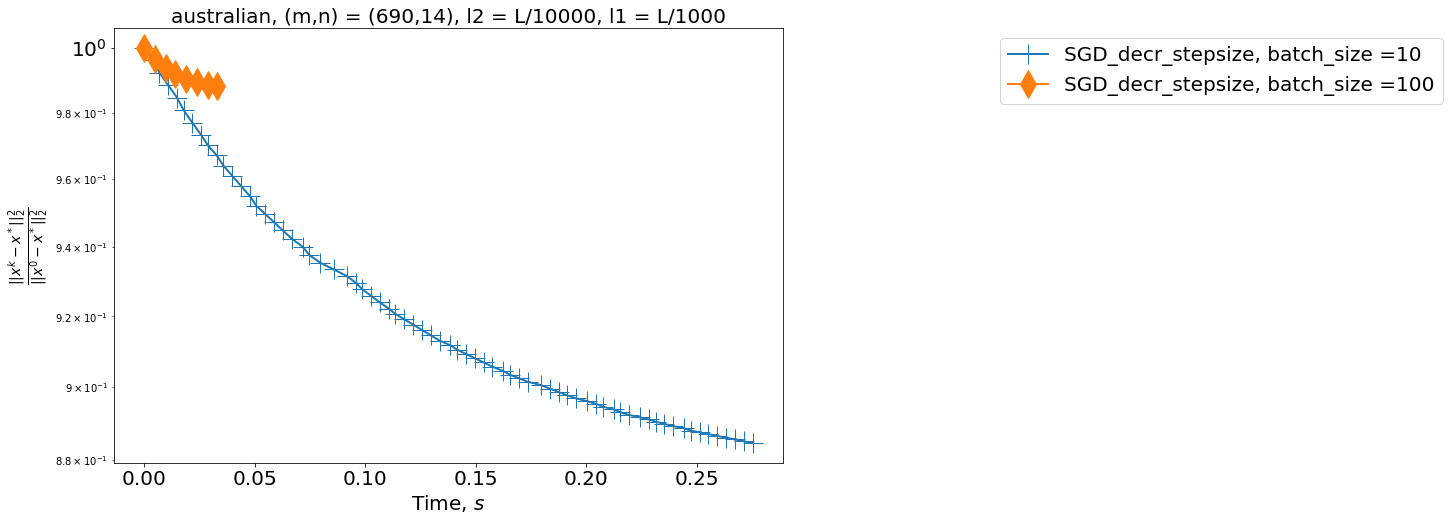

In [192]:
r_10 = 10
r_100 = 100
schedule = [gamma, 10, 0.8]

filename=dataset
l2 = L / 10000
l1 = L / 1000
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_10], 
           f', batch_size ={r_10}', None],
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_100], 
           f', batch_size ={r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### FISTA

In [193]:
l2 = L / 10000
l1 = L / 1000
x_star = None
f_star = None
S = 1000
save_info_period = 10
sparse = True
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

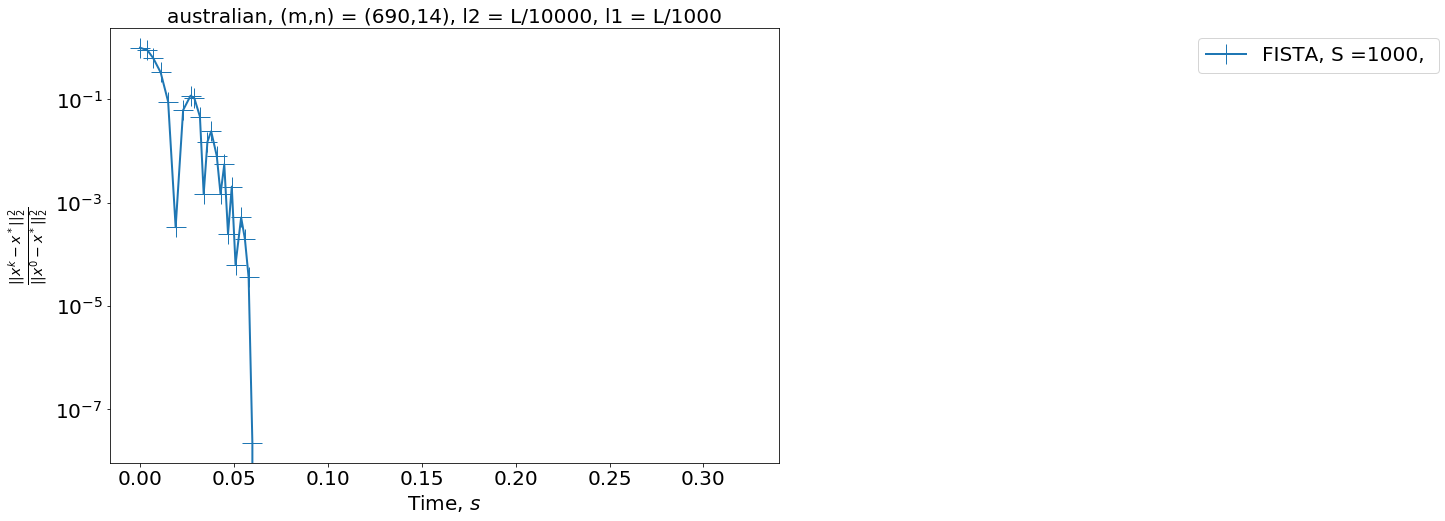

In [194]:
methods = [
         ['FISTA', [l2, l1, S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### prox-GD

In [195]:
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1500
save_info_period = 10
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

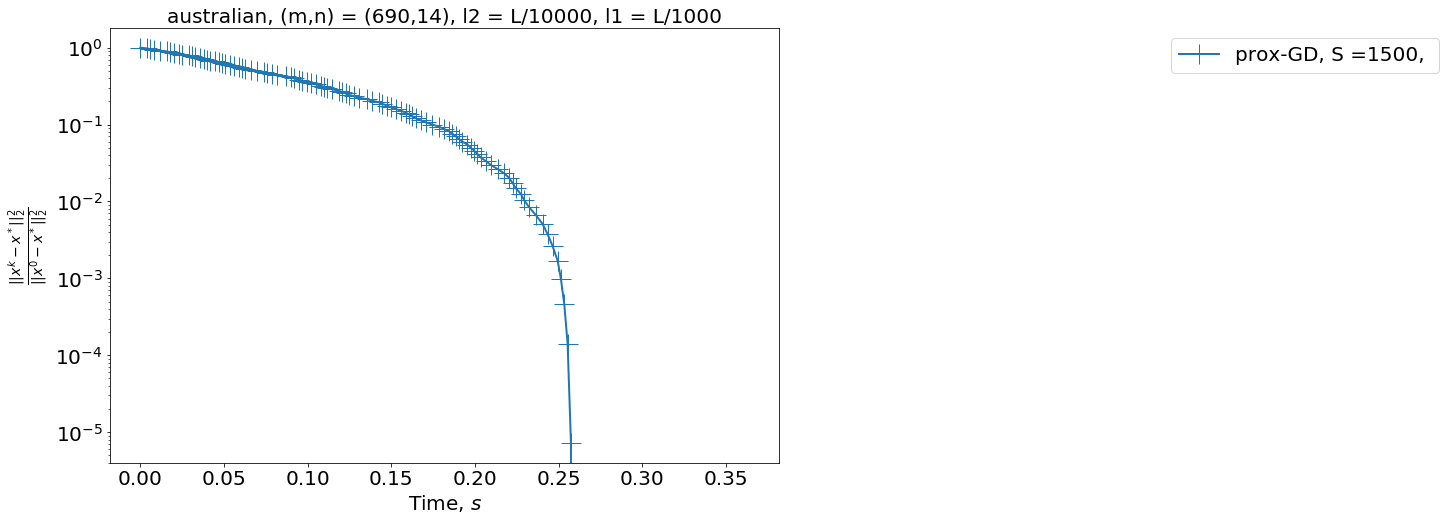

In [196]:
methods = [
         ['prox-GD', [gamma, l2, l1,S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### GD

In [199]:
for gamma_ in [0.05, 0.1, 0.5, 1]:
    l2 = L / 10000
    l1 = L / 1000
    gamma = gamma_/((L+l2))
    S = 12000
    save_info_period = 10
    sparse = False
    res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
         sparse=sparse, l1=l1, S=S, max_t=np.inf,
         save_info_period=save_info_period, 
         x_star=x_star, f_star=f_star)

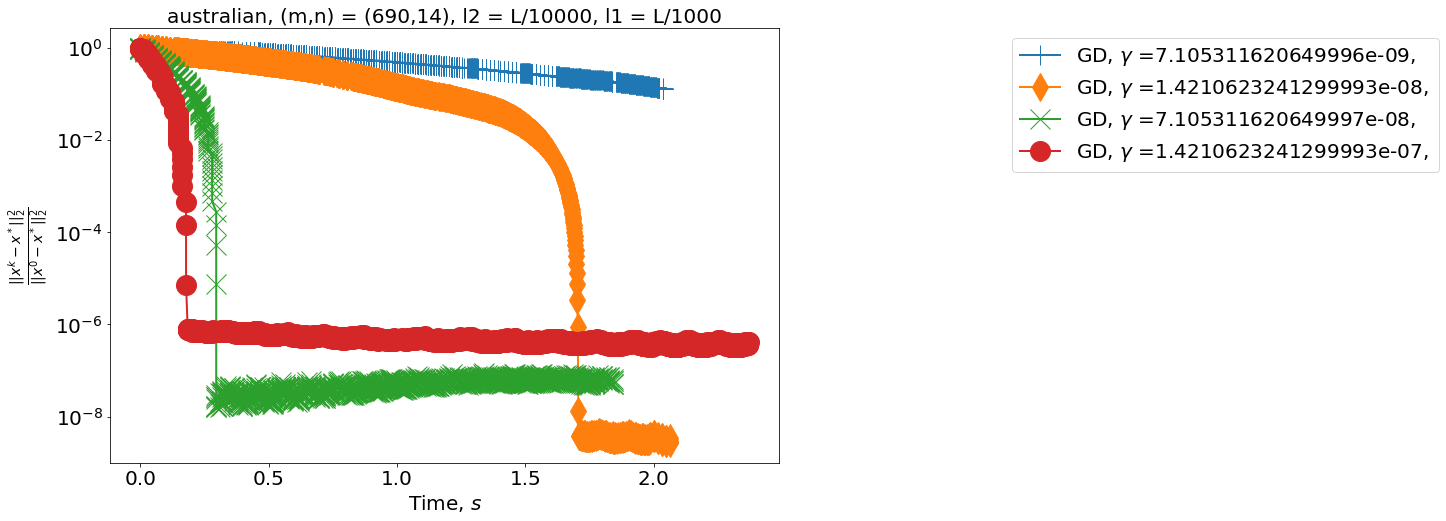

In [200]:
gamma_005 = 0.05/((L+l2))
gamma_01 = 0.1/((L+l2))
gamma_05 = 0.5/((L+l2))
gamma_1 = 1/((L+l2))

methods = [
    ['GD', [gamma_005,l2, l1, S], 
           f', $\gamma$ ={gamma_005}, ', None],
    ['GD', [gamma_01,l2, l1, S], 
           f', $\gamma$ ={gamma_01}, ', None],
    ['GD', [gamma_05,l2, l1, S], 
           f', $\gamma$ ={gamma_05}, ', None],
    ['GD', [gamma_1,l2, l1, S], 
           f', $\gamma$ ={gamma_1}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Общее сравнение

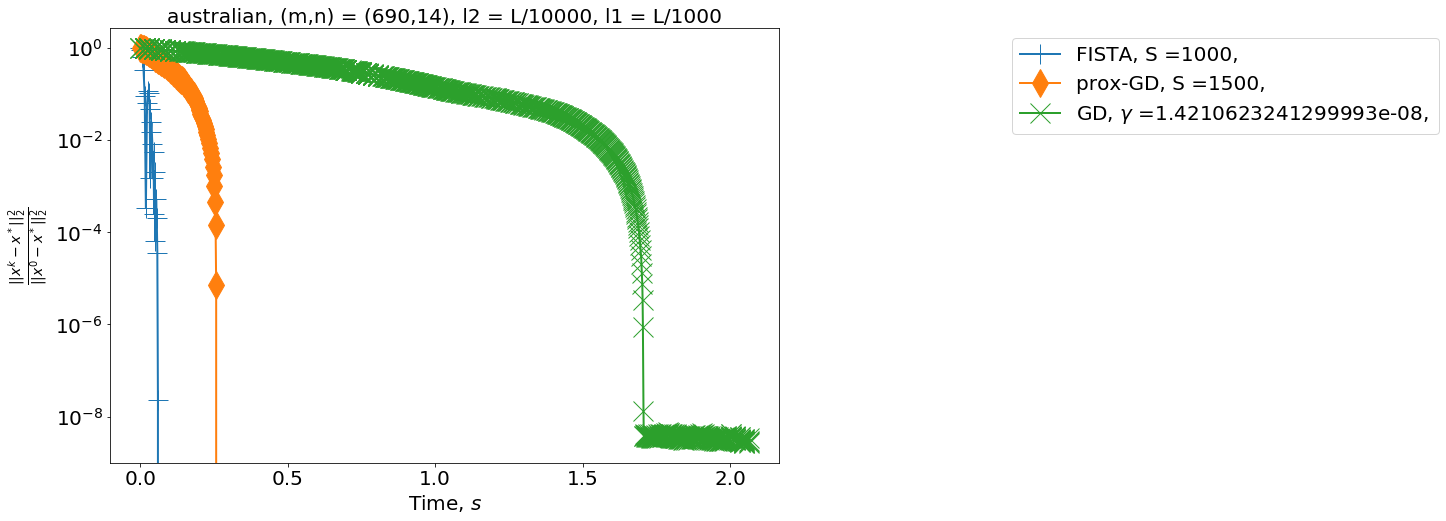

In [201]:
methods = [
        ['FISTA', [l2, l1, 1000], 
           f', S ={1000}, ', None],
        ['prox-GD', [gamma, l2, l1,1500], 
           f', S ={1500}, ', None],
        ['GD', [gamma_01,l2, l1, S], 
           f', $\gamma$ ={gamma_01}, ', None],
]

mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Сравнение методов

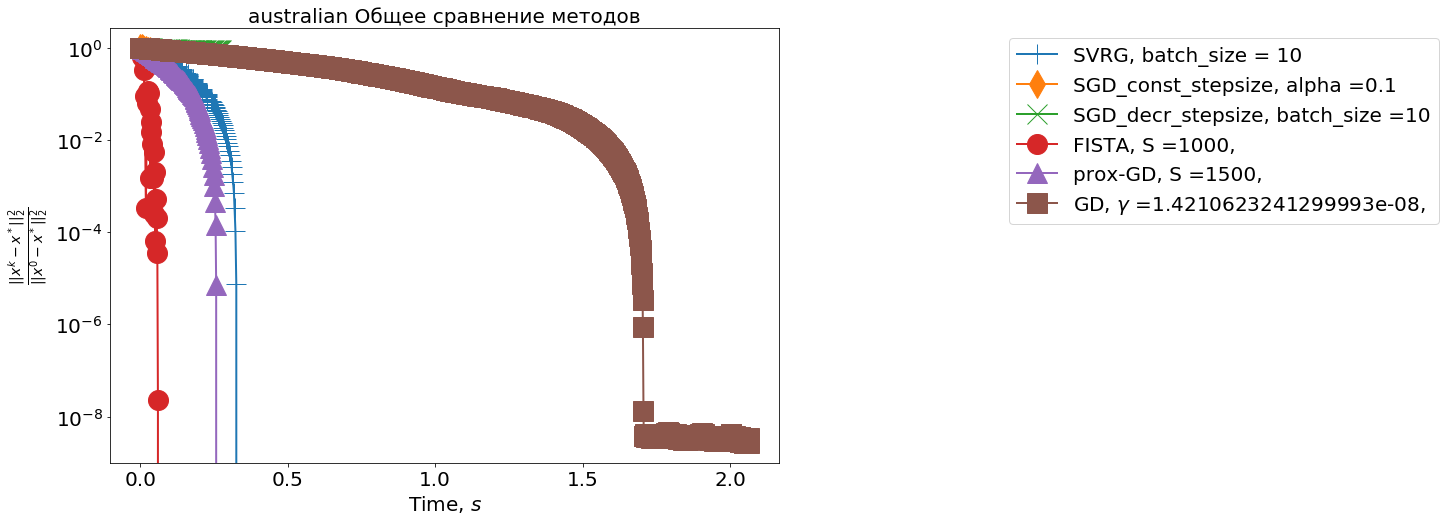

In [202]:
l2 = L / 10000
l1 = L / 1000
batch_size = 100
gamma = 1.0/(6*(L+l2))
methods = [
    ['SVRG', [1.0/(6.0*(L+l2)), L/10000, L/1000, 50, int(2*m/10), 10], 
           f', batch_size = {10}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
    
    ['SGD_const_stepsize', [0.1/((L+l2)), l2, l1, 100, 100], 
           f', alpha ={0.1} ', None], # l2 = L / 10000, l1 = L / 1000, S=100, gamma_01 = 0.1/((L+l2))
    
    ['SGD_decr_stepsize', [schedule, l2, l1, 100, 10], 
           f', batch_size ={r_10}', None], # r_10 = 10, schedule = [gamma, 10, 0.8], S=100, l2 = L / 10000, l1 = L / 1000
    
    ['FISTA', [l2, l1, 1000], 
           f', S ={1000}, ', None],
    
    ['prox-GD', [1.0/((L+l2)), l2, l1, 1500], 
       f', S ={1500}, ', None],
    
    ['GD', [gamma_01,l2, l1, 12000], 
       f', $\gamma$ ={gamma_01}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+" Общее сравнение методов"

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)

### Heart dataset

In [204]:
dataset = 'heart'
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) 
x_init = np.ones(n)

Число функций в сумме:  270 , размерность задачи:  13


In [205]:
%%time
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 500
save_info_period = 100
filename = dataset

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Найденное значение:  0.6931471805599453
Процент ненулевых координат в найденном решении:  0.0
Wall time: 1.53 s


In [206]:
# ваш код здесь
# сохранить решение x_star и f_star
save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

#### Размеры батчей SVRG

In [207]:
for r in [1, 10, 100]:
    filename=dataset
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 50
    save_info_period = 50
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

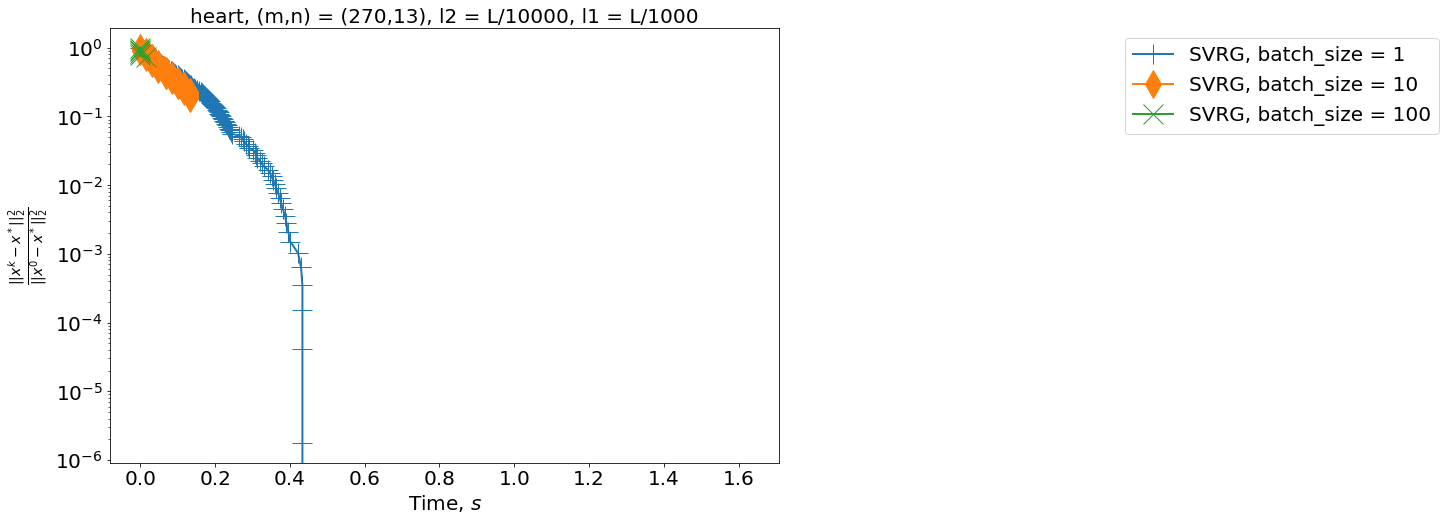

In [208]:
r_1 = 1
r_10 = 10
r_100 = 100
gamma = 1.0/(6*(L+l2))
methods = [
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_1), r_1], 
           f', batch_size = {r_1}', None],
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_10), r_10], 
           f', batch_size = {r_10}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_100), r_100], 
           f', batch_size = {r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### l2 регулизатор SVRG

In [209]:
for l2_ in[L/100000,L/10000,L/1000]:
    test_indices = None
    x_init = np.ones(n)
    l2 = l2_
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    S = 40
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

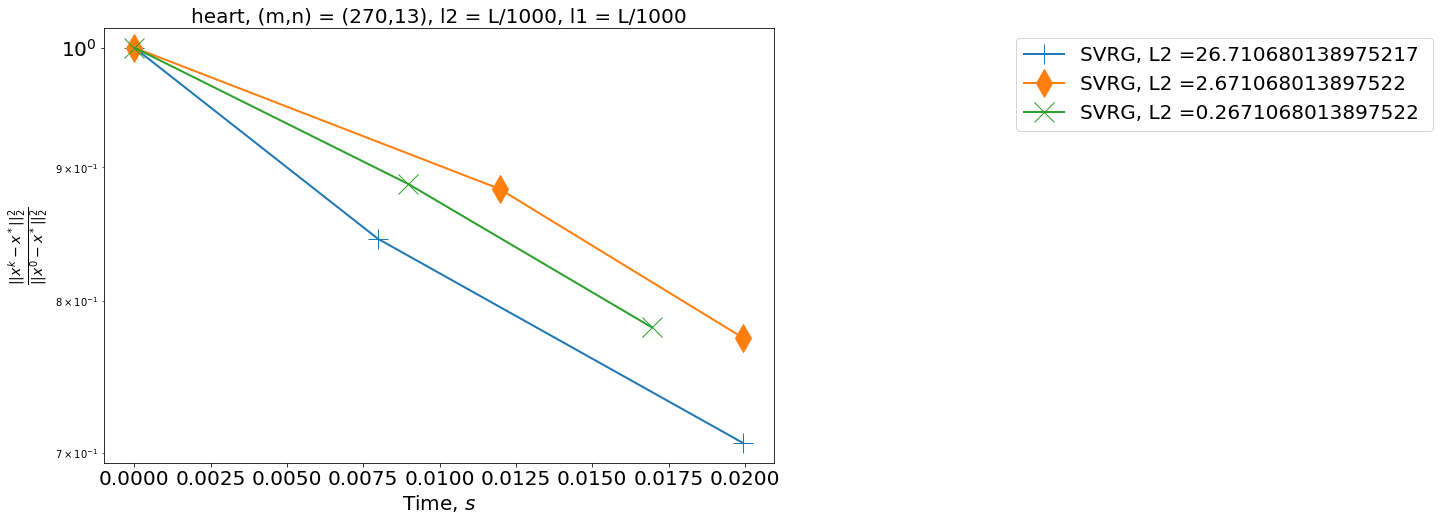

In [210]:
l2_1000 = L/1000
l2_10000 = L/10000
l2_100000 = L/100000
batch_size = 100
gamma_1000 = 1.0/(6*(L+l2_1000))
gamma_10000 = 1.0/(6*(L+l2_10000))
gamma_100000 = 1.0/(6*(L+l2_100000))
methods = [
        ['SVRG', [gamma_1000, l2_1000, l1, S, int(2*m/batch_size), 100], 
           f', L2 ={l2_1000} ', None],
        ['SVRG', [gamma_10000, l2_10000, l1, S, int(2*m/batch_size), 100], 
               f', L2 ={l2_10000} ', None],
        ['SVRG', [gamma_100000, l2_100000, l1, S, int(2*m/batch_size), 100], 
               f', L2 ={l2_100000} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Размеры шага SGD

In [211]:
for alpha in [1.0,0.1,0.01]:
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = alpha/((L+l2))
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

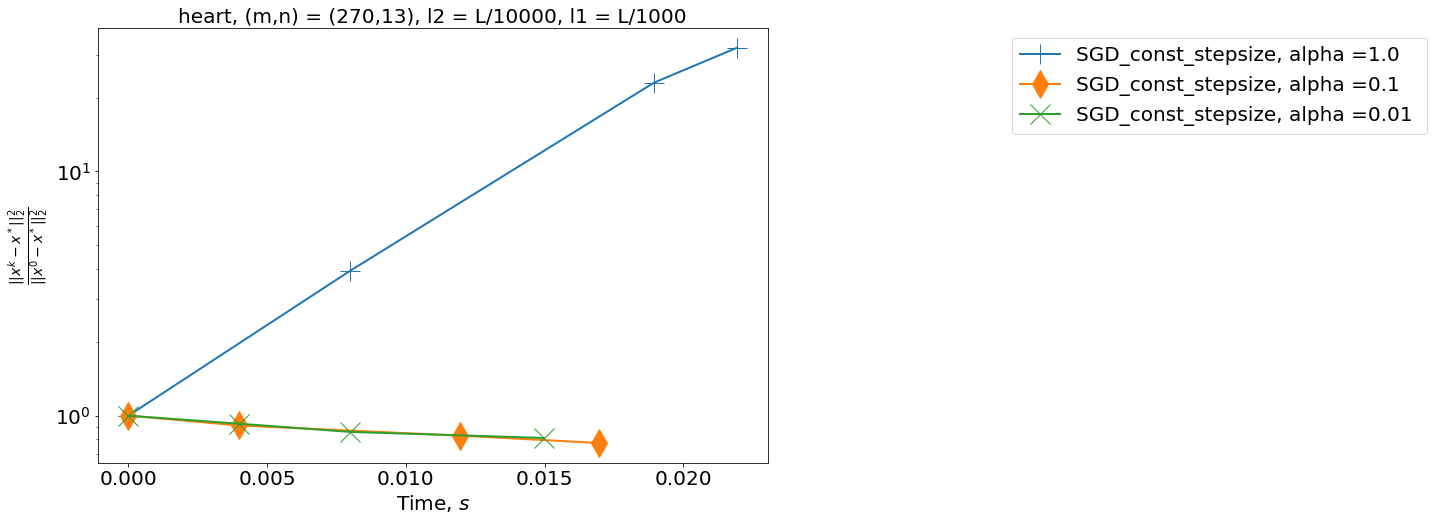

In [212]:
l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
gamma_1 = 1.0/((L+l2))
gamma_01 = 0.1/((L+l2))
gamma_001 = 0.01/((L+l2))

methods = [
        ['SGD_const_stepsize', [gamma_1, l2, l1, S, 100], 
           f', alpha ={1.0} ', None],
        ['SGD_const_stepsize', [gamma_01, l2, l1, S, 100], 
           f', alpha ={0.1} ', None], # l2 = L / 10000, l1 = L / 1000, S=100, gamma_01 = 0.1/((L+l2))
        ['SGD_const_stepsize', [gamma_001, l2, l1, S, 100], 
           f', alpha ={0.01} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

##### Разные политики выбора шага SGD

In [215]:
for schedule in [[gamma, 10, 0.8],[gamma, 10, 0.5],[gamma, 5, 0.8],[gamma, 5, 0.5]]:
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = 0.01/(6*(L+l2))
    gamma_schedule = schedule
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

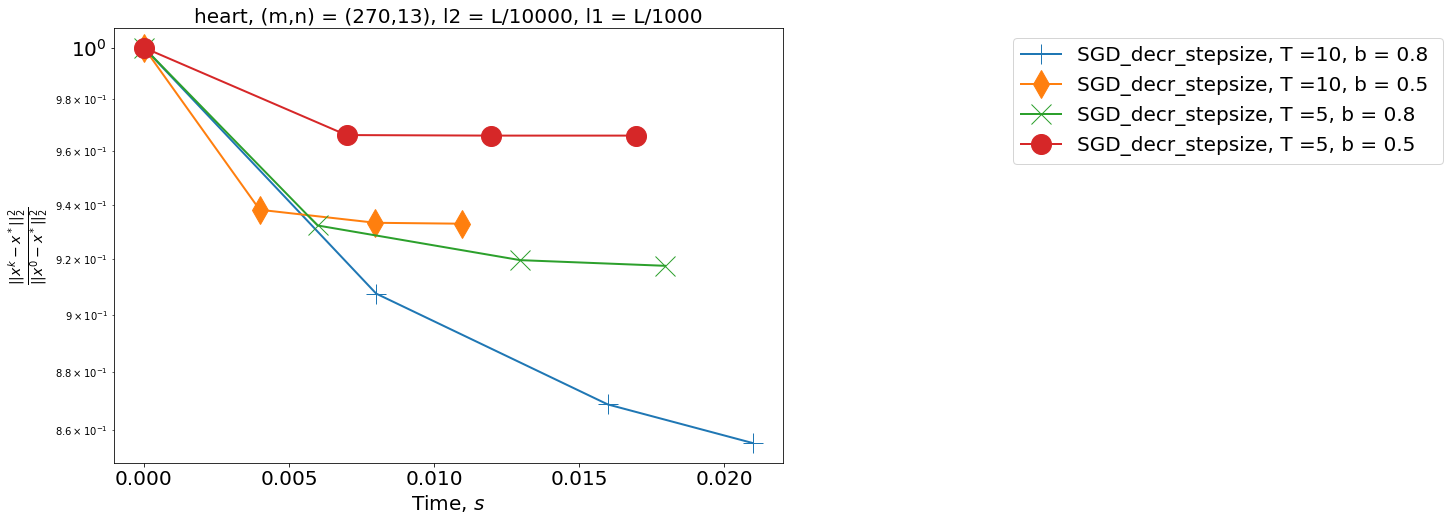

In [216]:
schedule_1 = [gamma, 10, 0.8]
schedule_2 = [gamma, 10, 0.5]
schedule_3 = [gamma, 5, 0.8]
schedule_4 = [gamma, 5, 0.5]

l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
gamma = 0.01/(6*(L+l2))
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule_1, l2, l1, S, 100], 
           f', T ={schedule_1[1]}, b = {schedule_1[2]} ', None],
        ['SGD_decr_stepsize', [schedule_2, l2, l1, S, 100], 
           f', T ={schedule_2[1]}, b = {schedule_2[2]} ', None],
        ['SGD_decr_stepsize', [schedule_3, l2, l1, S, 100], 
           f', T ={schedule_3[1]}, b = {schedule_3[2]} ', None],
        ['SGD_decr_stepsize', [schedule_4, l2, l1, S, 100], 
           f', T ={schedule_4[1]}, b = {schedule_4[2]} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

##### Разные размеры батча SGD

In [217]:
for r in [1, 10, 100]:
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = 0.01/(6*(L+l2))
    gamma_schedule = [gamma, 10, 0.8]
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

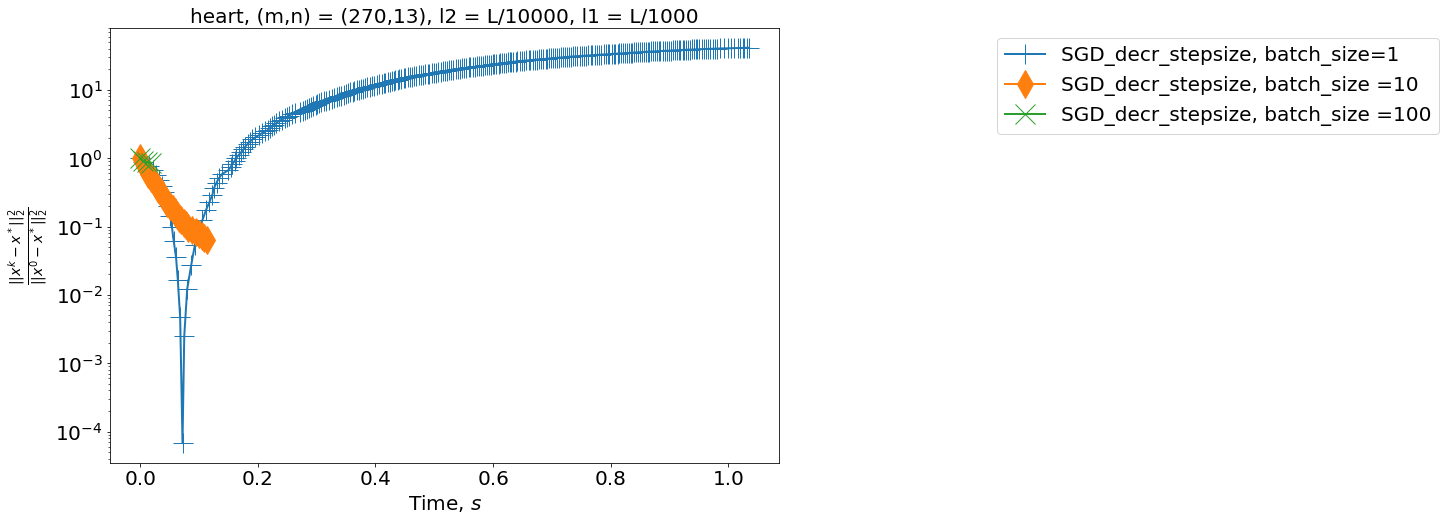

In [218]:
r_1 = 1
r_10 = 10
r_100 = 100
schedule = [gamma, 10, 0.8]

l2 = L / 10000
l1 = L / 1000
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_1], 
           f', batch_size={r_1}', None],
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_10], 
           f', batch_size ={r_10}', None], # r_10 = 10, schedule = [gamma, 10, 0.8], S=100, l2 = L / 10000, l1 = L / 1000
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_100], 
           f', batch_size ={r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

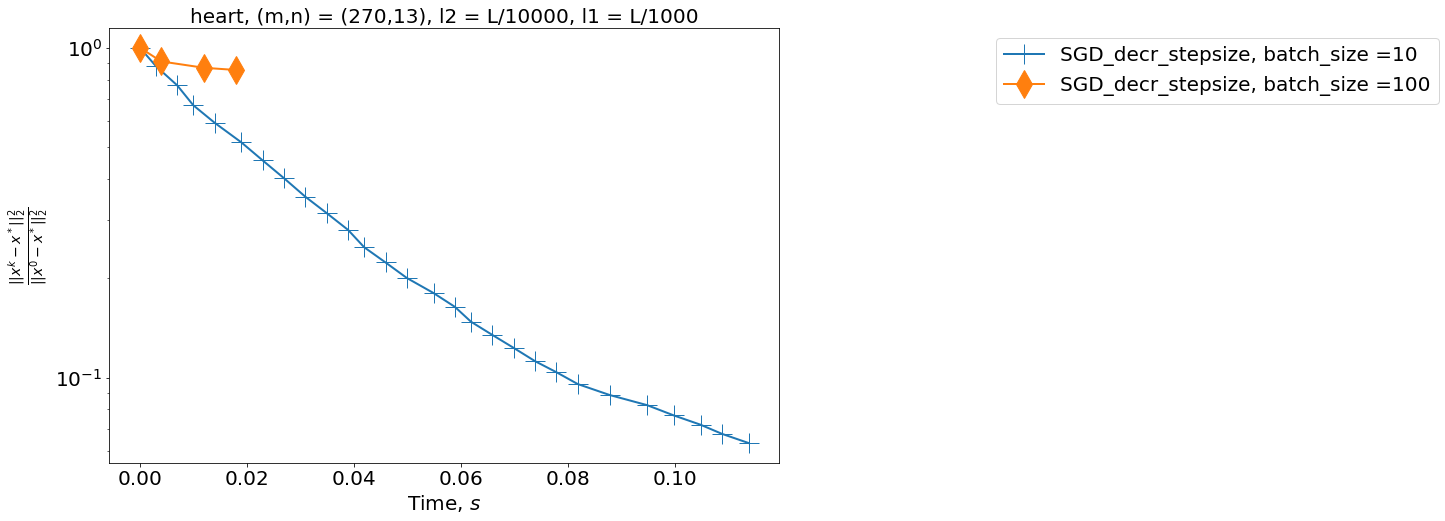

In [219]:
r_10 = 10
r_100 = 100
schedule = [gamma, 10, 0.8]

filename=dataset
l2 = L / 10000
l1 = L / 1000
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_10], 
           f', batch_size ={r_10}', None],
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_100], 
           f', batch_size ={r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### FISTA

In [220]:
l2 = L / 10000
l1 = L / 1000
x_star = None
f_star = None
S = 1000
save_info_period = 10
sparse = True
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

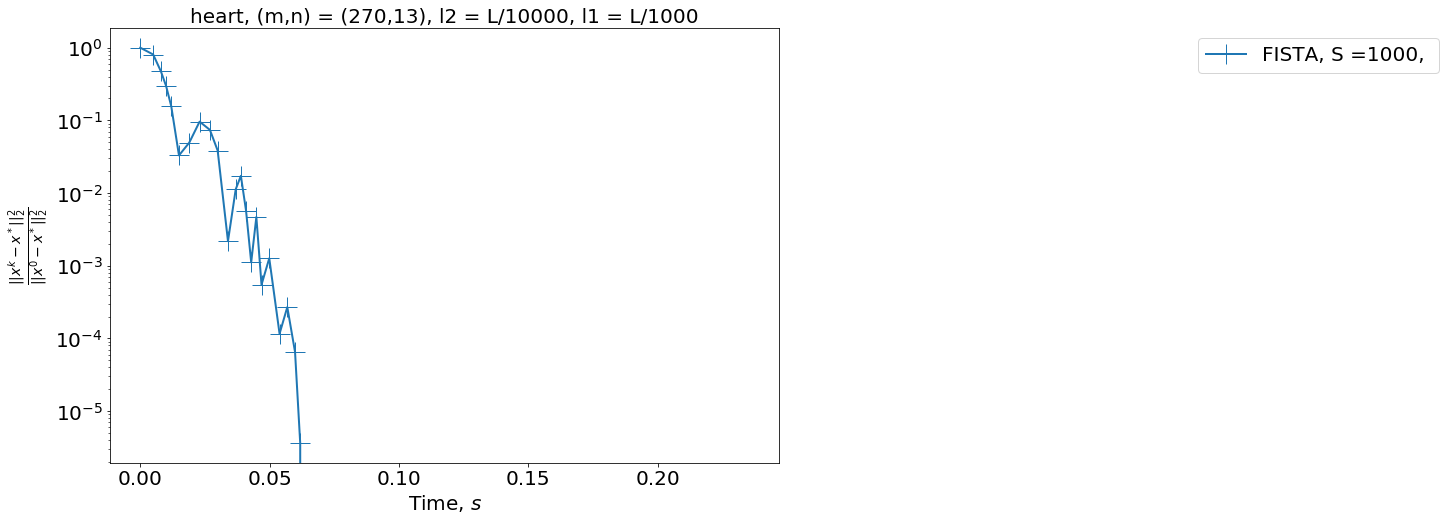

In [221]:
methods = [
         ['FISTA', [l2, l1, S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### prox-GD

In [222]:
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1500
save_info_period = 10
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

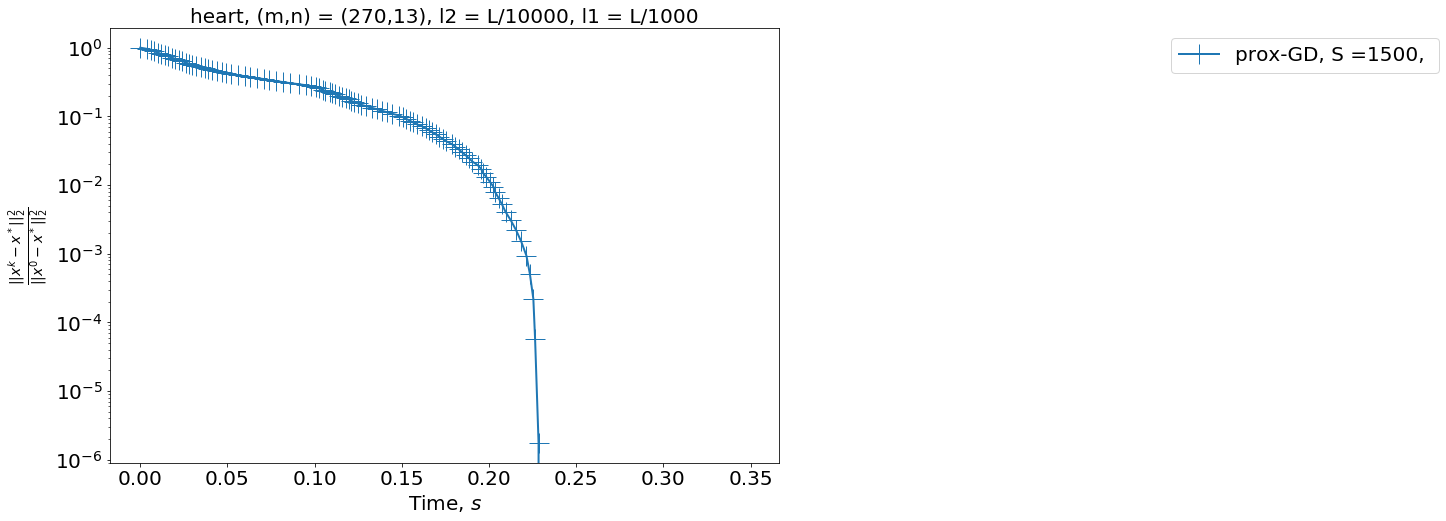

In [223]:
methods = [
         ['prox-GD', [gamma, l2, l1,S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### GD

In [224]:
for gamma_ in [0.05, 0.1, 0.5, 1]:
    l2 = L / 10000
    l1 = L / 1000
    gamma = gamma_/((L+l2))
    S = 12000
    save_info_period = 10
    sparse = False
    res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
         sparse=sparse, l1=l1, S=S, max_t=np.inf,
         save_info_period=save_info_period, 
         x_star=x_star, f_star=f_star)

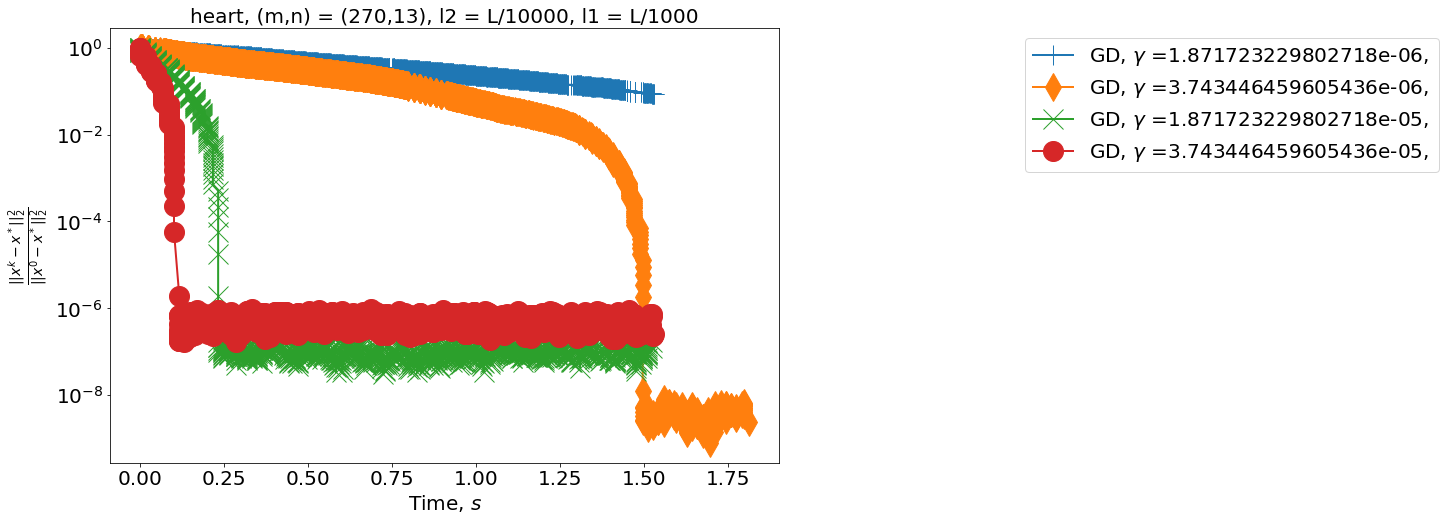

In [225]:
gamma_005 = 0.05/((L+l2))
gamma_01 = 0.1/((L+l2))
gamma_05 = 0.5/((L+l2))
gamma_1 = 1/((L+l2))

methods = [
    ['GD', [gamma_005,l2, l1, S], 
           f', $\gamma$ ={gamma_005}, ', None],
    ['GD', [gamma_01,l2, l1, S], 
           f', $\gamma$ ={gamma_01}, ', None],
    ['GD', [gamma_05,l2, l1, S], 
           f', $\gamma$ ={gamma_05}, ', None],
    ['GD', [gamma_1,l2, l1, S], 
           f', $\gamma$ ={gamma_1}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Общее сравнение

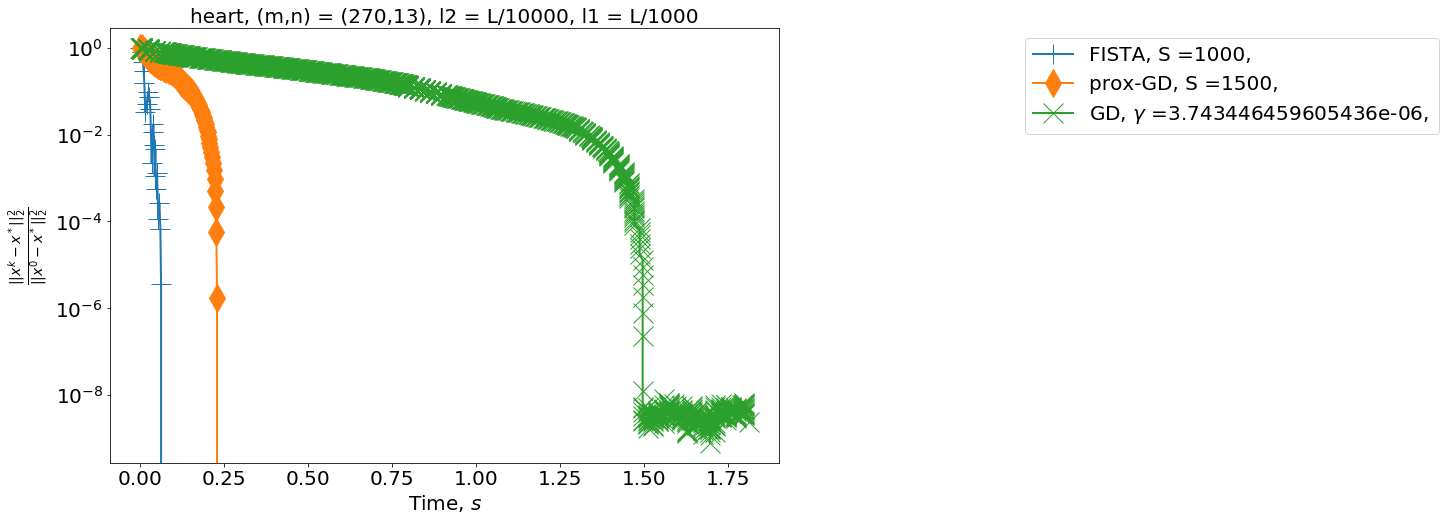

In [226]:
methods = [
        ['FISTA', [l2, l1, 1000], 
           f', S ={1000}, ', None],
        ['prox-GD', [gamma, l2, l1,1500], 
           f', S ={1500}, ', None],
        ['GD', [gamma_01,l2, l1, S], 
           f', $\gamma$ ={gamma_01}, ', None],
]

mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Сравнение методов

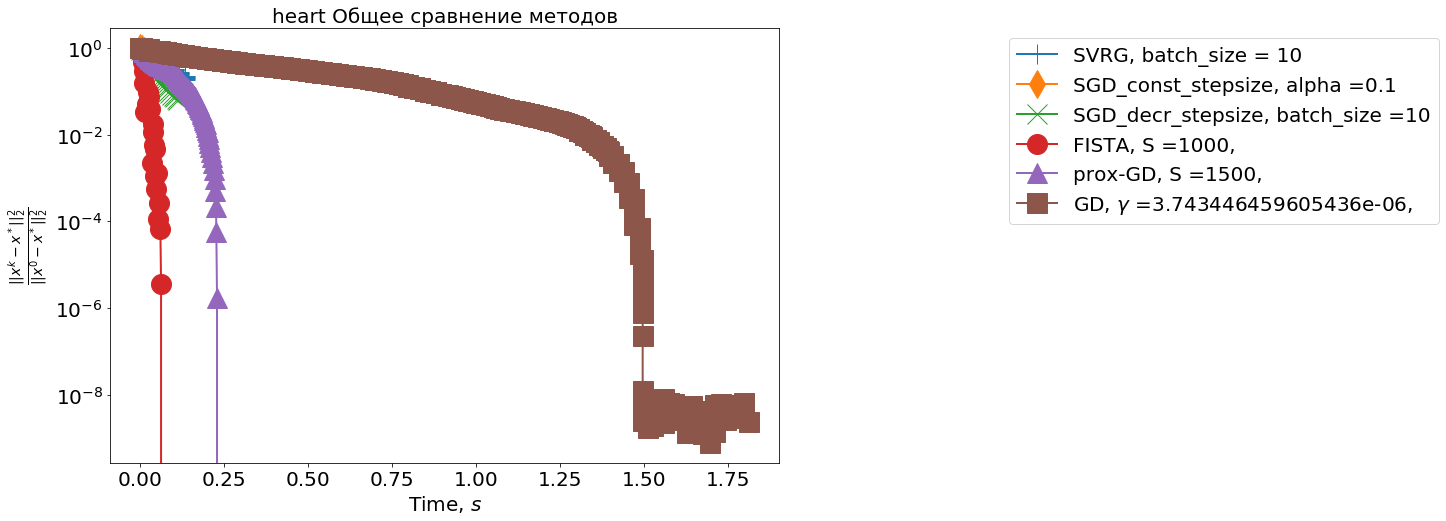

In [227]:
l2 = L / 10000
l1 = L / 1000
batch_size = 100
gamma = 1.0/(6*(L+l2))
methods = [
    ['SVRG', [1.0/(6.0*(L+l2)), L/10000, L/1000, 50, int(2*m/10), 10], 
           f', batch_size = {10}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
    
    ['SGD_const_stepsize', [0.1/((L+l2)), l2, l1, 100, 100], 
           f', alpha ={0.1} ', None], # l2 = L / 10000, l1 = L / 1000, S=100, gamma_01 = 0.1/((L+l2))
    
    ['SGD_decr_stepsize', [schedule, l2, l1, 100, 10], 
           f', batch_size ={r_10}', None], # r_10 = 10, schedule = [gamma, 10, 0.8], S=100, l2 = L / 10000, l1 = L / 1000
    
    ['FISTA', [l2, l1, 1000], 
           f', S ={1000}, ', None],
    
    ['prox-GD', [1.0/((L+l2)), l2, l1, 1500], 
       f', S ={1500}, ', None],
    
    ['GD', [gamma_01,l2, l1, 12000], 
       f', $\gamma$ ={gamma_01}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+" Общее сравнение методов"

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)

### Diabetes dataset

In [228]:
dataset = 'diabetes'
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) 
x_init = np.ones(n)

Число функций в сумме:  768 , размерность задачи:  8


In [229]:
%%time
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 500
save_info_period = 100
filename = dataset

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Найденное значение:  0.6923170714612408
Процент ненулевых координат в найденном решении:  0.125
Wall time: 3.94 s


In [230]:
# ваш код здесь
# сохранить решение x_star и f_star
save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

#### Размеры батчей SVRG

In [231]:
for r in [1, 10, 100]:
    filename=dataset
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 50
    save_info_period = 50
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

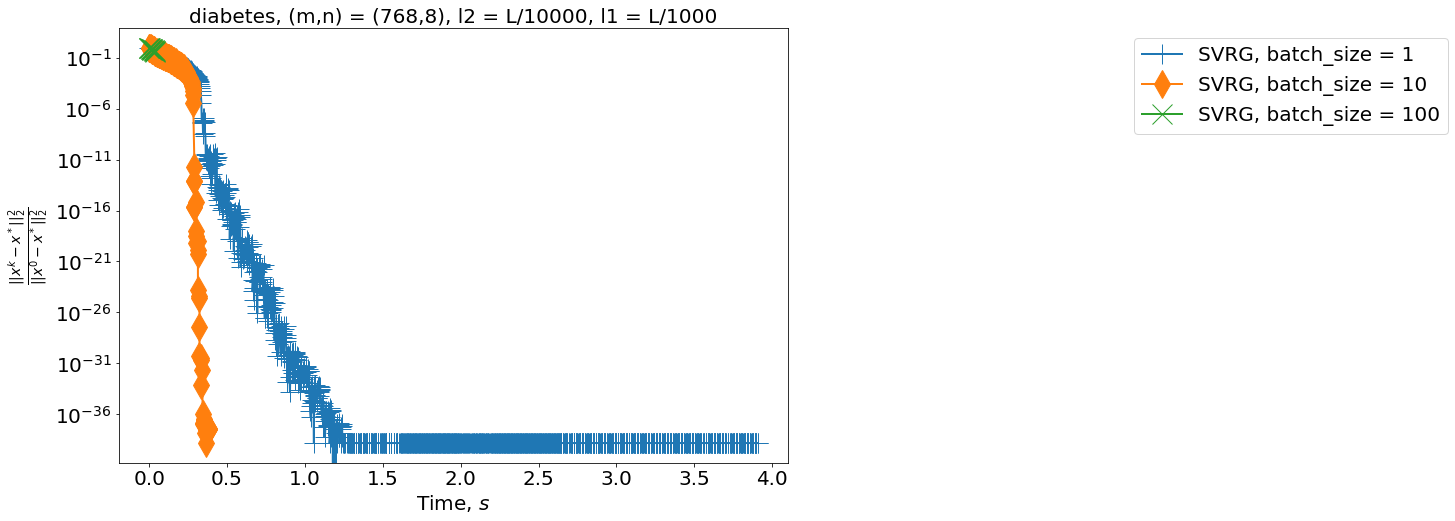

In [232]:
r_1 = 1
r_10 = 10
r_100 = 100
gamma = 1.0/(6*(L+l2))
methods = [
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_1), r_1], 
           f', batch_size = {r_1}', None],
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_10), r_10], 
           f', batch_size = {r_10}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_100), r_100], 
           f', batch_size = {r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### l2 регулизатор SVRG

In [233]:
for l2_ in[L/100000,L/10000,L/1000]:
    test_indices = None
    x_init = np.ones(n)
    l2 = l2_
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    S = 40
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

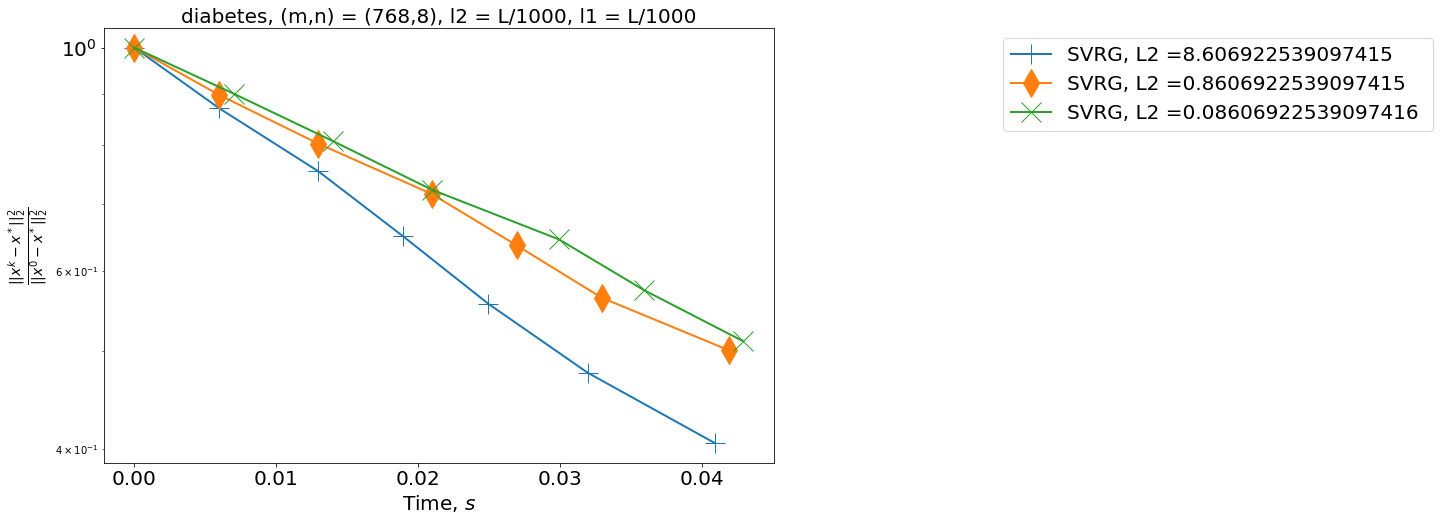

In [234]:
l2_1000 = L/1000
l2_10000 = L/10000
l2_100000 = L/100000
batch_size = 100
gamma_1000 = 1.0/(6*(L+l2_1000))
gamma_10000 = 1.0/(6*(L+l2_10000))
gamma_100000 = 1.0/(6*(L+l2_100000))
methods = [
        ['SVRG', [gamma_1000, l2_1000, l1, S, int(2*m/batch_size), 100], 
           f', L2 ={l2_1000} ', None],
        ['SVRG', [gamma_10000, l2_10000, l1, S, int(2*m/batch_size), 100], 
               f', L2 ={l2_10000} ', None],
        ['SVRG', [gamma_100000, l2_100000, l1, S, int(2*m/batch_size), 100], 
               f', L2 ={l2_100000} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Размеры шага SGD

In [235]:
for alpha in [1.0,0.1,0.01]:
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = alpha/((L+l2))
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

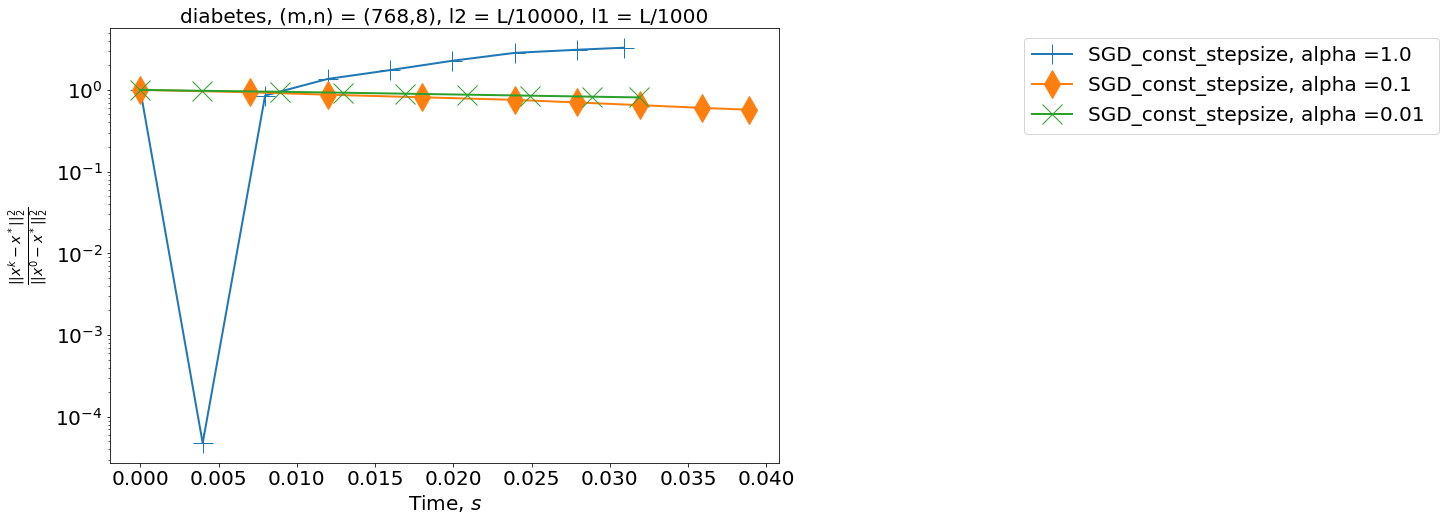

In [236]:
l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
gamma_1 = 1.0/((L+l2))
gamma_01 = 0.1/((L+l2))
gamma_001 = 0.01/((L+l2))

methods = [
        ['SGD_const_stepsize', [gamma_1, l2, l1, S, 100], 
           f', alpha ={1.0} ', None],
        ['SGD_const_stepsize', [gamma_01, l2, l1, S, 100], 
           f', alpha ={0.1} ', None], # l2 = L / 10000, l1 = L / 1000, S=100, gamma_01 = 0.1/((L+l2))
        ['SGD_const_stepsize', [gamma_001, l2, l1, S, 100], 
           f', alpha ={0.01} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

##### Разные политики выбора шага SGD

In [239]:
for schedule in [[gamma, 10, 0.8],[gamma, 10, 0.5],[gamma, 5, 0.8],[gamma, 5, 0.5]]:
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = 0.01/(6*(L+l2))
    gamma_schedule = schedule
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

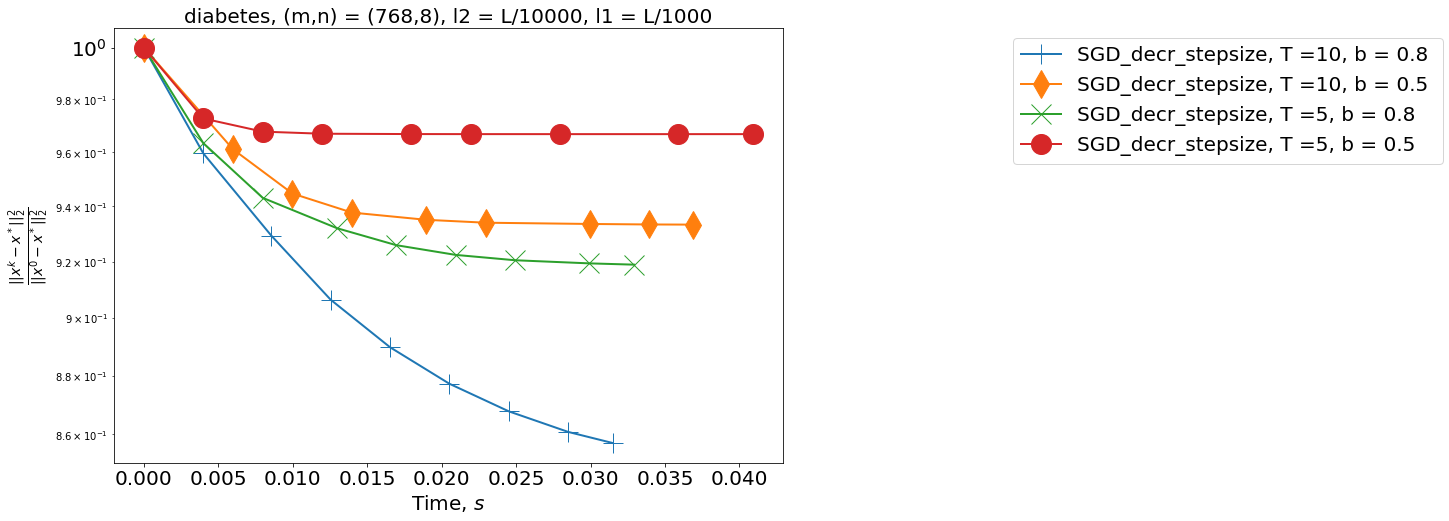

In [240]:
schedule_1 = [gamma, 10, 0.8]
schedule_2 = [gamma, 10, 0.5]
schedule_3 = [gamma, 5, 0.8]
schedule_4 = [gamma, 5, 0.5]

l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
gamma = 0.01/(6*(L+l2))
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule_1, l2, l1, S, 100], 
           f', T ={schedule_1[1]}, b = {schedule_1[2]} ', None],
        ['SGD_decr_stepsize', [schedule_2, l2, l1, S, 100], 
           f', T ={schedule_2[1]}, b = {schedule_2[2]} ', None],
        ['SGD_decr_stepsize', [schedule_3, l2, l1, S, 100], 
           f', T ={schedule_3[1]}, b = {schedule_3[2]} ', None],
        ['SGD_decr_stepsize', [schedule_4, l2, l1, S, 100], 
           f', T ={schedule_4[1]}, b = {schedule_4[2]} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

##### Разные размеры батча SGD

In [241]:
for r in [1, 10, 100]:
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = 0.01/(6*(L+l2))
    gamma_schedule = [gamma, 10, 0.8]
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 100
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

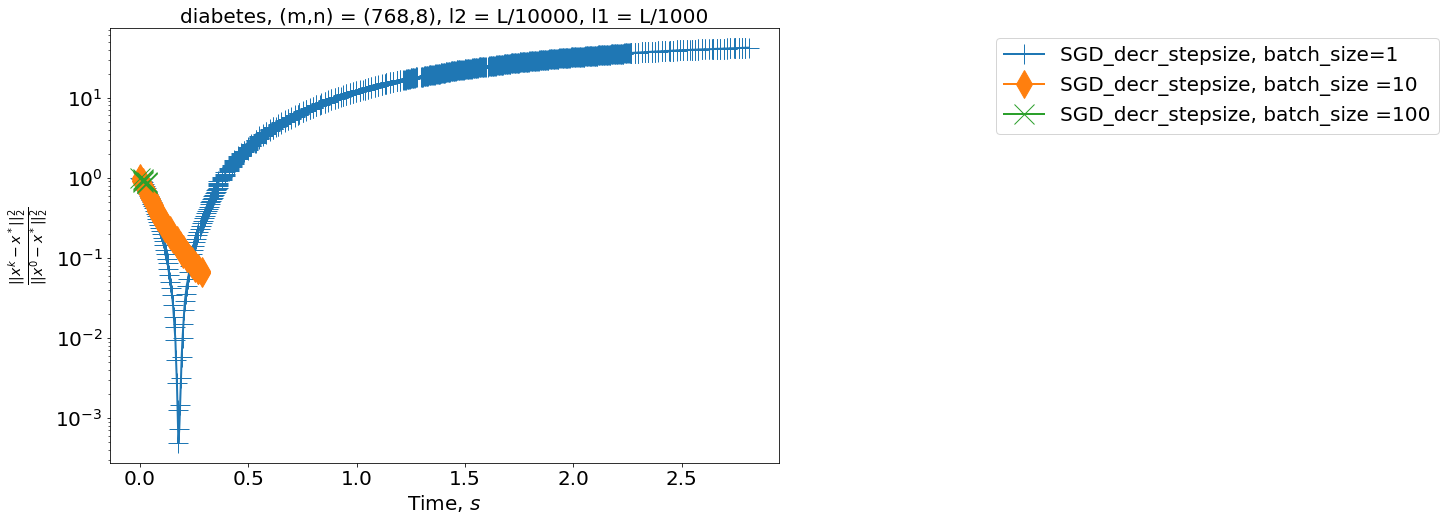

In [242]:
r_1 = 1
r_10 = 10
r_100 = 100
schedule = [gamma, 10, 0.8]

l2 = L / 10000
l1 = L / 1000
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_1], 
           f', batch_size={r_1}', None],
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_10], 
           f', batch_size ={r_10}', None], # r_10 = 10, schedule = [gamma, 10, 0.8], S=100, l2 = L / 10000, l1 = L / 1000
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_100], 
           f', batch_size ={r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

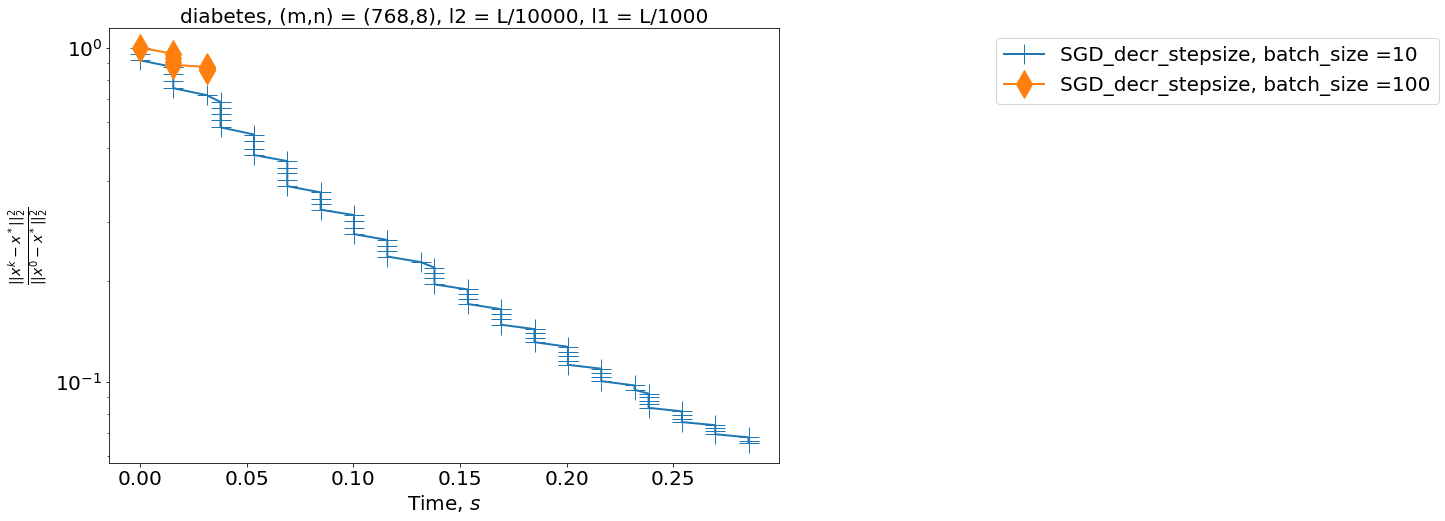

In [243]:
r_10 = 10
r_100 = 100
schedule = [gamma, 10, 0.8]

filename=dataset
l2 = L / 10000
l1 = L / 1000
S = 100
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_10], 
           f', batch_size ={r_10}', None],
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_100], 
           f', batch_size ={r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### FISTA

In [244]:
l2 = L / 10000
l1 = L / 1000
x_star = None
f_star = None
S = 1000
save_info_period = 10
sparse = True
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

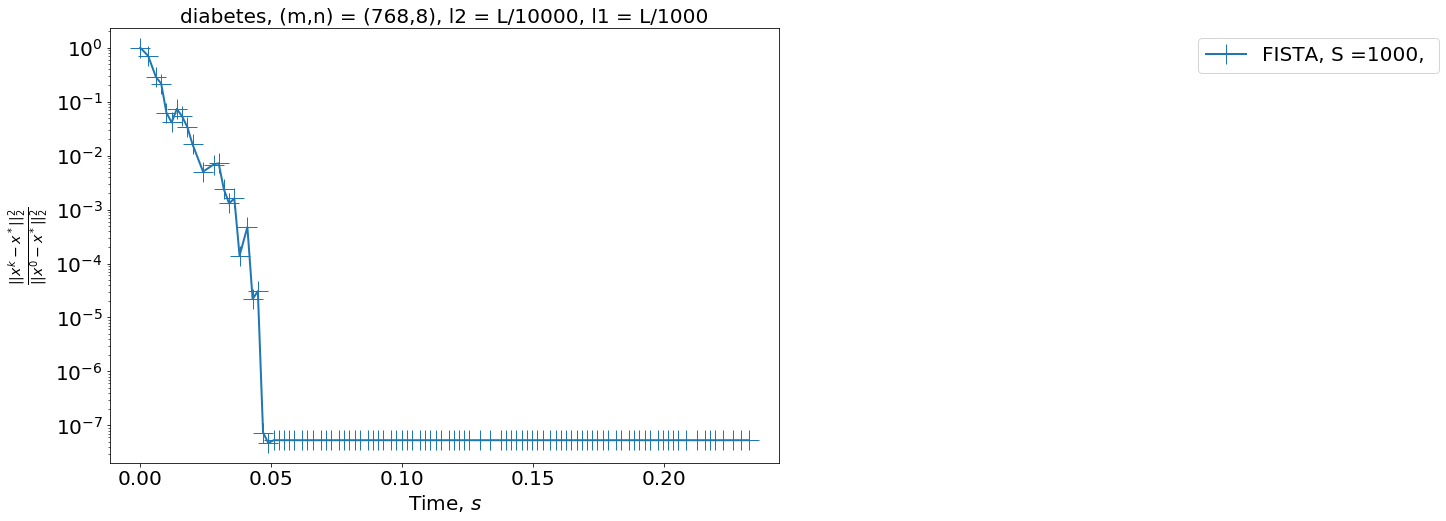

In [245]:
methods = [
         ['FISTA', [l2, l1, S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### prox-GD

In [246]:
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 1500
save_info_period = 10
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

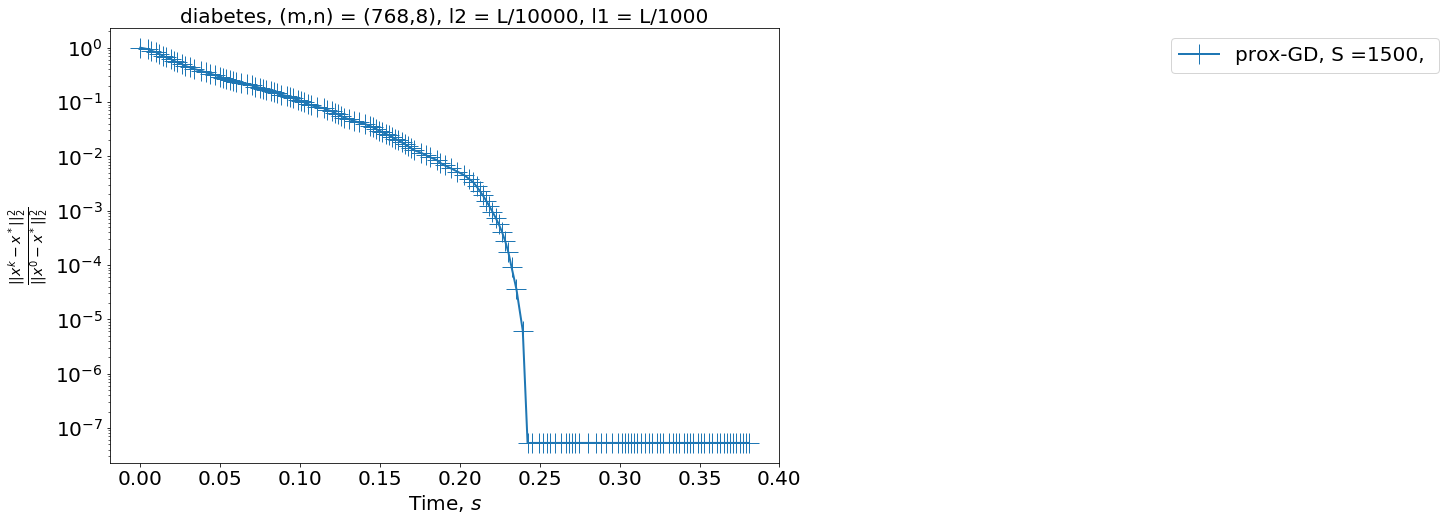

In [247]:
methods = [
         ['prox-GD', [gamma, l2, l1,S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### GD

In [248]:
for gamma_ in [0.05, 0.1, 0.5, 1]:
    l2 = L / 10000
    l1 = L / 1000
    gamma = gamma_/((L+l2))
    S = 12000
    save_info_period = 10
    sparse = False
    res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
         sparse=sparse, l1=l1, S=S, max_t=np.inf,
         save_info_period=save_info_period, 
         x_star=x_star, f_star=f_star)

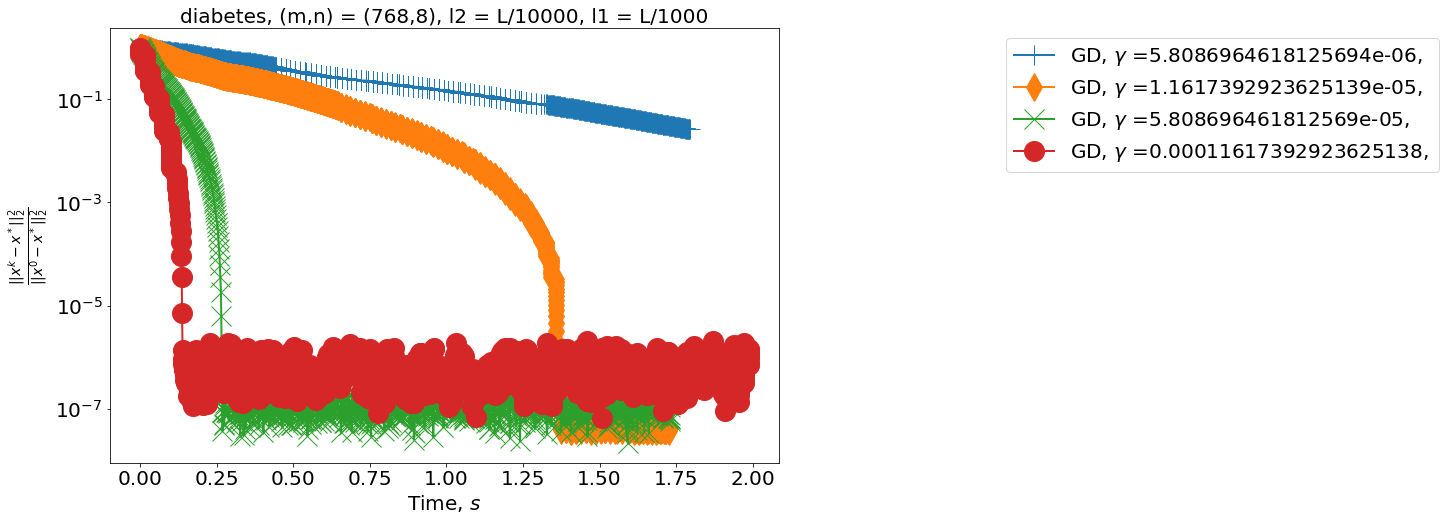

In [249]:
gamma_005 = 0.05/((L+l2))
gamma_01 = 0.1/((L+l2))
gamma_05 = 0.5/((L+l2))
gamma_1 = 1/((L+l2))

methods = [
    ['GD', [gamma_005,l2, l1, S], 
           f', $\gamma$ ={gamma_005}, ', None],
    ['GD', [gamma_01,l2, l1, S], 
           f', $\gamma$ ={gamma_01}, ', None],
    ['GD', [gamma_05,l2, l1, S], 
           f', $\gamma$ ={gamma_05}, ', None],
    ['GD', [gamma_1,l2, l1, S], 
           f', $\gamma$ ={gamma_1}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Общее сравнение

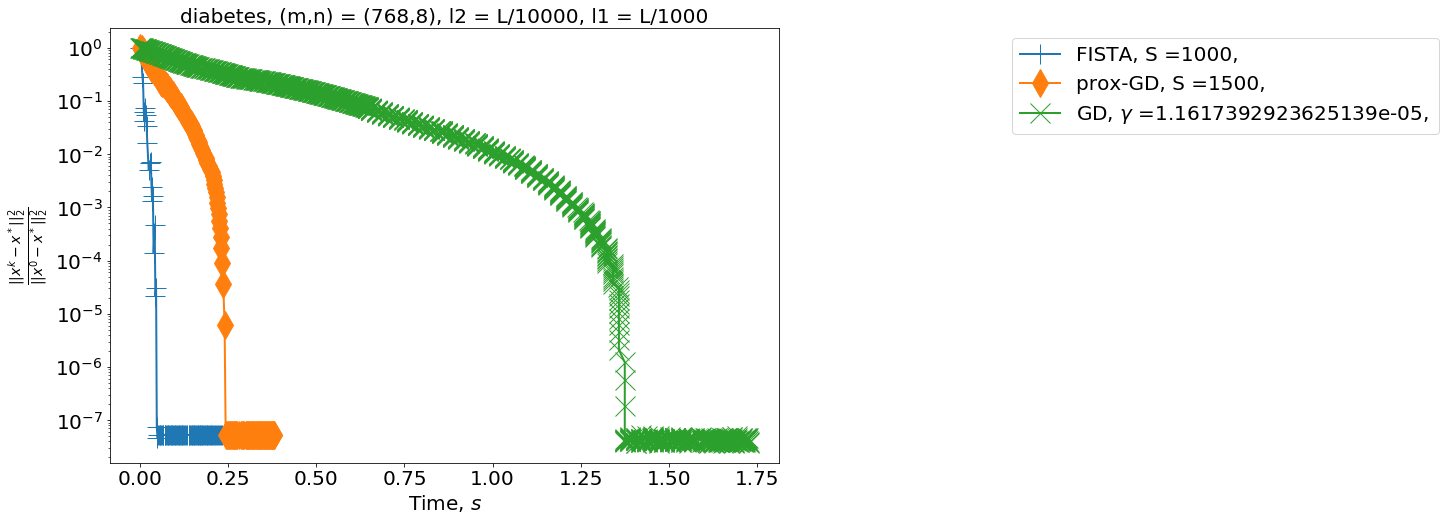

In [250]:
methods = [
        ['FISTA', [l2, l1, 1000], 
           f', S ={1000}, ', None],
        ['prox-GD', [gamma, l2, l1,1500], 
           f', S ={1500}, ', None],
        ['GD', [gamma_01,l2, l1, S], 
           f', $\gamma$ ={gamma_01}, ', None],
]

mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Сравнение методов

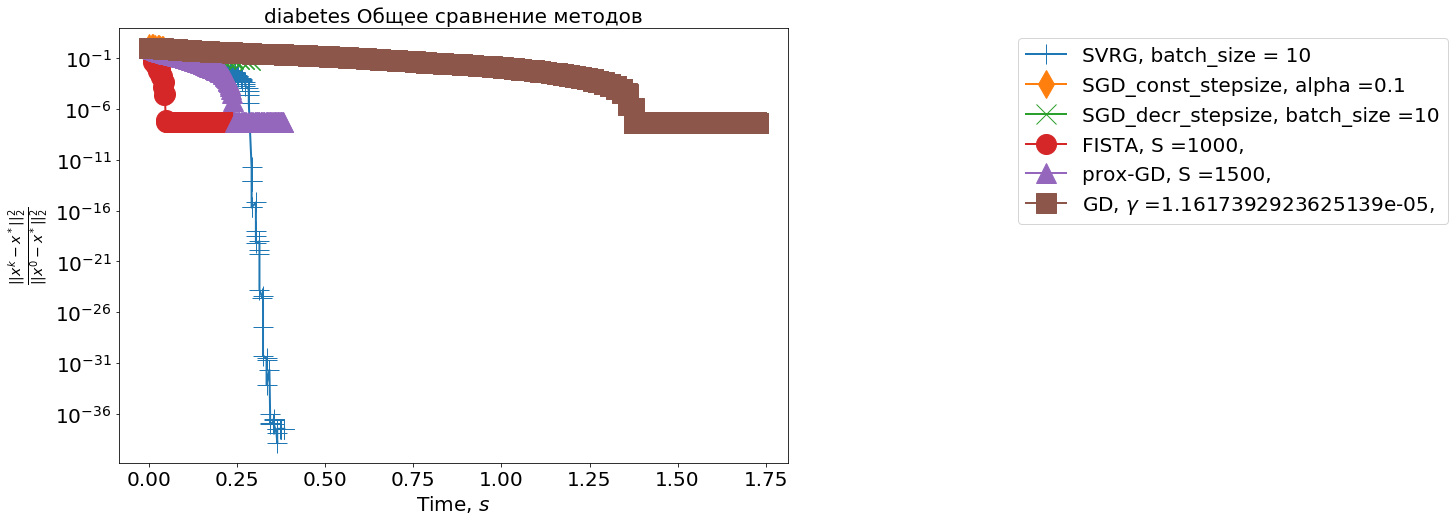

In [251]:
l2 = L / 10000
l1 = L / 1000
batch_size = 100
gamma = 1.0/(6*(L+l2))
methods = [
    ['SVRG', [1.0/(6.0*(L+l2)), L/10000, L/1000, 50, int(2*m/10), 10], 
           f', batch_size = {10}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
    
    ['SGD_const_stepsize', [0.1/((L+l2)), l2, l1, 100, 100], 
           f', alpha ={0.1} ', None], # l2 = L / 10000, l1 = L / 1000, S=100, gamma_01 = 0.1/((L+l2))
    
    ['SGD_decr_stepsize', [schedule, l2, l1, 100, 10], 
           f', batch_size ={r_10}', None], # r_10 = 10, schedule = [gamma, 10, 0.8], S=100, l2 = L / 10000, l1 = L / 1000
    
    ['FISTA', [l2, l1, 1000], 
           f', S ={1000}, ', None],
    
    ['prox-GD', [1.0/((L+l2)), l2, l1, 1500], 
       f', S ={1500}, ', None],
    
    ['GD', [gamma_01,l2, l1, 12000], 
       f', $\gamma$ ={gamma_01}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+" Общее сравнение методов"

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)

### Gisette dataset

In [253]:
dataset = 'gisette'
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Число функций в сумме: ", m, ", размерность задачи: ", n)
L, average_L, worst_L = compute_L(dataset, A) 
x_init = np.ones(n)

Число функций в сумме:  6000 , размерность задачи:  5000


In [254]:
%%time
l2 = L / 10000
l1 = L / 1000
batch_size = 10
M = int(2*m/batch_size)
gamma = 1.0/(6*(L+l2))
x_star = None
f_star = None
S = 500
save_info_period = 100
filename = dataset

#эти 2 параметра выставите в соответствии с вашими экспериментами по разреженности матрицы
sparse_full = False
sparse_stoch = False

res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
print("Найденное значение: ", res['func_vals'][-1])
print("Процент ненулевых координат в найденном решении: ", np.count_nonzero(res['last_iter'])/n)

Найденное значение:  0.6931471805599454
Процент ненулевых координат в найденном решении:  0.0
Wall time: 11min 16s


In [255]:
# ваш код здесь
# сохранить решение x_star и f_star
save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

#### Размеры батчей SVRG

In [256]:
for r in [1, 10, 100]:
    filename=dataset
    test_indices = None
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    x_star = read_solution(dataset, l2, l1)[0]
    f_star = read_solution(dataset, l2, l1)[1]
    S = 10
    save_info_period = 50
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

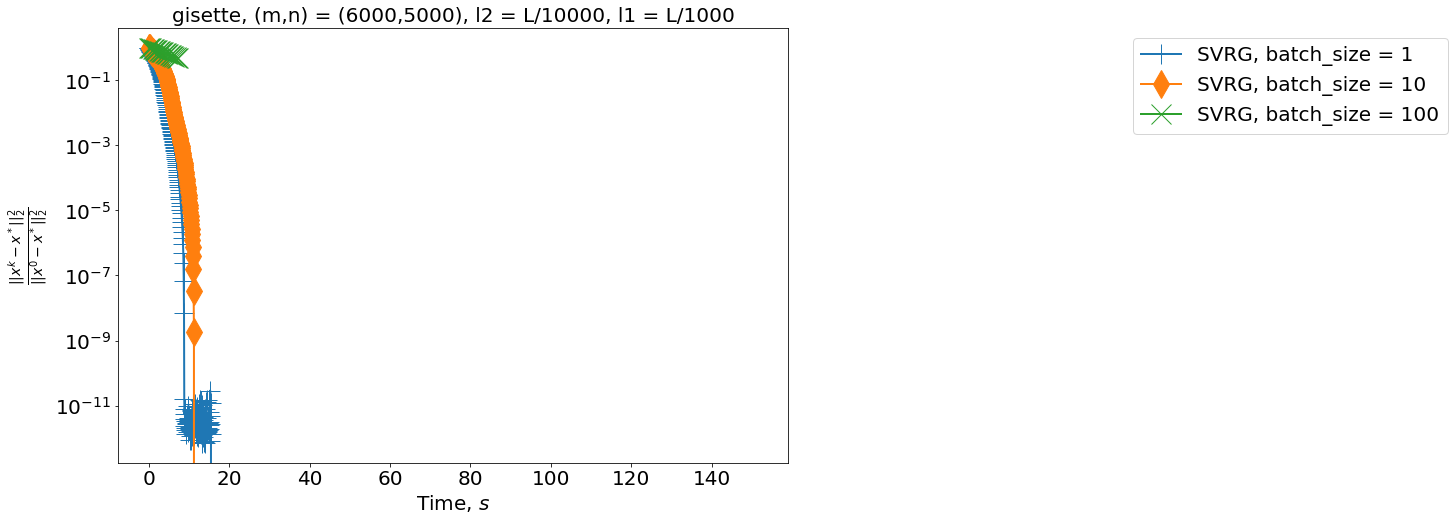

In [257]:
r_1 = 1
r_10 = 10
r_100 = 100
gamma = 1.0/(6*(L+l2))
methods = [
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_1), r_1], 
           f', batch_size = {r_1}', None],
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_10), r_10], 
           f', batch_size = {r_10}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
        ['SVRG', [gamma, l2, l1, S, int(2*m/r_100), r_100], 
           f', batch_size = {r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### l2 регулизатор SVRG

In [258]:
for l2_ in[L/100000,L/10000,L/1000]:
    test_indices = None
    x_init = np.ones(n)
    l2 = l2_
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = 1.0/(6*(L+l2))
    S = 5
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, M=M, max_t=np.inf,
     batch_size=batch_size, indices=None, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

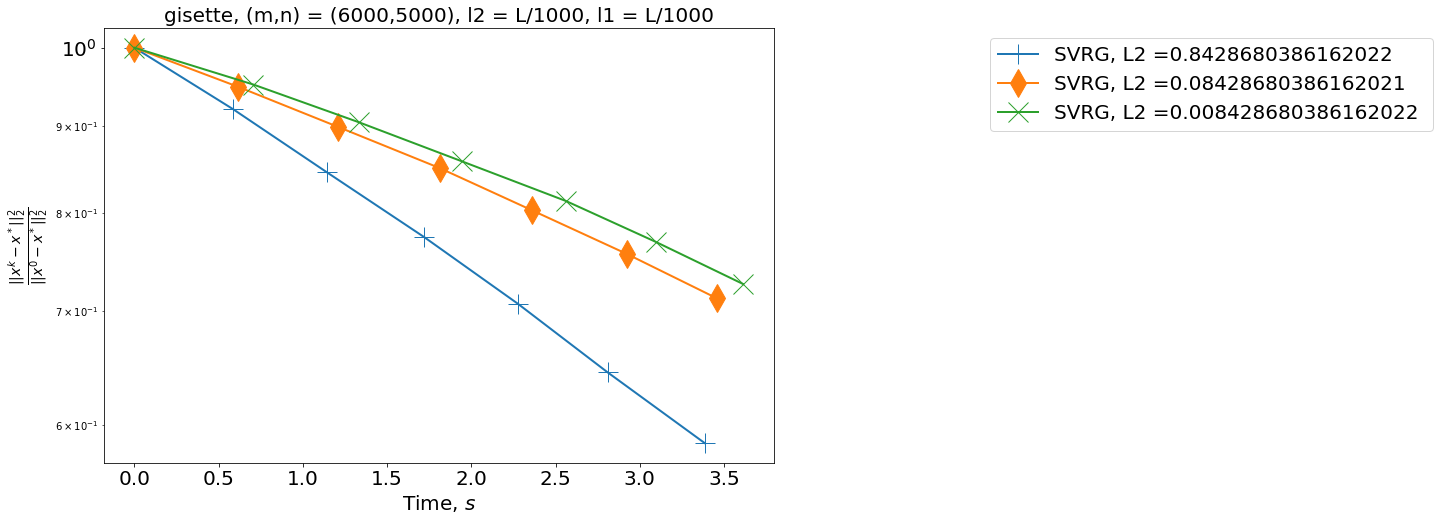

In [259]:
l2_1000 = L/1000
l2_10000 = L/10000
l2_100000 = L/100000
batch_size = 100
gamma_1000 = 1.0/(6*(L+l2_1000))
gamma_10000 = 1.0/(6*(L+l2_10000))
gamma_100000 = 1.0/(6*(L+l2_100000))
methods = [
        ['SVRG', [gamma_1000, l2_1000, l1, S, int(2*m/batch_size), 100], 
           f', L2 ={l2_1000} ', None],
        ['SVRG', [gamma_10000, l2_10000, l1, S, int(2*m/batch_size), 100], 
               f', L2 ={l2_10000} ', None],
        ['SVRG', [gamma_100000, l2_100000, l1, S, int(2*m/batch_size), 100], 
               f', L2 ={l2_100000} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Размеры шага SGD

In [260]:
for alpha in [1.0,0.1,0.01]:
    x_init = np.ones(n)
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = alpha/((L+l2))
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 5
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)
    save_solution(dataset, l2, l1, res['last_iter'], res['func_vals'][-1])

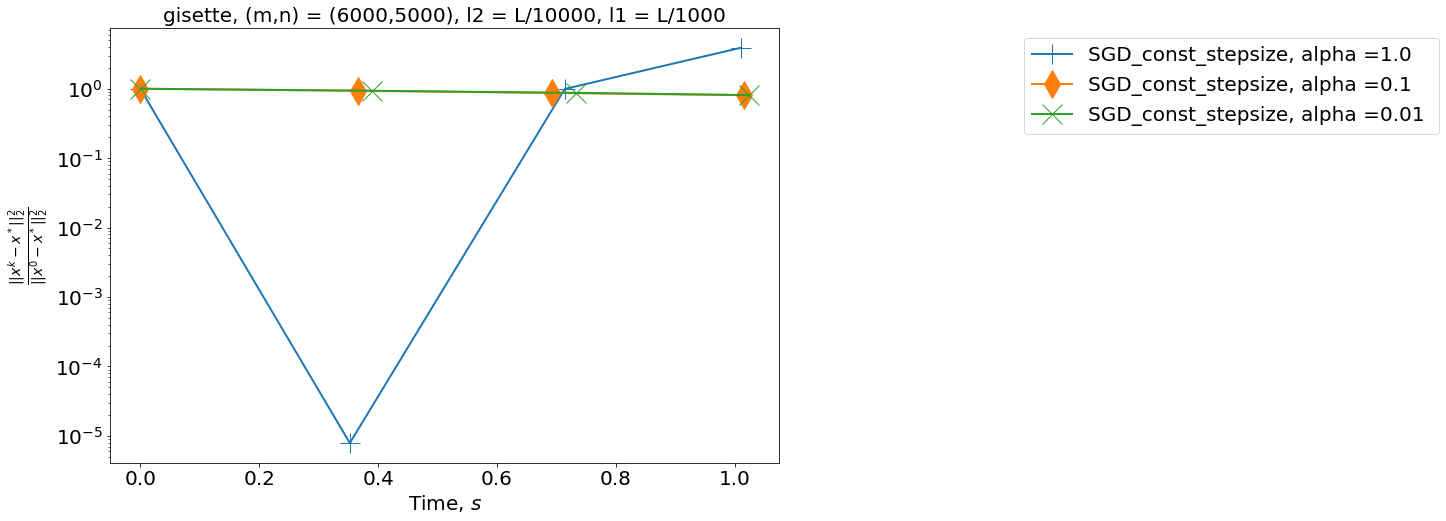

In [261]:
l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
gamma_1 = 1.0/((L+l2))
gamma_01 = 0.1/((L+l2))
gamma_001 = 0.01/((L+l2))

methods = [
        ['SGD_const_stepsize', [gamma_1, l2, l1, S, 100], 
           f', alpha ={1.0} ', None],
        ['SGD_const_stepsize', [gamma_01, l2, l1, S, 100], 
           f', alpha ={0.1} ', None], # l2 = L / 10000, l1 = L / 1000, S=100, gamma_01 = 0.1/((L+l2))
        ['SGD_const_stepsize', [gamma_001, l2, l1, S, 100], 
           f', alpha ={0.01} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

##### Разные политики выбора шага SGD

In [265]:
for schedule in [[gamma, 10, 0.8],[gamma, 10, 0.5],[gamma, 5, 0.8],[gamma, 5, 0.5]]:
    l2 = L / 10000
    l1 = L / 1000
    batch_size = 100
    M = int(2*m/batch_size)
    gamma = 0.01/(6*(L+l2))
    gamma_schedule = schedule
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 5
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

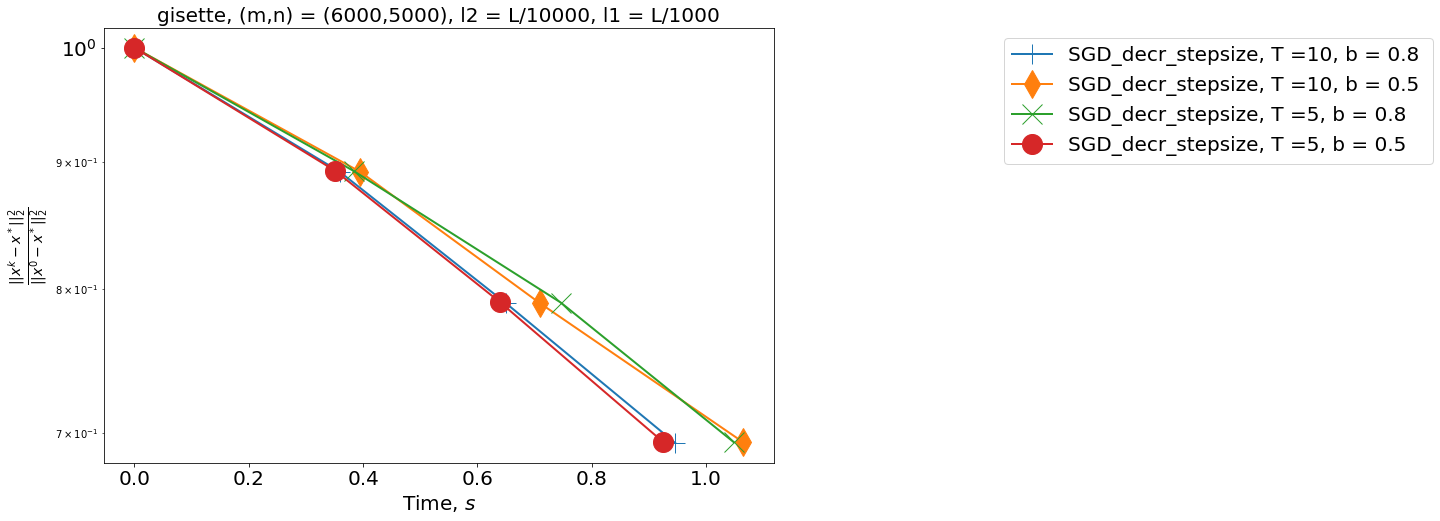

In [266]:
schedule_1 = [gamma, 10, 0.8]
schedule_2 = [gamma, 10, 0.5]
schedule_3 = [gamma, 5, 0.8]
schedule_4 = [gamma, 5, 0.5]

l2 = L / 10000
l1 = L / 1000
batch_size = 100
M = int(2*m/batch_size)
gamma = 0.01/(6*(L+l2))
S = 5
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule_1, l2, l1, S, 100], 
           f', T ={schedule_1[1]}, b = {schedule_1[2]} ', None],
        ['SGD_decr_stepsize', [schedule_2, l2, l1, S, 100], 
           f', T ={schedule_2[1]}, b = {schedule_2[2]} ', None],
        ['SGD_decr_stepsize', [schedule_3, l2, l1, S, 100], 
           f', T ={schedule_3[1]}, b = {schedule_3[2]} ', None],
        ['SGD_decr_stepsize', [schedule_4, l2, l1, S, 100], 
           f', T ={schedule_4[1]}, b = {schedule_4[2]} ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

##### Разные размеры батча SGD

In [267]:
for r in [1, 10, 100]:
    l2 = L / 10000
    l1 = L / 1000
    batch_size = r
    M = int(2*m/batch_size)
    gamma = 0.01/(6*(L+l2))
    gamma_schedule = [gamma, 10, 0.8]
    x_star = read_solution(dataset, l2,l1)[0]
    f_star = read_solution(dataset, l2,l1)[1]
    S = 5
    save_info_period = 100
    sparse_full = False
    sparse_stoch = False
    res = sgd_decr_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma_schedule=gamma_schedule, l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     l1=l1, S=S, max_t=np.inf,
     batch_size=batch_size, indices=test_indices, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

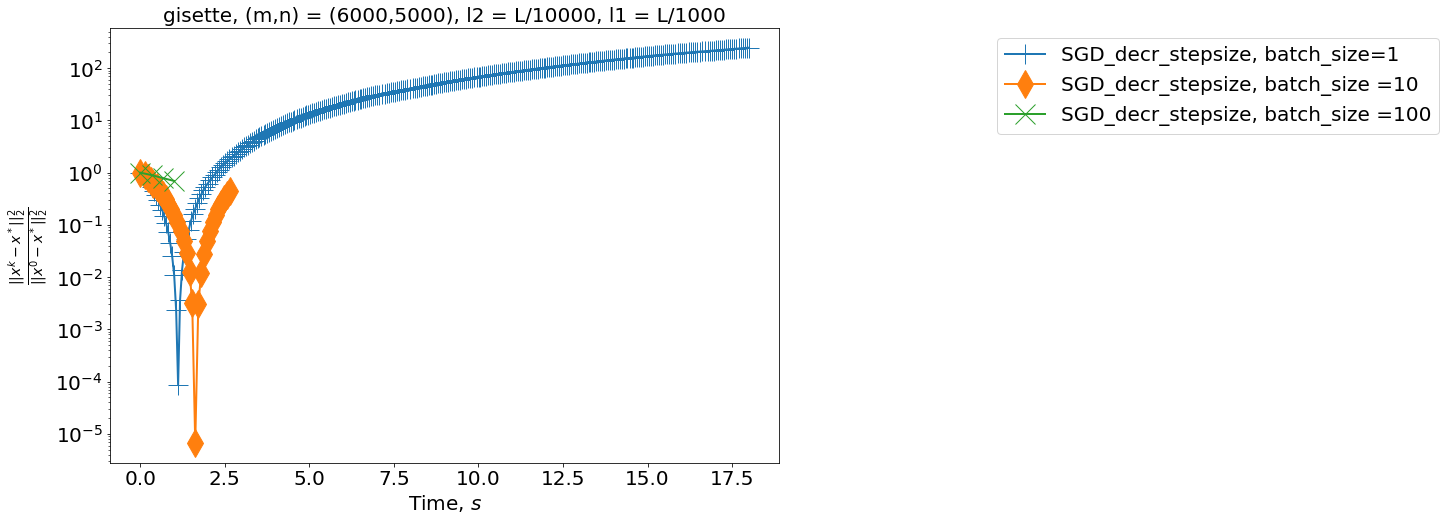

In [273]:
r_1 = 1
r_10 = 10
r_100 = 100
schedule = [0.01/(6*(L+l2)), 10, 0.8]

l2 = L / 10000
l1 = L / 1000
S = 5
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_1], 
           f', batch_size={r_1}', None],
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_10], 
           f', batch_size ={r_10}', None], # r_10 = 10, schedule = [gamma, 10, 0.8], S=100, l2 = L / 10000, l1 = L / 1000
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_100], 
           f', batch_size ={r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

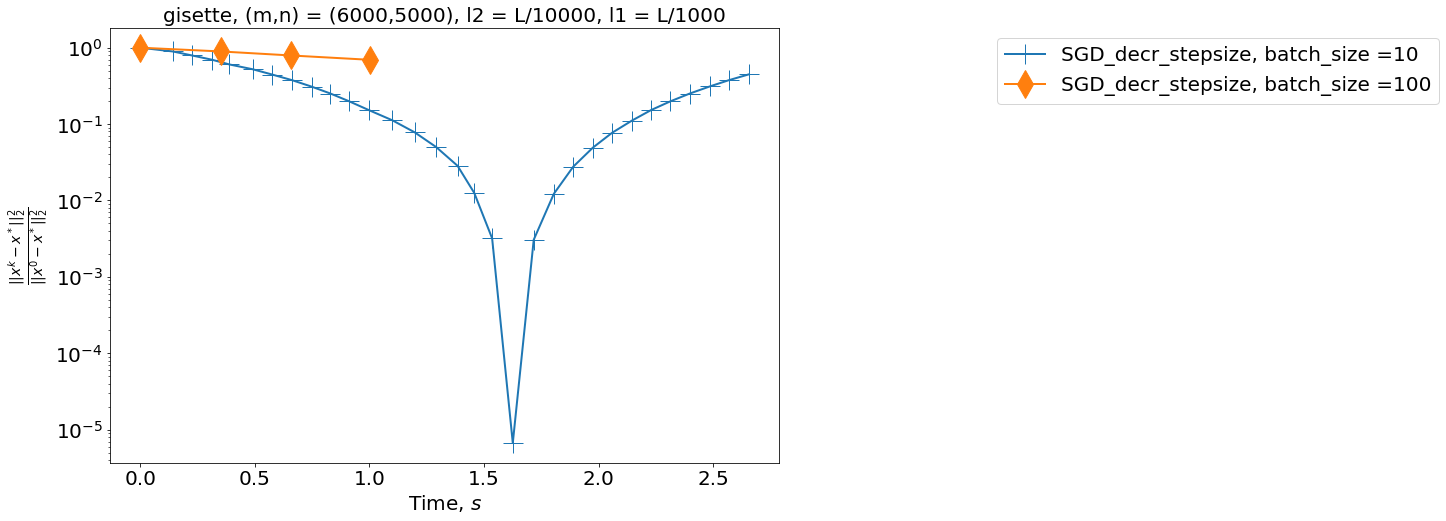

In [274]:
r_10 = 10
r_100 = 100
schedule = [0.01/(6*(L+l2)), 10, 0.8]

filename=dataset
l2 = L / 10000
l1 = L / 1000
S = 5
save_info_period = 100

methods = [
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_10], 
           f', batch_size ={r_10}', None],
        ['SGD_decr_stepsize', [schedule, l2, l1, S, r_100], 
           f', batch_size ={r_100}', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### FISTA

In [277]:
l2 = L / 10000
l1 = L / 1000
x_star = None
f_star = None
S = 50
save_info_period = 10
sparse = True
res = FISTA(filename=filename, x_init=x_init, A=A, y=y, L=L+l2, mu=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

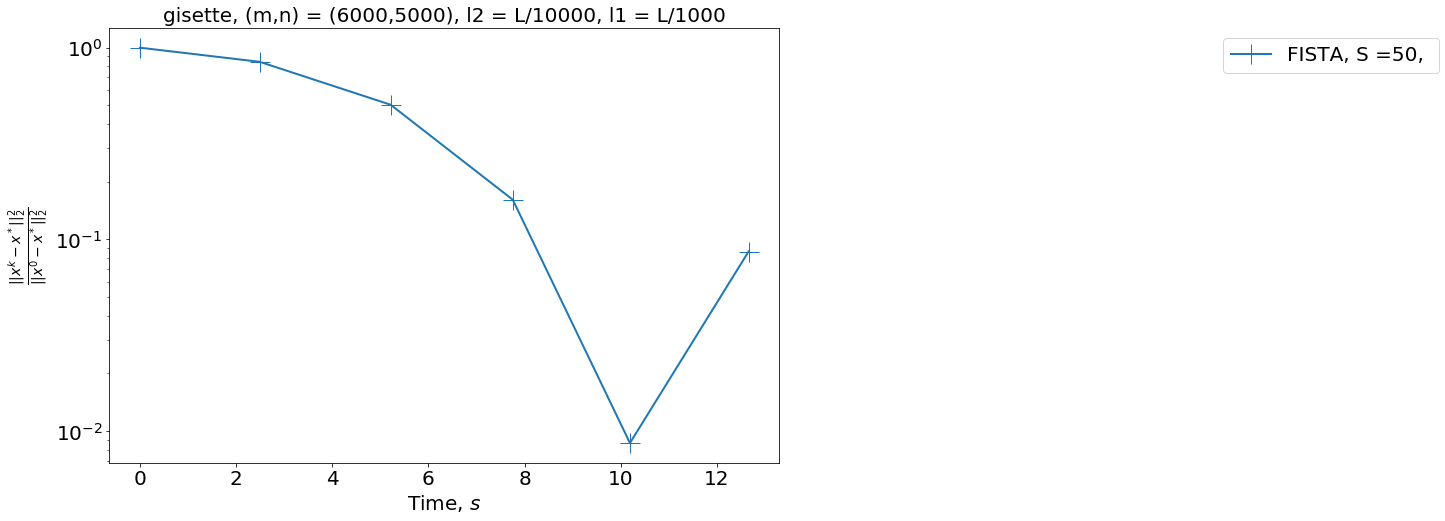

In [278]:
methods = [
         ['FISTA', [l2, l1, S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### prox-GD

In [279]:
l2 = L / 10000
l1 = L / 1000
gamma = 1.0/((L+l2))
x_star = None
f_star = None
S = 50
save_info_period = 10
res = prox_gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
     sparse=sparse, l1=l1, S=S, max_t=np.inf,
     save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

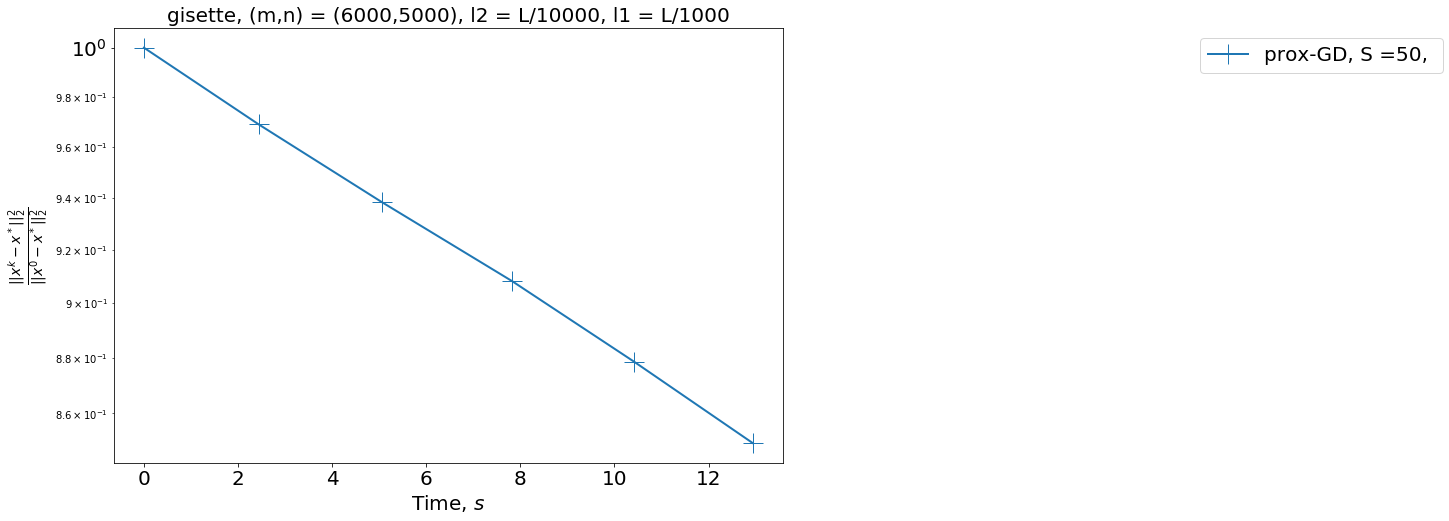

In [280]:
methods = [
         ['prox-GD', [gamma, l2, l1,S], 
           f', S ={S}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### GD

In [281]:
for gamma_ in [0.05, 0.1, 0.5, 1]:
    l2 = L / 10000
    l1 = L / 1000
    gamma = gamma_/((L+l2))
    S = 50
    save_info_period = 10
    sparse = False
    res = gd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, l2=l2, 
         sparse=sparse, l1=l1, S=S, max_t=np.inf,
         save_info_period=save_info_period, 
         x_star=x_star, f_star=f_star)

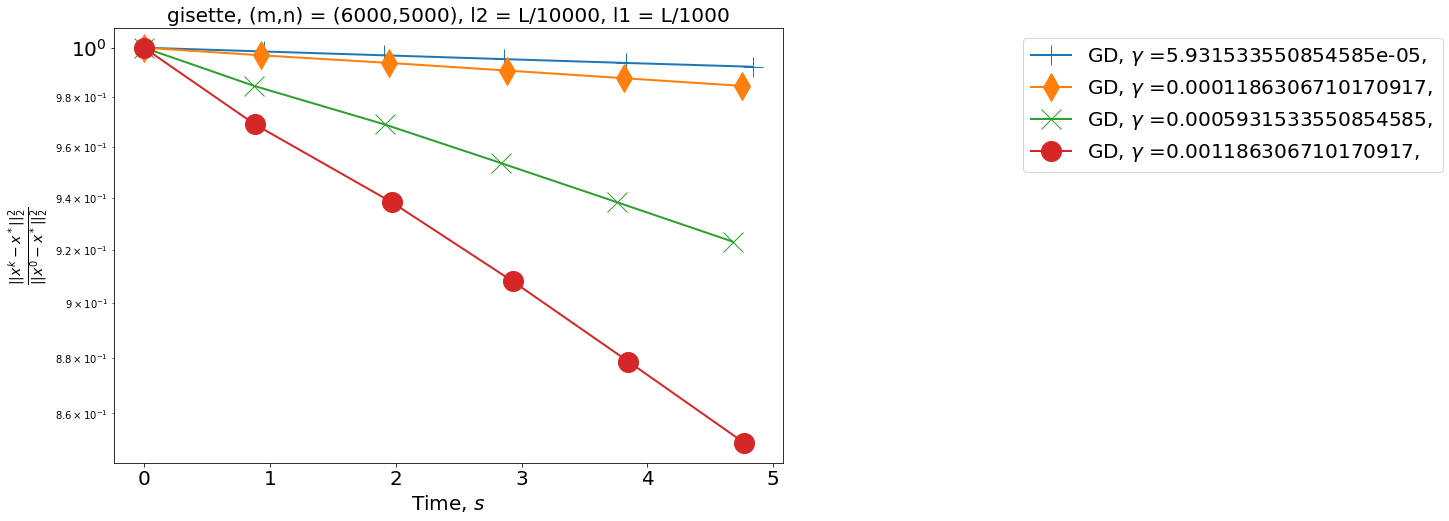

In [282]:
gamma_005 = 0.05/((L+l2))
gamma_01 = 0.1/((L+l2))
gamma_05 = 0.5/((L+l2))
gamma_1 = 1/((L+l2))

methods = [
    ['GD', [gamma_005,l2, l1, S], 
           f', $\gamma$ ={gamma_005}, ', None],
    ['GD', [gamma_01,l2, l1, S], 
           f', $\gamma$ ={gamma_01}, ', None],
    ['GD', [gamma_05,l2, l1, S], 
           f', $\gamma$ ={gamma_05}, ', None],
    ['GD', [gamma_1,l2, l1, S], 
           f', $\gamma$ ={gamma_1}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Общее сравнение

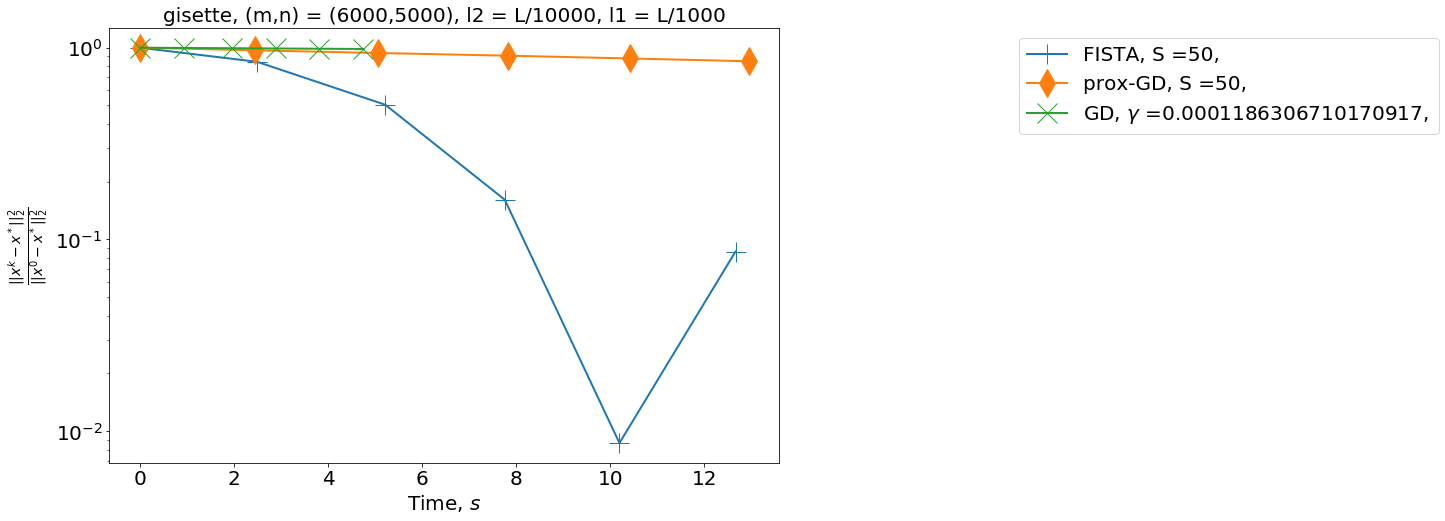

In [284]:
methods = [
        ['FISTA', [l2, l1, 50], 
           f', S ={50}, ', None],
        ['prox-GD', [gamma, l2, l1,50], 
           f', S ={50}, ', None],
        ['GD', [gamma_01,l2, l1, S], 
           f', $\gamma$ ={gamma_01}, ', None],
]

mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+", (m,n) = ("+str(m)+","+str(n)+"), l2 = L/"+str(int(L/l2))+", l1 = L/"+str(int(L/l1))

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)
plt.show()

#### Сравнение методов

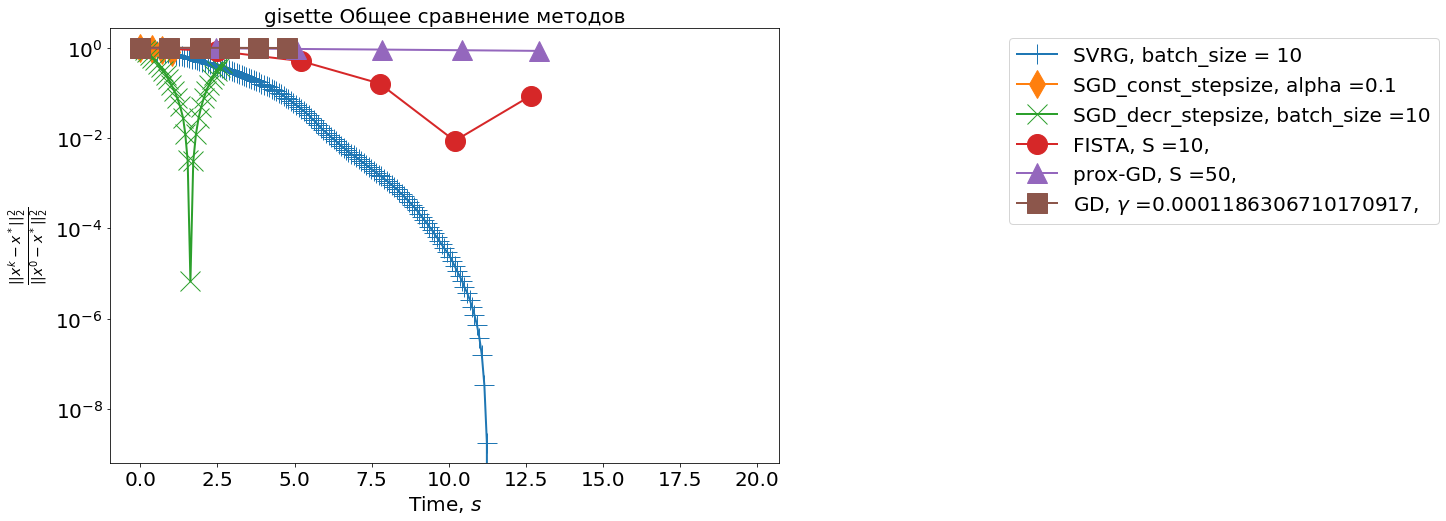

In [285]:
l2 = L / 10000
l1 = L / 1000
batch_size = 100
gamma = 1.0/(6*(L+l2))
methods = [
    ['SVRG', [1.0/(6.0*(L+l2)), L/10000, L/1000, 10, int(2*m/10), 10], 
           f', batch_size = {10}', None], # l2 = L / 10000, l1 = L / 1000, r_10=10, S=50
    
    ['SGD_const_stepsize', [0.1/((L+l2)), l2, l1, 5, 100], 
           f', alpha ={0.1} ', None], # l2 = L / 10000, l1 = L / 1000, S=100, gamma_01 = 0.1/((L+l2))
    
    ['SGD_decr_stepsize', [schedule, l2, l1, 5, 10], 
           f', batch_size ={r_10}', None], # r_10 = 10, schedule = [gamma, 10, 0.8], S=100, l2 = L / 10000, l1 = L / 1000
    
    ['FISTA', [l2, l1, 50], 
           f', S ={10}, ', None],
    
    ['prox-GD', [1.0/((L+l2)), l2, l1, 50], 
       f', S ={50}, ', None],
    
    ['GD', [gamma_01,l2, l1, 50], 
       f', $\gamma$ ={gamma_01}, ', None],
]
mode_y = 'squared_distances'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = dataset+" Общее сравнение методов"

args_for_plots = [dataset, filename, mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args=args_for_plots)

### Конечные наблюдения 8 эксперимента
В зависимости от датасета методы ведут себя по-разному. Увы нет времени тюнить параметры индивидуально. Но можно заключить что каждая задача требует индивидуального подхода.

# Задача наименьших квадратов

Для удобства продублируем здесь задачу, которую мы решаем
$$
f(x) = \frac{1}{2m}\|Ax - b\|_2^2 = \frac{1}{m}\sum\limits_{i=1}^m\underbrace{\frac{1}{2}(a_i^\top x - b_i)^2}_{f_i(x)} \to \min\limits_{x\in\mathbb{R}^n}
$$
$$
A = \begin{pmatrix}a_1^\top\\ \vdots\\ a_m^\top \end{pmatrix},\quad a_1,\ldots,a_m \in \mathbb{R}^n
$$

## Генерируем задачу

Строки матрицы выбираются случайно из стандартного нормального распределения (как и столбец $b$). Затем матрица нормируется так, что максимальное собственное число матрицы было равно единице.

In [286]:
def construct_least_squares(m=100, n=1000):
    A = np.array([norm_d.rvs(size=n)])
    for i in range(m-1):
        A = np.row_stack((A, norm_d.rvs(size=n)))
    A /= norm(A, ord=2)
    ATA = A.T.dot(A)
    sigmas_A = svdvals(ATA)
    mu_all = sigmas_A.min() * 1.0 / m
    L_all = 1.0 / m
        
    L_max = 0
    for i in range(m):
        cut_A = A[[i]]
        sigmas = svdvals(cut_A.T.dot(cut_A))
        test_L = sigmas.max()
        if test_L > L_max:
            L_max = test_L
    
    b = norm_d.rvs(size=m)
    A_pinv = scipy.linalg.pinv(A)
    x_star = A_pinv.dot(b)
    
    f_star = least_squares_val(x_star, [A, b])
    return A, b, mu_all, L_all, L_max, x_star, f_star

In [287]:
%%time
m = 200
n = 400
A, b, mu_all, L_all, L_max, x_star, f_star = construct_least_squares(m, n)
print("Константа сильной выпуклости всей функции: ", mu_all)
print("Константа гладкости всей функции         : ",L_all)
print("Худшая константа гладкости               : ",L_max)
print("Значение функции в решении               : ", f_star)

Константа сильной выпуклости всей функции:  1.957091674714989e-21
Константа гладкости всей функции         :  0.005
Худшая константа гладкости               :  0.41577255130566687
Значение функции в решении               :  5.2469970313226974e-30
Wall time: 7.19 s


In [288]:
max_norm = 0
for i in range(m):
    test_norm = norm(least_squares_grad(x_star, [A[[i]], b[[i]]]))
    if test_norm > max_norm:
        max_norm = test_norm
print("Максимальная норма градиента слагаемого в найденном решении: ", max_norm)

Максимальная норма градиента слагаемого в найденном решении:  6.28080482518887e-15


Как видим, решение, посчитанное при помощи псевдообратной матрицы, найдено очень точно

## Задание 1. SGD и SVRG

Перепишите методы $\texttt{SGD}$ с константным шагом и $\texttt{SVRG}$ (создайте новые функции, используя образцы), которые будут работать с задачей наименьших квадратов

Для начала выгрузим тестовую задачу

In [33]:
with open("dump/test_ls_problem.txt", 'rb') as file:
    A, b, mu_all, L_all, L_max, x_star, f_star = pickle.load(file)
m, n = A.shape
print("(m,n) = (",m,",",n,")")
print("Константа сильной выпуклости всей функции: ", mu_all)
print("Константа гладкости всей функции         : ",L_all)
print("Худшая константа гладкости               : ",L_max)
print("Значение функции в решении               : ", f_star)

(m,n) = ( 200 , 400 )
Константа сильной выпуклости всей функции:  6.5096642865727495e-21
Константа гладкости всей функции         :  0.005
Худшая константа гладкости               :  0.43427025053659135
Значение функции в решении               :  5.2024818649839586e-30


Загрузим стартовую точку

In [34]:
with open("dump/test_starting_point.txt", 'rb') as file:
    x_init = pickle.load(file)

In [35]:
with open("dump/indices_test_ls.txt", 'rb') as file:
    test_indices = pickle.load(file)

batch_size = 1
gamma_sgd = 1.0/L_max
S = 10
save_info_period = 10

In [36]:
%%time
res = sgd_ls(x_init=x_init, A=A, b=b, gamma=gamma_sgd, S=S, 
             batch_size=batch_size, indices=test_indices,
             save_info_period=save_info_period,
             x_star=x_star, f_star=f_star)

Wall time: 84.8 ms


In [37]:
res['func_vals'][-1]

0.012365487542244058

In [38]:
sgd_ls_test(res)

Тесты пройдены!


0

In [39]:
with open("dump/indices_test_ls.txt", 'rb') as file:
    test_indices = pickle.load(file)

batch_size = 1
gamma_svrg = 1.0/(6*L_max)
M = int(2 * m / batch_size)
S = 10
save_info_period = 10

In [40]:
%%time
res = svrg_ls(x_init=x_init, A=A, b=b, gamma=gamma_svrg, S=S, M=M, 
             batch_size=batch_size, indices=test_indices,
             save_info_period=save_info_period,
             x_star=x_star, f_star=f_star)

Wall time: 212 ms


In [297]:
res['func_vals'][-1]

0.05700184290810526

In [298]:
svrg_ls_test(res)

Тесты пройдены!


0

## Задание 2. SGD-star

Для начала выгрузим тестовую задачу

In [299]:
with open("dump/test_ls_problem_2.txt", 'rb') as file:
    A, b, mu_all, L_all, L_max, x_star, f_star = pickle.load(file)
m, n = A.shape
print("(m,n) = (",m,",",n,")")
print("Константа сильной выпуклости всей функции: ", mu_all)
print("Константа гладкости всей функции         : ",L_all)
print("Худшая константа гладкости               : ",L_max)
print("Значение функции в решении               : ", f_star)

(m,n) = ( 300 , 100 )
Константа сильной выпуклости всей функции:  0.00024905911686002083
Константа гладкости всей функции         :  0.0033333333333333335
Худшая константа гладкости               :  0.18781048838384848
Значение функции в решении               :  0.34467839429707253


Загрузим стартовую точку

In [300]:
with open("dump/test_starting_point_2.txt", 'rb') as file:
    x_init = pickle.load(file)

In [301]:
with open("dump/test_ls_problem_2.txt", 'rb') as file:
    A, b, mu_all, L_all, L_max, x_star, f_star = pickle.load(file)
m, n = A.shape
with open("dump/test_starting_point_2.txt", 'rb') as file:
    x_init = pickle.load(file)
with open("dump/indices_test_ls_2.txt", 'rb') as file:
    test_indices = pickle.load(file)

batch_size = 1
gamma_sgd = 1.0/L_max
S = 10
save_info_period = 10

In [302]:
%%time
res = sgd_star_ls(x_init=x_init, A=A, b=b, gamma=gamma_sgd, S=S, 
             batch_size=batch_size, indices=test_indices,
             save_info_period=save_info_period,
             x_star=x_star, f_star=f_star)

Wall time: 806 ms


In [303]:
res['func_vals'][-1]

1.9960705136545798e-06

In [304]:
sgd_star_ls_test(res)

Тесты пройдены!


0

## Задание 3. SLCM

Для начала выгрузим тестовую задачу

In [335]:
with open("dump/test_ls_problem.txt", 'rb') as file:
    A, b, mu_all, L_all, L_max, x_star, f_star = pickle.load(file)
m, n = A.shape
print("(m,n) = (",m,",",n,")")
print("Константа сильной выпуклости всей функции: ", mu_all)
print("Константа гладкости всей функции         : ",L_all)
print("Худшая константа гладкости               : ",L_max)
print("Значение функции в решении               : ", f_star)

(m,n) = ( 200 , 400 )
Константа сильной выпуклости всей функции:  6.5096642865727495e-21
Константа гладкости всей функции         :  0.005
Худшая константа гладкости               :  0.43427025053659135
Значение функции в решении               :  5.2024818649839586e-30


Загрузим стартовую точку

In [332]:
with open("dump/test_starting_point.txt", 'rb') as file:
    x_init = pickle.load(file)

In [7]:
with open("dump/test_ls_problem.txt", 'rb') as file:
    A, b, mu_all, L_all, L_max, x_star, f_star = pickle.load(file)   
with open("dump/indices_test_ls.txt", 'rb') as file:
    test_indices = pickle.load(file)
with open("dump/test_starting_point.txt", 'rb') as file:
    x_init = pickle.load(file)
    
batch_size_slcm = 7
eta = 30
S_slcm = 10
save_info_period = 1

In [308]:
%%time
res = slcm_ls(x_init=x_init, A=A, b=b, L=L_all, 
              eta=eta, S=S_slcm, batch_size=batch_size_slcm, 
              indices=test_indices, x_star=x_star, f_star=f_star)

Wall time: 20.9 ms


In [309]:
res['func_vals'][-1]

0.03016885114243636

In [310]:
slcm_ls_test(res)

Тесты пройдены!


0

## Задание 4. Эксперименты с разными матрицами

Проведите эксперименты, указанные в задании.

Постройте графики. Воспользуйтесь функциями ниже.

In [2]:
def read_results_from_file(method, args):
    if method == 'SVRG':
        with open('dump/SVRG_ls_m_'+str(args[0])+'_n_'+str(args[1])
                  +'_gamma_'+str(args[2])+"_num_of_epochs_"+str(args[3])
              +"_epoch_length_"+str(args[4])+"_batch_size_"+str(args[5])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == 'SGD':
        with open('dump/SGD_ls_m_'+str(args[0])+'_n_'+str(args[1])
                  +'_gamma_'+str(args[2])+"_num_of_epochs_"+str(args[3])
              +"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == 'SGD_star':
        with open('dump/SGD_star_ls_m_'+str(args[0])+'_n_'+str(args[1])
                  +'_gamma_'+str(args[2])+"_num_of_epochs_"+str(args[3])
              +"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)
    if method == 'SLCM':
        with open('dump/SLCM_ls_m_'+str(args[0])+'_n_'+str(args[1])
                  +'_eta_'+str(args[2])+"_num_of_epochs_"+str(args[3])
              +"_batch_size_"+str(args[4])+".txt", 'rb') as file:
            return pickle.load(file)

In [76]:
def make_plots(args):
    supported_modes_y = ['squared_distances', 'func_vals']
    supported_modes_x = ['time', 'data_passes', 'iters']
    
    mode_y = args[0]
    mode_x = args[1]
    figsize = args[2]
    fontsize = args[3]
    title = args[4]
    methods = args[5]
    
    assert(mode_y in supported_modes_y)
    assert(mode_x in supported_modes_x)
    
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=fontsize)
    marker = itertools.cycle(('+', 'd', 'x', 'o', '^', 's', '*', 'p', '<', '>', '^'))
    
    num_of_methods = len(methods)
    for idx, method in enumerate(methods):
        res = read_results_from_file(method[0], method[1])
        if method[3] == None:
            length = len(res['iters'])
        else:
            length = method[3]
        plt.semilogy(res[mode_x][0:length], res[mode_y][0:length] / res[mode_y][0], linewidth=2, marker=next(marker), 
            markersize = 20, 
            markevery=range(-idx*int(length/(10*num_of_methods)), len(res[mode_x][0:length]), int(length/10)), 
            label = method[0]+method[2])
        
    
    plt.legend(bbox_to_anchor=(2,1), loc="upper right", fontsize=fontsize)
    if mode_x == 'time':
        plt.xlabel(r"Time, $s$", fontsize=fontsize)
    if mode_x == 'sampled_grads':
        plt.xlabel(r"Number of sampled gradients / number of data samples", fontsize=fontsize)
    if mode_x == 'iters':
        plt.xlabel(r"Number of iterations", fontsize=fontsize)
    if mode_y == 'squared_distances':
        plt.ylabel(r"$\frac{||x^k - x^*||_2^2}{||x^0 - x^*||_2^2}$", fontsize=fontsize)
    if mode_y == 'func_vals':
        plt.ylabel(r"$\frac{f(x^k)-f(x^())}{f(x^0)-f(x^*)}$", fontsize=fontsize)
    
    plt.xticks(fontsize=fontsize)
    _ = plt.yticks(fontsize=fontsize)
    
import warnings
warnings.filterwarnings('ignore')

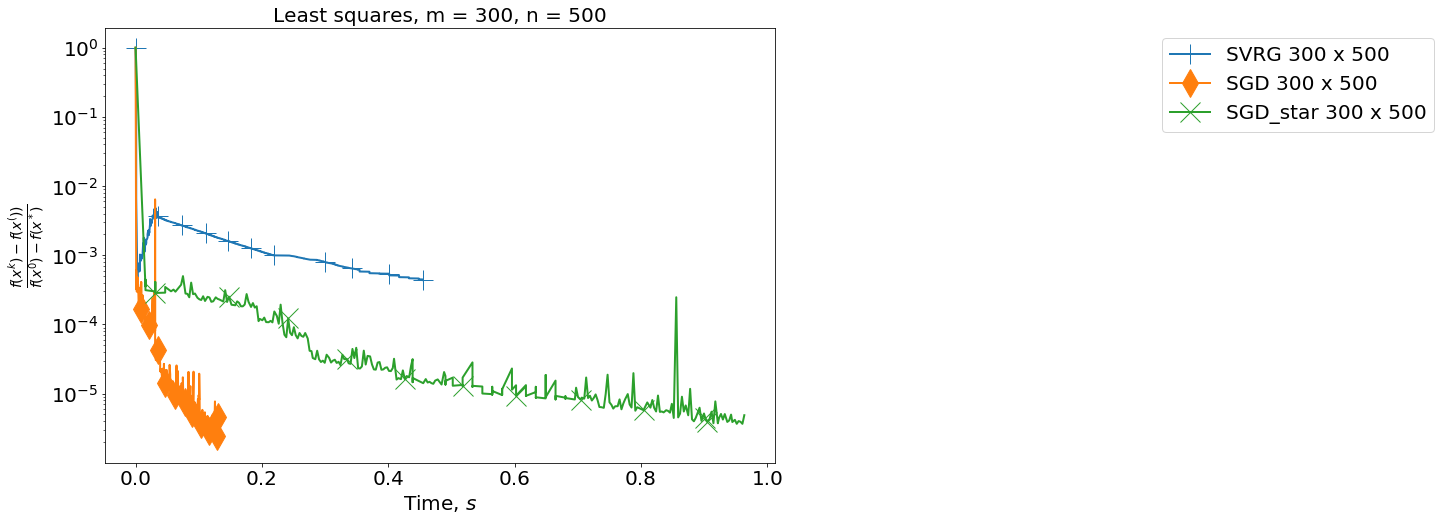

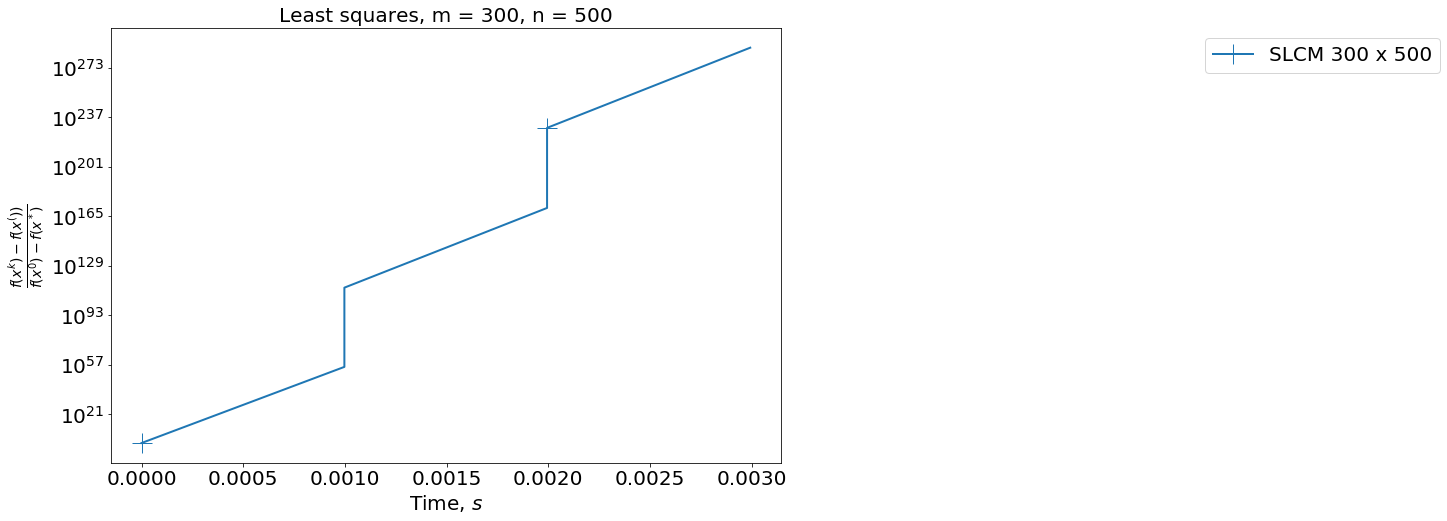

In [88]:
m = 300
n = 500
A = np.random.rand(m,n)
b = np.random.rand(m)
x_init = np.ones(n)
test_indices=None
L_max = np.max(A @ A.T)

batch_size = 1
gamma_sgd = 1.0/L_max
S = 10
save_info_period = 10

sgd_res = sgd_ls(x_init=x_init, A=A, b=b, gamma=gamma_sgd, S=S, 
             batch_size=batch_size, indices=test_indices,
             save_info_period=save_info_period,
             x_star=None, f_star=None)

batch_size = 1
gamma_svrg = 1.0/(6*L_max)
M = int(2 * m / batch_size)
svrg_res = svrg_ls(x_init=x_init, A=A, b=b, gamma=gamma_svrg, S=S, M=M, 
             batch_size=batch_size, indices=None,
             save_info_period=save_info_period,
             x_star=None, f_star=None)

batch_size = 1
gamma_sgd = 1.0/L_max
S = 10
save_info_period = 10
sgd_star_res = sgd_star_ls(x_init=x_init, A=A, b=b, gamma=gamma_sgd, S=S, 
             batch_size=batch_size, indices=None,
             save_info_period=save_info_period,
             x_star=None, f_star=None)

batch_size_slcm = 7
eta = 30
S_slcm = 10
save_info_period = 1
res = slcm_ls(x_init=x_init, A=A, b=b, L=L_all, 
              eta=eta, S=S_slcm, batch_size=batch_size_slcm, 
              indices=None, x_star=None, f_star=None)

methods = [
            ['SVRG', [m,n, gamma_svrg, 10, int(2*m/1), 1], 
                f" {m} x {n}", None],
            ['SGD', [m,n, gamma_sgd, 10, 1], 
               f" {m} x {n}", None],
            ['SGD_star', [m,n, gamma_sgd, 10, 1], 
               f" {m} x {n}", None],
        ]
mode_y = 'func_vals'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = 'Least squares, m = '+str(m)+', n = '+str(n)

args_for_plots = [mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args_for_plots)

methods = [
            ['SLCM', [m,n, 30, 10, 7], 
               f" {m} x {n}", None],
        ]
mode_y = 'func_vals'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = 'Least squares, m = '+str(m)+', n = '+str(n)

args_for_plots = [mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args_for_plots)

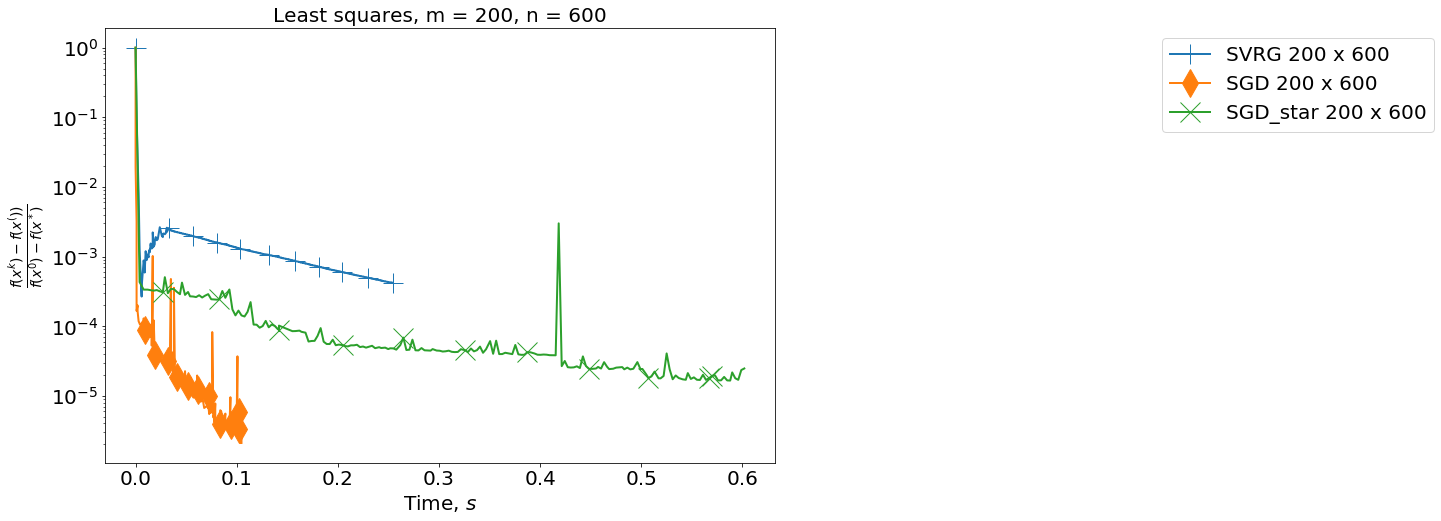

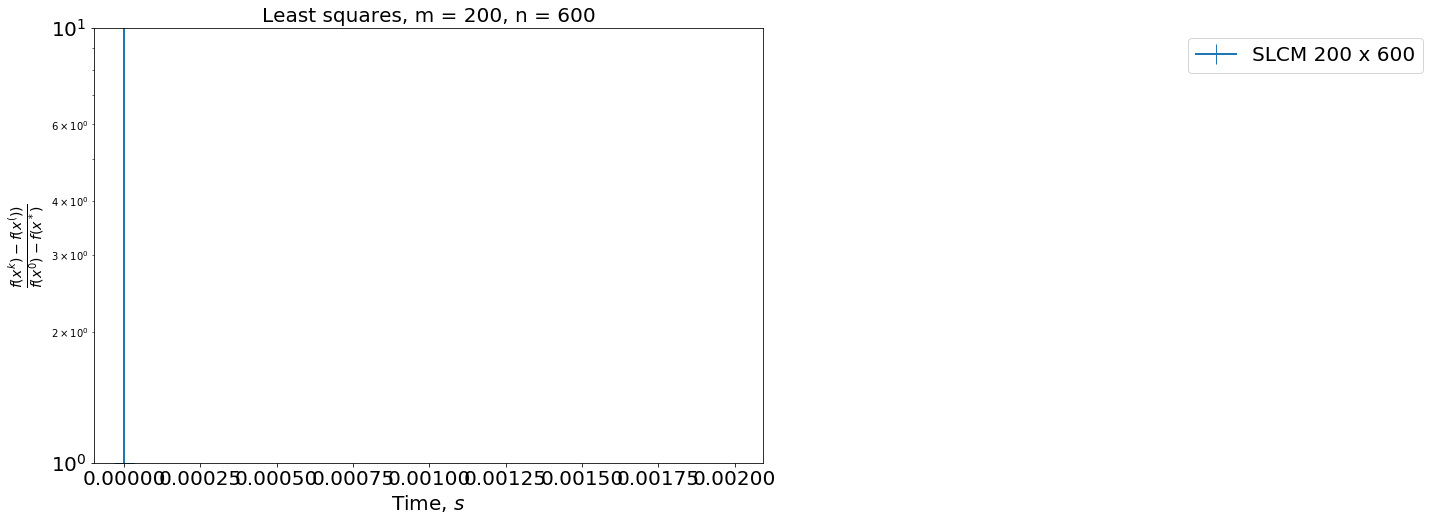

In [87]:
m = 200
n = 600
A = np.random.rand(m,n)
b = np.random.rand(m)
x_init = np.ones(n)
test_indices=None
L_max = np.max(A @ A.T)

batch_size = 1
gamma_sgd = 1.0/L_max
S = 10
save_info_period = 10

sgd_res = sgd_ls(x_init=x_init, A=A, b=b, gamma=gamma_sgd, S=S, 
             batch_size=batch_size, indices=test_indices,
             save_info_period=save_info_period,
             x_star=None, f_star=None)

batch_size = 1
gamma_svrg = 1.0/(6*L_max)
M = int(2 * m / batch_size)
svrg_res = svrg_ls(x_init=x_init, A=A, b=b, gamma=gamma_svrg, S=S, M=M, 
             batch_size=batch_size, indices=None,
             save_info_period=save_info_period,
             x_star=None, f_star=None)

batch_size = 1
gamma_sgd = 1.0/L_max
S = 10
save_info_period = 10
sgd_star_res = sgd_star_ls(x_init=x_init, A=A, b=b, gamma=gamma_sgd, S=S, 
             batch_size=batch_size, indices=None,
             save_info_period=save_info_period,
             x_star=None, f_star=None)

batch_size_slcm = 7
eta = 30
S_slcm = 10
save_info_period = 1
res = slcm_ls(x_init=x_init, A=A, b=b, L=L_all, 
              eta=eta, S=S_slcm, batch_size=batch_size_slcm, 
              indices=None, x_star=None, f_star=None)

methods = [
            ['SVRG', [m,n, gamma_svrg, 10, int(2*m/1), 1], 
                f" {m} x {n}", None],
            ['SGD', [m,n, gamma_sgd, 10, 1], 
               f" {m} x {n}", None],
            ['SGD_star', [m,n, gamma_sgd, 10, 1], 
               f" {m} x {n}", None],
        ]
mode_y = 'func_vals'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = 'Least squares, m = '+str(m)+', n = '+str(n)

args_for_plots = [mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args_for_plots)

methods = [
            ['SLCM', [m,n, 30, 10, 7], 
               f" {m} x {n}", None],
        ]
mode_y = 'func_vals'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = 'Least squares, m = '+str(m)+', n = '+str(n)

args_for_plots = [mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args_for_plots)

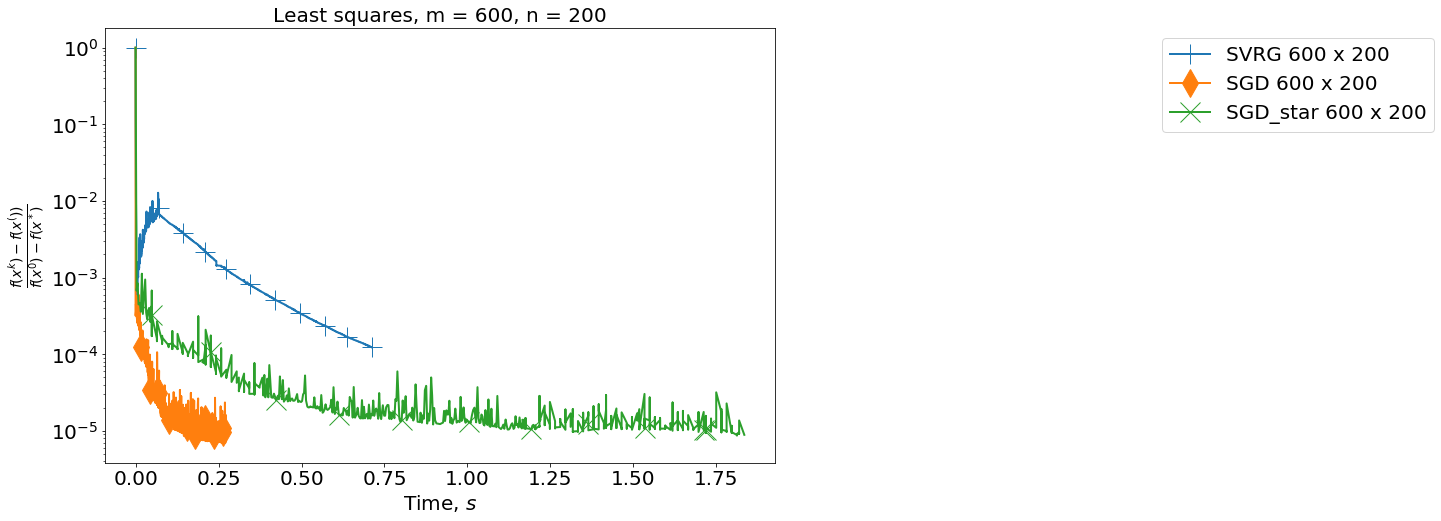

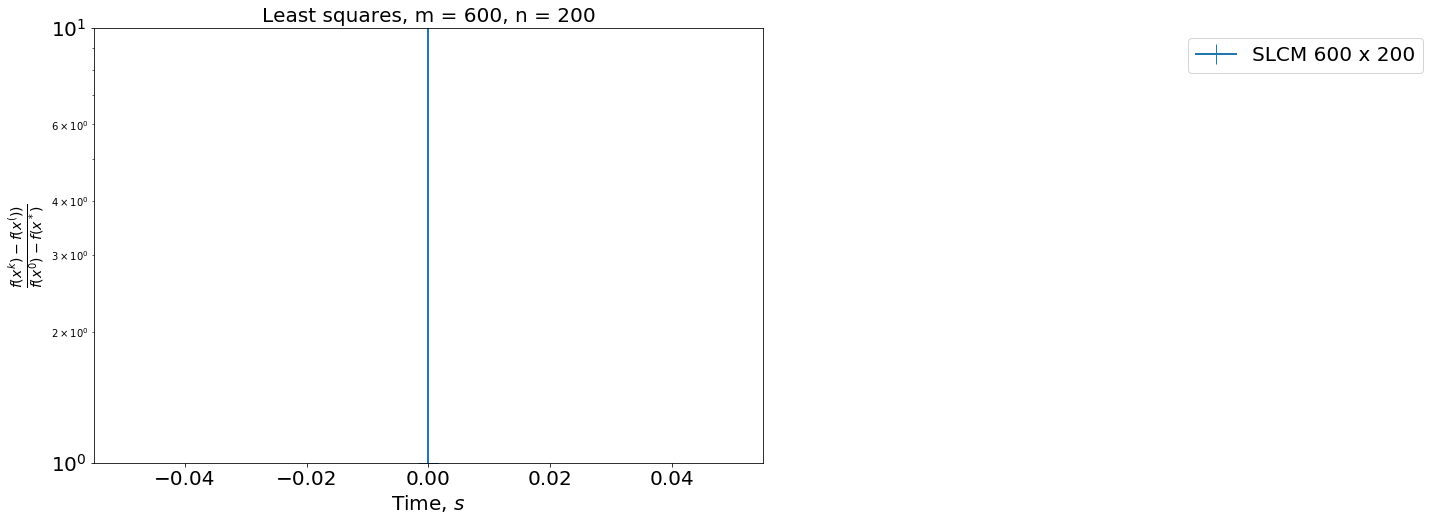

In [89]:
m = 600
n = 200
A = np.random.rand(m,n)
b = np.random.rand(m)
x_init = np.ones(n)
test_indices=None
L_max = np.max(A @ A.T)

batch_size = 1
gamma_sgd = 1.0/L_max
S = 10
save_info_period = 10

sgd_res = sgd_ls(x_init=x_init, A=A, b=b, gamma=gamma_sgd, S=S, 
             batch_size=batch_size, indices=test_indices,
             save_info_period=save_info_period,
             x_star=None, f_star=None)

batch_size = 1
gamma_svrg = 1.0/(6*L_max)
M = int(2 * m / batch_size)
svrg_res = svrg_ls(x_init=x_init, A=A, b=b, gamma=gamma_svrg, S=S, M=M, 
             batch_size=batch_size, indices=None,
             save_info_period=save_info_period,
             x_star=None, f_star=None)

batch_size = 1
gamma_sgd = 1.0/L_max
S = 10
save_info_period = 10
sgd_star_res = sgd_star_ls(x_init=x_init, A=A, b=b, gamma=gamma_sgd, S=S, 
             batch_size=batch_size, indices=None,
             save_info_period=save_info_period,
             x_star=None, f_star=None)

batch_size_slcm = 7
eta = 30
S_slcm = 10
save_info_period = 1
res = slcm_ls(x_init=x_init, A=A, b=b, L=L_all, 
              eta=eta, S=S_slcm, batch_size=batch_size_slcm, 
              indices=None, x_star=None, f_star=None)

methods = [
            ['SVRG', [m,n, gamma_svrg, 10, int(2*m/1), 1], 
                f" {m} x {n}", None],
            ['SGD', [m,n, gamma_sgd, 10, 1], 
               f" {m} x {n}", None],
            ['SGD_star', [m,n, gamma_sgd, 10, 1], 
               f" {m} x {n}", None],
        ]
mode_y = 'func_vals'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = 'Least squares, m = '+str(m)+', n = '+str(n)

args_for_plots = [mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args_for_plots)

methods = [
            ['SLCM', [m,n, 30, 10, 7], 
               f" {m} x {n}", None],
        ]
mode_y = 'func_vals'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = 'Least squares, m = '+str(m)+', n = '+str(n)

args_for_plots = [mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args_for_plots)

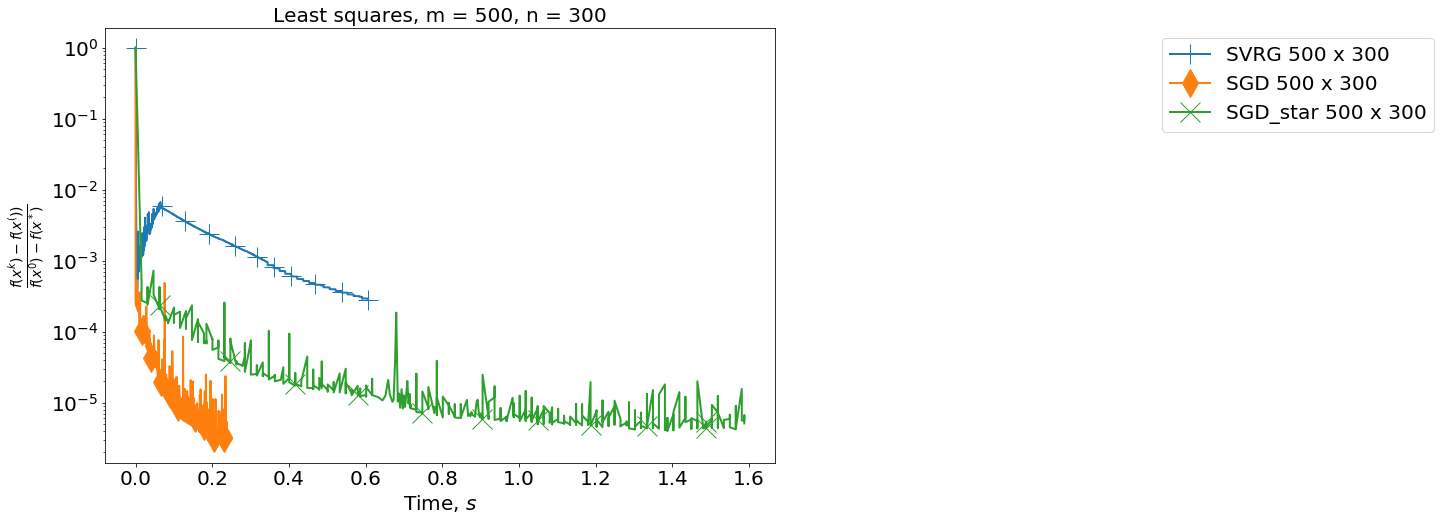

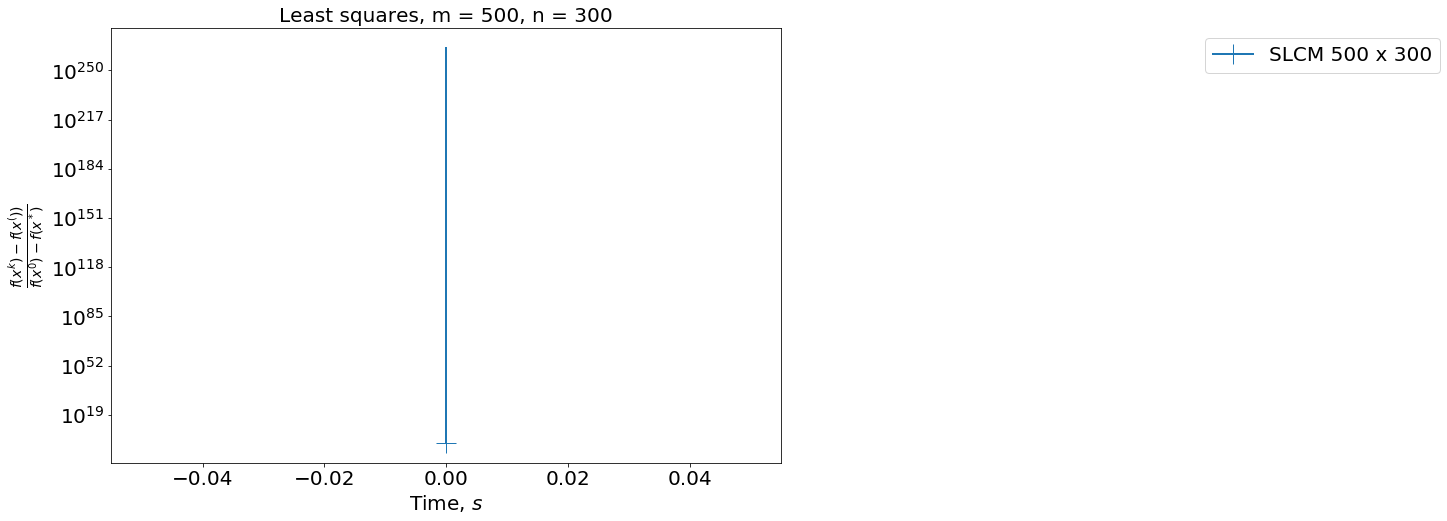

In [92]:
m = 500
n = 300
A = np.random.rand(m,n)
b = np.random.rand(m)
x_init = np.ones(n)
test_indices=None
L_max = np.max(A @ A.T)

batch_size = 1
gamma_sgd = 1.0/L_max
S = 10
save_info_period = 10

sgd_res = sgd_ls(x_init=x_init, A=A, b=b, gamma=gamma_sgd, S=S, 
             batch_size=batch_size, indices=test_indices,
             save_info_period=save_info_period,
             x_star=None, f_star=None)

batch_size = 1
gamma_svrg = 1.0/(6*L_max)
M = int(2 * m / batch_size)
svrg_res = svrg_ls(x_init=x_init, A=A, b=b, gamma=gamma_svrg, S=S, M=M, 
             batch_size=batch_size, indices=None,
             save_info_period=save_info_period,
             x_star=None, f_star=None)

batch_size = 1
gamma_sgd = 1.0/L_max
S = 10
save_info_period = 10
sgd_star_res = sgd_star_ls(x_init=x_init, A=A, b=b, gamma=gamma_sgd, S=S, 
             batch_size=batch_size, indices=None,
             save_info_period=save_info_period,
             x_star=None, f_star=None)

batch_size_slcm = 7
eta = 30
S_slcm = 10
save_info_period = 1
res = slcm_ls(x_init=x_init, A=A, b=b, L=L_all, 
              eta=eta, S=S_slcm, batch_size=batch_size_slcm, 
              indices=None, x_star=None, f_star=None)

methods = [
            ['SVRG', [m,n, gamma_svrg, 10, int(2*m/1), 1], 
                f" {m} x {n}", None],
            ['SGD', [m,n, gamma_sgd, 10, 1], 
               f" {m} x {n}", None],
            ['SGD_star', [m,n, gamma_sgd, 10, 1], 
               f" {m} x {n}", None],
        ]
mode_y = 'func_vals'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = 'Least squares, m = '+str(m)+', n = '+str(n)

args_for_plots = [mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args_for_plots)

methods = [
            ['SLCM', [m,n, 30, 10, 7], 
               f" {m} x {n}", None],
        ]
mode_y = 'func_vals'
mode_x = 'time'
figsize = (12, 8)
fontsize = 20
title = 'Least squares, m = '+str(m)+', n = '+str(n)

args_for_plots = [mode_y, mode_x, figsize, fontsize, title, methods]
make_plots(args_for_plots)

#### Наблюдения
SLCM ведёт ведёт себя очень странно. Не могу прокомментировать почему. В случае когда n>m методы могут не сходиться потому что количество датапоинтов маленькое по сравнению с количеством фичей и в результате нет уникального решения.